In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
from deepcell_tracking.utils import Track, load_trks
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.5.0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [2]:
def self_supervised_loss(y_true, y_pred):
    
    # Pair the current embedding with the future ground truth
    # so that we predict the future from the past
    
    current_reconstruction = y_pred
    gt = y_true
    
    loss = tf.keras.metrics.mean_squared_error(gt, current_reconstruction)
    
    return loss

In [3]:
autoencoder = tf.keras.models.load_model('/data/models/pad_dense/pad_dense_model', custom_objects={'self_supervised_loss': self_supervised_loss})
app_encoder = tf.keras.models.load_model('/data/models/pad_dense/pad_dense_app_encoder')
embedding_model = tf.keras.models.load_model('/data/models/pad_dense/pad_dense_embedding_model')
app_decoder = tf.keras.models.load_model('/data/models/pad_dense/pad_dense_app_decoder')

In [4]:
# Implementation to get 64x64 images (since images are 65x64 by correct implementation)

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import io
import json
import os
import re
import tarfile
import tempfile

import numpy as np
import math

from scipy.spatial.distance import cdist

from skimage.measure import regionprops
from skimage.segmentation import relabel_sequential

from deepcell_toolbox.utils import resize


def clean_up_annotations(y, uid=None, data_format='channels_last'):
    """Relabels every frame in the label matrix.
    Args:
        y (np.array): annotations to relabel sequentially.
        uid (int, optional): starting ID to begin labeling cells.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        np.array: Cleaned up annotations.
    """
    y = y.astype('int32')
    time_axis = 1 if data_format == 'channels_first' else 0
    num_frames = y.shape[time_axis]

    all_uniques = []
    for f in range(num_frames):
        cells = np.unique(y[:, f] if data_format == 'channels_first' else y[f])
        cells = np.delete(cells, np.where(cells == 0))
        all_uniques.append(cells)

    # The annotations need to be unique across all frames
    uid = sum(len(x) for x in all_uniques) + 1 if uid is None else uid
    for frame, unique_cells in zip(range(num_frames), all_uniques):
        y_frame = y[:, frame] if data_format == 'channels_first' else y[frame]
        y_frame_new = np.zeros(y_frame.shape)
        for cell_label in unique_cells:
            y_frame_new[y_frame == cell_label] = uid
            uid += 1
        if data_format == 'channels_first':
            y[:, frame] = y_frame_new
        else:
            y[frame] = y_frame_new
    return y


def count_pairs(y, same_probability=0.5, data_format='channels_last'):
    """Compute number of training samples needed to observe all cell pairs.
    Args:
        y (np.array): 5D tensor of cell labels.
        same_probability (float): liklihood that 2 cells are the same.
        data_format (str): determines the order of the channel axis,
            one of 'channels_first' and 'channels_last'.
    Returns:
        int: the total pairs needed to sample to see all possible pairings.
    """
    total_pairs = 0
    zaxis = 2 if data_format == 'channels_first' else 1
    for b in range(y.shape[0]):
        # count the number of cells in each image of the batch
        cells_per_image = []
        for f in range(y.shape[zaxis]):
            if data_format == 'channels_first':
                num_cells = len(np.unique(y[b, :, f, :, :]))
            else:
                num_cells = len(np.unique(y[b, f, :, :, :]))
            cells_per_image.append(num_cells)

        # Since there are many more possible non-self pairings than there
        # are self pairings, we want to estimate the number of possible
        # non-self pairings and then multiply that number by two, since the
        # odds of getting a non-self pairing are 50%, to find out how many
        # pairs we would need to sample to (statistically speaking) observe
        # all possible cell-frame pairs. We're going to assume that the
        # average cell is present in every frame. This will lead to an
        # underestimate of the number of possible non-self pairings, but it
        # is unclear how significant the underestimate is.
        average_cells_per_frame = sum(cells_per_image) // y.shape[zaxis]
        non_self_cellframes = (average_cells_per_frame - 1) * y.shape[zaxis]
        non_self_pairings = non_self_cellframes * max(cells_per_image)

        # Multiply cell pairings by 2 since the
        # odds of getting a non-self pairing are 50%
        cell_pairings = non_self_pairings // same_probability
        # Add this batch cell-pairings to the total count
        total_pairs += cell_pairings
    return total_pairs


def load_trks(filename):
    """Load a trk/trks file.
    Args:
        filename (str): full path to the file including .trk/.trks.
    Returns:
        dict: A dictionary with raw, tracked, and lineage data.
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = io.BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = io.BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

        # trks.extractfile opens a file in bytes mode, json can't use bytes.
        _, file_extension = os.path.splitext(filename)

        if file_extension == '.trks':
            trk_data = trks.getmember('lineages.json')
            lineages = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            for i, tracks in enumerate(lineages):
                lineages[i] = {int(k): v for k, v in tracks.items()}

        elif file_extension == '.trk':
            trk_data = trks.getmember('lineage.json')
            lineage = json.loads(trks.extractfile(trk_data).read().decode())
            # JSON only allows strings as keys, so convert them back to ints
            lineages = []
            lineages.append({int(k): v for k, v in lineage.items()})

    return {'lineages': lineages, 'X': raw, 'y': tracked}


def trk_folder_to_trks(dirname, trks_filename):
    """Compiles a directory of trk files into one trks_file.
    Args:
        dirname (str): full path to the directory containing multiple trk files.
        trks_filename (str): desired filename (the name should end in .trks).
    """
    lineages = []
    raw = []
    tracked = []

    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    file_list = os.listdir(dirname)
    file_list_sorted = sorted(file_list, key=alphanum_key)

    for filename in file_list_sorted:
        trk = load_trks(os.path.join(dirname, filename))
        lineages.append(trk['lineages'][0])  # this is loading a single track
        raw.append(trk['X'])
        tracked.append(trk['y'])

    file_path = os.path.join(os.path.dirname(dirname), trks_filename)

    save_trks(file_path, lineages, raw, tracked)


def save_trks(filename, lineages, raw, tracked):
    """Saves raw, tracked, and lineage data into one trks_file.
    Args:
        filename (str): full path to the final trk files.
        lineages (dict): a list of dictionaries saved as a json.
        raw (np.array): raw images data.
        tracked (np.array): annotated image data.
    Raises:
        ValueError: filename does not end in ".trks".
    """
    if not str(filename).lower().endswith('.trks'):
        raise ValueError('filename must end with `.trks`. Found %s' % filename)

    with tarfile.open(filename, 'w:gz') as trks:
        with tempfile.NamedTemporaryFile('w', delete=False) as lineages_file:
            json.dump(lineages, lineages_file, indent=4)
            lineages_file.flush()
            lineages_file.close()
            trks.add(lineages_file.name, 'lineages.json')
            os.remove(lineages_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            raw_file.close()
            trks.add(raw_file.name, 'raw.npy')
            os.remove(raw_file.name)

        with tempfile.NamedTemporaryFile(delete=False) as tracked_file:
            np.save(tracked_file, tracked)
            tracked_file.flush()
            tracked_file.close()
            trks.add(tracked_file.name, 'tracked.npy')
            os.remove(tracked_file.name)


def trks_stats(filename):
    """For a given trks_file, find the Number of cell tracks,
       the Number of frames per track, and the Number of divisions.
    Args:
        filename (str): full path to a trks file.
    Raises:
        ValueError: filename is not a .trk or .trks file.
    """
    ext = os.path.splitext(filename)[-1].lower()
    if ext not in {'.trks', '.trk'}:
        raise ValueError('`trks_stats` expects a .trk or .trks but found a ' +
                         str(ext))

    training_data = load_trks(filename)
    X = training_data['X']
    y = training_data['y']
    daughters = [{cell: fields['daughters']
                  for cell, fields in tracks.items()}
                 for tracks in training_data['lineages']]

    print('Dataset Statistics: ')
    print('Image data shape: ', X.shape)
    print('Number of lineages (should equal batch size): ',
          len(training_data['lineages']))

    # Calculate cell density
    frame_area = X.shape[2] * X.shape[3]

    avg_cells_in_frame = []
    for batch in range(y.shape[0]):
        num_cells_in_frame = []
        for frame in y[batch]:
            cells_in_frame = len(np.unique(frame)) - 1  # unique returns 0 (BKGD)
            num_cells_in_frame.append(cells_in_frame)
        avg_cells_in_frame.append(np.average(num_cells_in_frame))
    avg_cells_per_sq_pixel = np.average(avg_cells_in_frame) / frame_area

    # Calculate division information
    total_tracks = 0
    total_divisions = 0
    avg_frame_counts_in_batches = []
    for batch, daughter_batch in enumerate(daughters):
        num_tracks_in_batch = len(daughter_batch)
        num_div_in_batch = len([c for c in daughter_batch if daughter_batch[c]])
        total_tracks = total_tracks + num_tracks_in_batch
        total_divisions = total_divisions + num_div_in_batch
        frame_counts = []
        for cell_id in daughter_batch.keys():
            frame_count = 0
            for frame in y[batch]:
                cells_in_frame = np.unique(frame)
                if cell_id in cells_in_frame:
                    frame_count += 1
            frame_counts.append(frame_count)
        avg_frame_counts_in_batches.append(np.average(frame_counts))
    avg_num_frames_per_track = np.average(avg_frame_counts_in_batches)

    print('Total number of unique tracks (cells)      - ', total_tracks)
    print('Total number of divisions                  - ', total_divisions)
    print('Average cell density (cells/100 sq pixels) - ', avg_cells_per_sq_pixel * 100)
    print('Average number of frames per track         - ', int(avg_num_frames_per_track))


def get_max_cells(y):
    """Helper function for finding the maximum number of cells in a frame of a movie, across
    all frames of the movie. Can be used for batches/tracks interchangeably with frames/cells.
    Args:
        y (np.array): Annotated image data
    Returns:
        int: The maximum number of cells in any frame
    """
    max_cells = 0
    for frame in range(y.shape[0]):
        cells = np.unique(y[frame])
        n_cells = cells[cells != 0].shape[0]
        if n_cells > max_cells:
            max_cells = n_cells
    return max_cells


def normalize_adj_matrix(adj, epsilon=1e-5):
    """Normalize the adjacency matrix
    Args:
        adj (np.array): Adjacency matrix
        epsilon (float): Used to create the degree matrix
    Returns:
        np.array: Normalized adjacency matrix
    Raises:
        ValueError: If ``adj`` has a rank that is not 3 or 4.
    """
    input_rank = len(adj.shape)
    if input_rank not in {3, 4}:
        raise ValueError('Only 3 & 4 dim adjacency matrices are supported')

    if input_rank == 3:
        # temporarily include a batch dimension for consistent processing
        adj = np.expand_dims(adj, axis=0)

    normalized_adj = np.zeros(adj.shape, dtype='float32')

    for t in range(adj.shape[1]):
        adj_frame = adj[:, t]
        # create degree matrix
        degrees = np.sum(adj_frame, axis=1)
        for batch, degree in enumerate(degrees):
            degree = (degree + epsilon) ** -0.5
            degree_matrix = np.diagflat(degree)

            normalized = np.matmul(degree_matrix, adj_frame[batch])
            normalized = np.matmul(normalized, degree_matrix)
            normalized_adj[batch, t] = normalized

    if input_rank == 3:
        # remove batch axis
        normalized_adj = normalized_adj[0]

    return normalized_adj


def relabel_sequential_lineage(y, lineage):
    """Ensure the lineage information is sequentially labeled.
    Args:
        y (np.array): Annotated z-stack of image labels.
        lineage (dict): Lineage data for y.
    Returns:
        tuple(np.array, dict): The relabeled array and corrected lineage.
    """
    y_relabel, fw, _ = relabel_sequential(y)

    new_lineage = {}

    cell_ids = np.unique(y)
    cell_ids = cell_ids[cell_ids != 0]
    for cell_id in cell_ids:
        new_cell_id = fw[cell_id]

        new_lineage[new_cell_id] = {}

        # Fix label
        # TODO: label == track ID?
        new_lineage[new_cell_id]['label'] = new_cell_id

        # Fix parent
        parent = lineage[cell_id]['parent']
        new_parent = fw[parent] if parent is not None else parent
        new_lineage[new_cell_id]['parent'] = new_parent

        # Fix daughters
        daughters = lineage[cell_id]['daughters']
        new_lineage[new_cell_id]['daughters'] = [fw[d] for d in daughters]

        # Fix frames
        y_true = np.sum(y == cell_id, axis=(1, 2))
        y_index = np.where(y_true > 0)[0]
        new_lineage[new_cell_id]['frames'] = list(y_index)

    return y_relabel, new_lineage


def is_valid_lineage(lineage):
    """Check if a cell lineage of a single movie is valid.
    Daughter cells must exist in the frame after the parent's final frame.
    Args:
        lineage (dict): The cell lineages for a single movie.
    Returns:
        bool: Whether or not the lineage is valid.
    """
    for cell_lineage in lineage.values():
        # Get last frame of parent
        last_parent_frame = cell_lineage['frames'][-1]

        for daughter in cell_lineage['daughters']:
            # get first frame of daughter
            first_daughter_frame = lineage[daughter]['frames'][0]

            # Check that daughter's start frame is one larger than parent end frame
            if first_daughter_frame - last_parent_frame != 1:
                return False

    return True  # all cell lineages are valid!

def get_appearance_dimensions(X_arr, y_arr):
    """Get the dimensions of the appearance images.
    Args:
        X_arr (np.array): a 5D numpy array of raw data of shape (b, f, x, y, c).
        y_arr (np.array): a 5D numpy array of integer labels of shape (b, f, x, y, 1).
    Returns:
        tuple: A tuple of dimensions of shape (2)."""
    app_rows = 0
    app_cols = 0
    
    n_batches = X_arr.shape[0]
    n_frames = X_arr.shape[1]
    
    for batch in range(n_batches):
        for frame in range(n_frames):
            y = y_arr[batch, frame]
            props = regionprops(y[..., 0], cache=False)
            for prop in props:
                # Get appearance dimensions
                minr, minc, maxr, maxc = prop.bbox
                row = maxr - minr
                col = maxc - minc
                if row > app_rows:
                    app_rows = row
                if col > app_cols:
                    app_cols = col

    return app_rows, app_cols


def get_image_features(X, y, app_rows, app_cols, appearance_dim=64):
    """Return features for every object in the array.
    Args:
        X (np.array): a 3D numpy array of raw data of shape (x, y, c).
        y (np.array): a 3D numpy array of integer labels of shape (x, y, 1).
    Returns:
        dict: A dictionary of feature names to np.arrays of shape
            (n, c) or (n, x, y, c) where n is the number of objects.
    """

    # each feature will be ordered based on the label.
    # labels are also stored and can be fetched by index.
    num_labels = len(np.unique(y)) - 1
    labels = np.zeros((num_labels,), dtype='int32')
    centroids = np.zeros((num_labels, 2), dtype='float32')
    morphologies = np.zeros((num_labels, 3), dtype='float32')
    
    appearance_dim = int(appearance_dim)

    appearances = np.zeros((num_labels, appearance_dim,
                            appearance_dim, X.shape[-1]), dtype='float32')

    # iterate over all objects in y
    props = regionprops(y[..., 0], cache=False)
    for i, prop in enumerate(props):
        # Get label
        labels[i] = prop.label

        # Get centroid
        centroid = np.array(prop.centroid)
        centroids[i] = centroid

        # Get morphology
        morphology = np.array([
            prop.area,
            prop.perimeter,
            prop.eccentricity
        ])
        morphologies[i] = morphology

        # Get appearance
        minr, minc, maxr, maxc = prop.bbox

        rows = maxr - minr
        cols = maxc - minc

        centr = app_rows / 2
        centc = app_cols / 2

        lowr = math.floor(centr - rows / 2)
        highr = math.floor(centr + rows / 2)
        lowc = math.floor(centc - cols / 2)
        highc = math.floor(centc + cols / 2)

        appearance = np.zeros((app_rows, app_cols, X.shape[-1]), dtype='float32')

        label = prop.label
        for r in range(lowr, highr):
            for c in range(lowc, highc):
                for n in range(X.shape[-1]):
                    pixel = X[minr + (r - lowr), minc + (c - lowc), n]
                    label_pixel = y[minr + (r - lowr), minc + (c - lowc), n]
                    
                    if label_pixel == label:
                        appearance[r, c, n] = pixel
                    else:
                        appearance[r, c, n] = 0
                        
        resize_shape = (appearance_dim, appearance_dim)
        appearance = resize(appearance, resize_shape)
        
        appearances[i] = appearance  

    # Get adjacency matrix
    # distance = cdist(centroids, centroids, metric='euclidean') < distance_threshold
    # adj_matrix = distance.astype('float32')

    return {
        'appearances': appearances,
        'centroids': centroids,
        'labels': labels,
        'morphologies': morphologies,
        # 'adj_matrix': adj_matrix,
    }


def concat_tracks(tracks):
    """Join an iterable of Track objects into a single dictionary of features.
    Args:
        tracks (iterable): Iterable of tracks.
    Returns:
        dict: A dictionary of tracked features.
    Raises:
        TypeError: ``tracks`` is not iterable.
    """
    try:
        list(tracks)  # check if iterable
    except TypeError:
        raise TypeError('concatenate_tracks requires an iterable input.')

    def get_array_of_max_shape(lst):
        # find max dimensions of all arrs in lst.
        shape = None
        size = 0
        for arr in lst:
            if shape is None:
                shape = [0] * len(arr.shape[1:])
            for i, dim in enumerate(arr.shape[1:]):
                if dim > shape[i]:
                    shape[i] = dim
            size += arr.shape[0]
        # add batch dimension
        shape = [size] + shape
        return np.zeros(shape, dtype='float32')

    # insert small array into larger array
    # https://stackoverflow.com/a/50692782
    def paste_slices(tup):
        pos, w, max_w = tup
        wall_min = max(pos, 0)
        wall_max = min(pos + w, max_w)
        block_min = -min(pos, 0)
        block_max = max_w - max(pos + w, max_w)
        block_max = block_max if block_max != 0 else None
        return slice(wall_min, wall_max), slice(block_min, block_max)

    def paste(wall, block, loc):
        loc_zip = zip(loc, block.shape, wall.shape)
        wall_slices, block_slices = zip(*map(paste_slices, loc_zip))
        wall[wall_slices] = block[block_slices]

    # TODO: these keys must match the Track attributes.
    track_info = {
        'appearances': get_array_of_max_shape((t.appearances for t in tracks)),
        'centroids': get_array_of_max_shape((t.centroids for t in tracks)),
        'morphologies': get_array_of_max_shape((t.morphologies for t in tracks)),
        'adj_matrices': get_array_of_max_shape((t.adj_matrices for t in tracks)),
        'norm_adj_matrices': get_array_of_max_shape(
            (t.norm_adj_matrices for t in tracks)),
        'temporal_adj_matrices': get_array_of_max_shape(
            (t.temporal_adj_matrices for t in tracks))
    }

    for track in tracks:
        for k in track_info:
            feature = getattr(track, k)
            paste(track_info[k], feature, (0,) * len(feature.shape))

    return track_info


class Track(object):  # pylint: disable=useless-object-inheritance

    def __init__(self, path=None, tracked_data=None,
                 appearance_dim=64, distance_threshold=64):
        if tracked_data:
            training_data = tracked_data
        elif path:
            training_data = load_trks(path)
        else:
            raise ValueError('One of `tracked_data` or `path` is required')
        self.X = training_data['X'].astype('float32')
        self.y = training_data['y'].astype('int32')
        self.lineages = training_data['lineages']
        self.appearance_dim = appearance_dim
        self.distance_threshold = distance_threshold

        # Correct lineages
        self._correct_lineages()

        # Remove bad batches
        self._remove_invalid_batches()

        # Create feature dictionaries
        features_dict = self._get_features()
        self.appearances = features_dict['appearances']
        self.morphologies = features_dict['morphologies']
        self.centroids = features_dict['centroids']
        self.adj_matrices = features_dict['adj_matrix']
        self.norm_adj_matrices = normalize_adj_matrix(self.adj_matrices)
        self.temporal_adj_matrices = features_dict['temporal_adj_matrix']
        self.mask = features_dict['mask']
        self.track_length = features_dict['track_length']

    def _correct_lineages(self):
        """Ensure sequential labels for all batches"""
        new_lineages = {}
        for batch in range(self.y.shape[0]):

            y_relabel, new_lineage = relabel_sequential_lineage(
                self.y[batch], self.lineages[batch])

            new_lineages[batch] = new_lineage
            self.y[batch] = y_relabel

        self.lineages = new_lineages

    def _remove_invalid_batches(self):
        """Remove all movies and lineages that are invalid.
        All batches with a daughter cell starting in a frame
        other than the parent's final frame will be dropped.
        """
        bad_batches = set()

        for batch in range(self.y.shape[0]):
            if not is_valid_lineage(self.lineages[batch]):
                bad_batches.add(batch)

        new_X = []
        new_y = []
        new_lineages = []
        for batch in range(self.X.shape[0]):
            if batch not in bad_batches:
                new_X.append(self.X[batch])
                new_y.append(self.y[batch])
                new_lineages.append(self.lineages[batch])

        self.X = np.stack(new_X, axis=0)
        self.y = np.stack(new_y, axis=0)
        self.lineages = new_lineages

    def _get_features(self):
        """
        Extract the relevant features from the label movie
        Appearance, morphologies, centroids, and adjacency matrices
        """
        max_tracks = get_max_cells(self.y)
        n_batches = self.X.shape[0]
        n_frames = self.X.shape[1]
        n_channels = self.X.shape[-1]

        batch_shape = (n_batches, n_frames, max_tracks)
        
        app_rows, app_cols = get_appearance_dimensions(self.X, self.y)
        app_rows = int(app_rows)
        app_cols = int(app_cols)

        appearance_shape = (self.appearance_dim, self.appearance_dim, n_channels)

        appearances = np.zeros(batch_shape + appearance_shape, dtype='float32')

        morphologies = np.zeros(batch_shape + (3,), dtype='float32')

        centroids = np.zeros(batch_shape + (2,), dtype='float32')

        adj_matrix = np.zeros(batch_shape + (max_tracks,), dtype='float32')

        temporal_adj_matrix = np.zeros((n_batches,
                                        n_frames - 1,
                                        max_tracks,
                                        max_tracks,
                                        3), dtype='float32')

        mask = np.zeros(batch_shape, dtype='float32')

        track_length = np.zeros((n_batches, max_tracks, 2), dtype='int32')

        for batch in range(n_batches):
            for frame in range(n_frames):

                frame_features = get_image_features(
                    self.X[batch, frame], self.y[batch, frame], app_rows, app_cols,
                    appearance_dim=self.appearance_dim)

                track_ids = frame_features['labels'] - 1
                centroids[batch, frame, track_ids] = frame_features['centroids']
                morphologies[batch, frame, track_ids] = frame_features['morphologies']
                appearances[batch, frame, track_ids] = frame_features['appearances']
                mask[batch, frame, track_ids] = 1

                # Get adjacency matrix, cannot filter on track ids.
                cent = centroids[batch, frame]
                distance = cdist(cent, cent, metric='euclidean')
                distance = distance < self.distance_threshold
                adj_matrix[batch, frame] = distance.astype(np.float32)

            # Get track length and temporal adjacency matrix
            for label in self.lineages[batch]:
                # Get track length
                start_frame = self.lineages[batch][label]['frames'][0]
                end_frame = self.lineages[batch][label]['frames'][-1]

                track_id = label - 1
                track_length[batch, track_id, 0] = start_frame
                track_length[batch, track_id, 1] = end_frame

                # Get temporal adjacency matrix
                frames = self.lineages[batch][label]['frames']

                # Assign same
                for f0, f1 in zip(frames[0:-1], frames[1:]):
                    if f1 - f0 == 1:
                        temporal_adj_matrix[batch, f0, track_id, track_id, 0] = 1

                # Assign daughter
                # WARNING: This wont work if there's a time gap between mother
                # cell disappearing and daughter cells appearing
                last_frame = frames[-1]
                daughters = self.lineages[batch][label]['daughters']
                for daughter in daughters:
                    daughter_id = daughter - 1
                    temporal_adj_matrix[batch, last_frame, track_id, daughter_id, 2] = 1

            # Assign different
            same_prob = temporal_adj_matrix[batch, ..., 0]
            daughter_prob = temporal_adj_matrix[batch, ..., 2]
            temporal_adj_matrix[batch, ..., 1] = 1 - same_prob - daughter_prob

            # Identify padding
            for i in range(temporal_adj_matrix.shape[2]):
                # index + 1 is the cell label
                if i + 1 not in self.lineages[batch]:
                    temporal_adj_matrix[batch, :, i] = -1
                    temporal_adj_matrix[batch, :, :, i] = -1

        feature_dict = {}
        feature_dict['adj_matrix'] = adj_matrix
        feature_dict['appearances'] = appearances
        feature_dict['morphologies'] = morphologies
        feature_dict['centroids'] = centroids
        feature_dict['temporal_adj_matrix'] = temporal_adj_matrix
        feature_dict['mask'] = mask
        feature_dict['track_length'] = track_length

        return feature_dict

In [5]:
# data loading

path_temp_trks = '/data/3T3_nuc_s0-s2.trks'
all_data = [load_trks(path_temp_trks)]

In [6]:
%%time
all_tracks = [Track(tracked_data=d) for d in all_data]

CPU times: user 6min 41s, sys: 6.66 s, total: 6min 48s
Wall time: 6min 38s


In [7]:
%%time
from deepcell_tracking.utils import concat_tracks
track_info = concat_tracks(all_tracks)

CPU times: user 1.64 s, sys: 2.63 s, total: 4.27 s
Wall time: 1.72 s


In [8]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for batch in range(X.shape[0]):
        for frame in range(X.shape[1]):
            x = X[batch, frame]
            x = rescale_intensity(x, out_range=(0,1))
            X_rescaled[batch, frame] = x
            
    return X_rescaled

In [9]:
# embedding visualization

import matplotlib.pyplot as plt
import pandas as pd

embedding_dim = 1024

def get_temp_embeddings_df():
    # Get data to feed forward through encoder in order of track_info['appearances']
    # Merge tracks along the batch axis
    appearances = track_info['appearances']

    app_shape = np.shape(appearances)
    appearances = np.swapaxes(appearances, 1,2) #(0,2,1,3,4,5))
    appearances = np.reshape(appearances, [-1, app_shape[1], app_shape[3], app_shape[4], app_shape[5]])

    # Normalize appearances
    appearances = norm(appearances)

    input_dict = {'appearances': appearances}

    output_dict = {'appearances_decoder': appearances}

    data = tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

    data = data.repeat().batch(1)
    
    it = iter(data)

    shape = track_info['appearances'].shape
    # number of batches * number of cells per batch
    num_cells = shape[0] * shape[2]

    temp_embeddings_lst = []

    for cell in range(num_cells):
        batch = cell // shape[2]
        pos = cell - shape[2] * (cell // shape[2])
        first_frame = -1
        last_frame = -1
        centroids_shape = track_info['centroids'].shape
        for frame in range(centroids_shape[1]):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                first_frame = frame
                break
        for frame in range(centroids_shape[1] - 1, -1, -1):
            if not np.array_equal(track_info['centroids'][batch][frame][pos], np.zeros(2, dtype='float32')):
                last_frame = frame
                break
        
        nxt = it.next()
        if first_frame != -1:
            inputs = nxt[0]['appearances']
            app_encoded = app_encoder(inputs)
            embeddings = embedding_model(app_encoded)
            for frame in range(first_frame, last_frame + 1):
                # append time number to embedding
                time = frame - first_frame
                temp_embeddings_lst.append(np.append(embeddings[0][frame].numpy().astype('float32'), time))
            
    cols = [idx for idx in range(embedding_dim)]
    cols.append('Time')
    temp_embeddings_df = pd.DataFrame(temp_embeddings_lst, columns=cols)
    
    return temp_embeddings_df

from sklearn.preprocessing import StandardScaler

def standardize_embeddings(temp_embeddings_df):
    features = [idx for idx in range(embedding_dim)]
    embeddings = temp_embeddings_df.loc[:, features].values
    std_embeddings = StandardScaler().fit_transform(embeddings)
    
    std_embeddings_df = pd.DataFrame(std_embeddings)
    
    return std_embeddings_df

from sklearn.decomposition import PCA
pca = PCA(n_components=2)

def project_embeddings(temp_embeddings_df):
    std_embeddings_df = standardize_embeddings(temp_embeddings_df)
    
    principal_components = pca.fit_transform(std_embeddings_df)
    principal_df = pd.DataFrame(data = principal_components, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

temp_embeddings_df = get_temp_embeddings_df()
temp_embeddings_pca_df = project_embeddings(temp_embeddings_df)

import math

shape = track_info['appearances'].shape

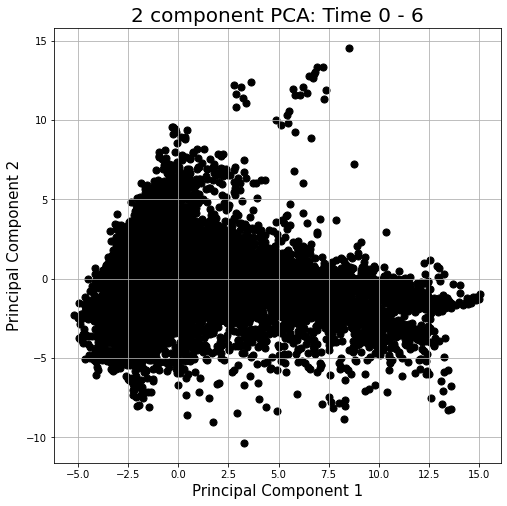

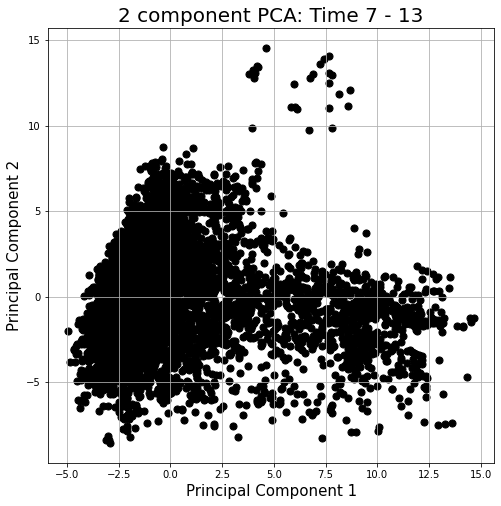

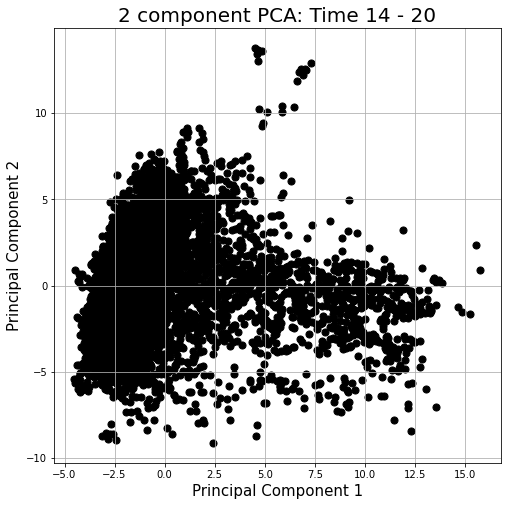

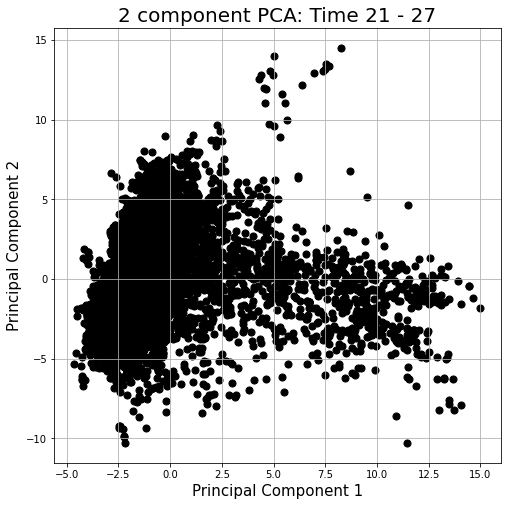

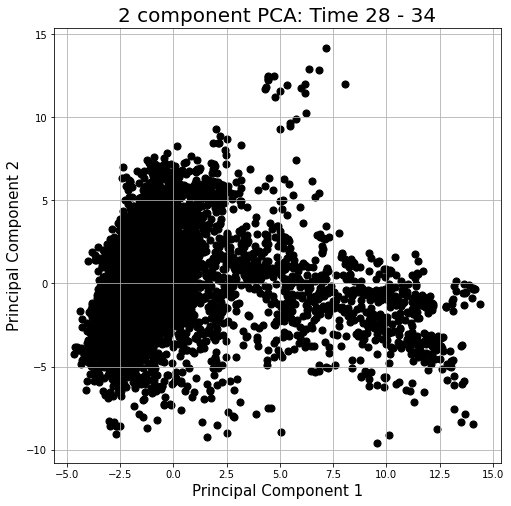

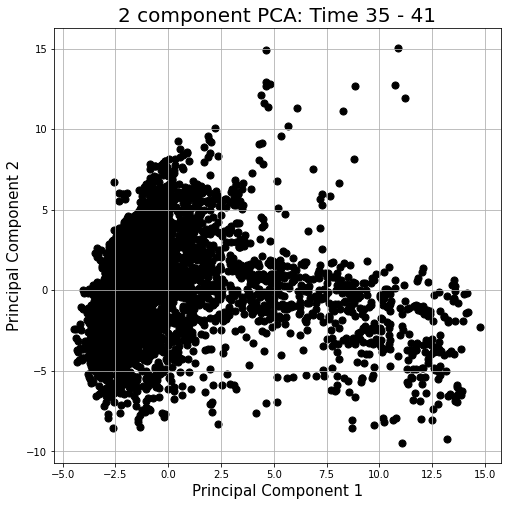

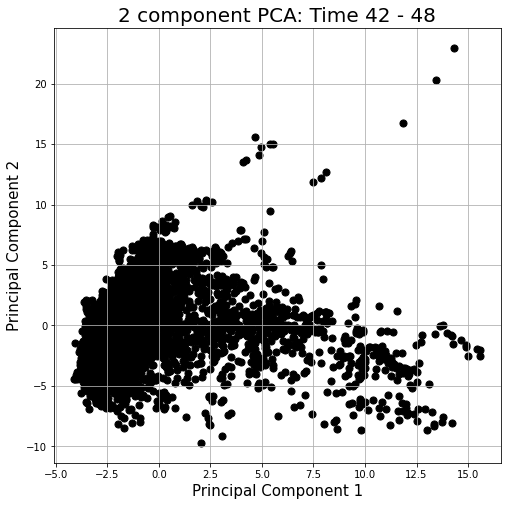

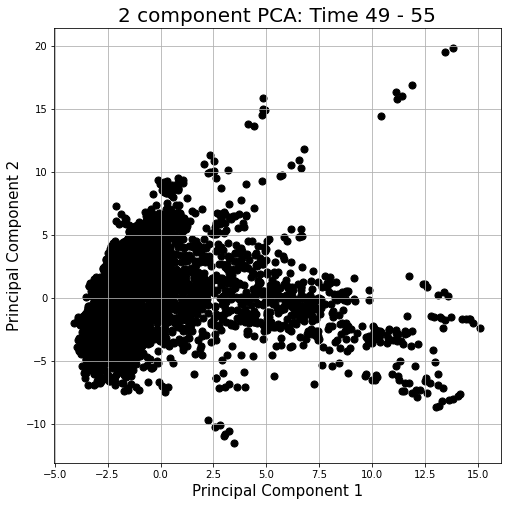

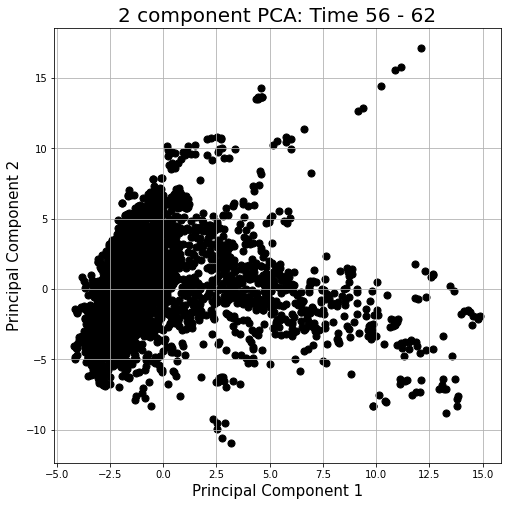

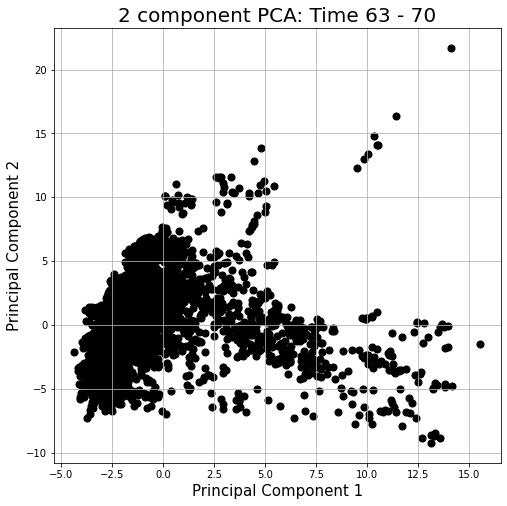

In [10]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        ax.scatter(temp_embeddings_pca_df.loc[indices_to_keep, 'component 1'], temp_embeddings_pca_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()

In [11]:
from sklearn.manifold import TSNE

In [16]:
tsne = TSNE(n_components=2)

def project_embeddings_tsne(temp_embeddings_df):
    neighbors_embeddings = tsne.fit_transform(temp_embeddings_df)
    neighbors_df = pd.DataFrame(data = neighbors_embeddings, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([neighbors_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

KeyError: 'component 1'

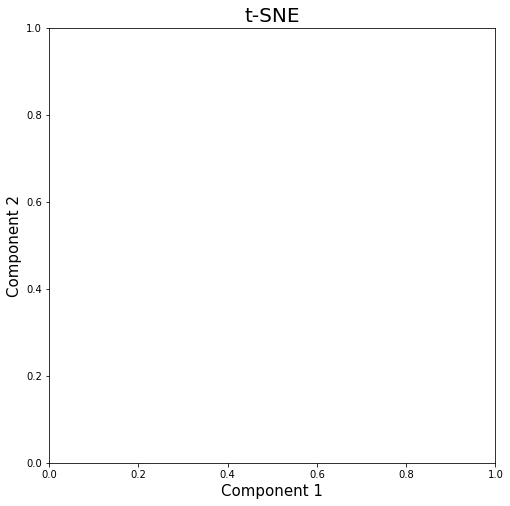

In [17]:
temp_embeddings_df = get_temp_embeddings_df()
temp_embeddings_tsne_df = project_embeddings_tsne(temp_embeddings_df)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df.loc['component 1'], temp_embeddings_tsne_df.loc['component 2'], c = 'black', s = 50)
ax.grid()

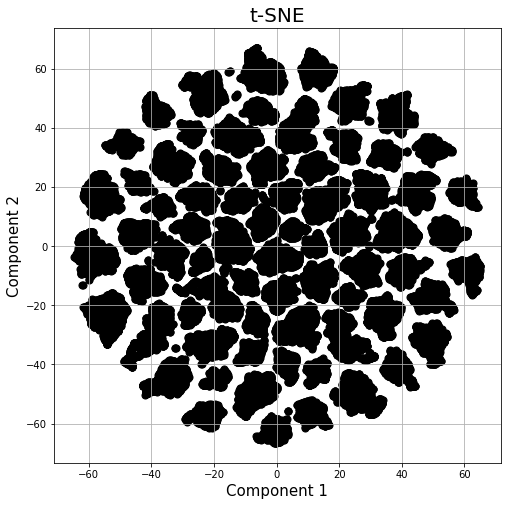

In [20]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df['component 1'], temp_embeddings_tsne_df['component 2'], c = 'black', s = 50)
ax.grid()

In [23]:
time_sects = []
for frame in temp_embeddings_tsne_df['Time']:
    if frame != 70:
        time_sects.append(frame // 7)
    else:
        time_sects.append(9)
temp_embeddings_tsne_df['Section'] = time_sects

In [24]:
temp_embeddings_tsne_df[:5]

component 1  component 2  Time  Section
0    22.376740   -30.025965   0.0      0.0
1   -18.807642   -14.181750   1.0      0.0
2   -36.712296   -31.362238   2.0      0.0
3     9.864654    36.857738   3.0      0.0
4    14.016857    19.143394   4.0      0.0

In [25]:
temp_embeddings_tsne_df[65:73]

component 1  component 2  Time  Section
65    26.254499   -10.914620  30.0      4.0
66   -42.170265    -8.886860  31.0      4.0
67   -35.081097    -5.222844  32.0      4.0
68   -49.301395     2.483174  33.0      4.0
69    12.865305    61.038147  34.0      4.0
70    43.659744    -9.605247  35.0      5.0
71     4.993107   -17.844292  36.0      5.0
72   -20.743692    23.200178  37.0      5.0

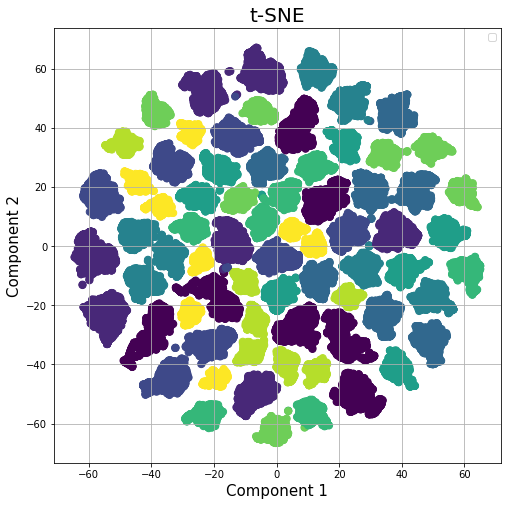

In [28]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df['component 1'], temp_embeddings_tsne_df['component 2'], c = temp_embeddings_tsne_df['Section'], s = 50)
ax.legend()
ax.grid()

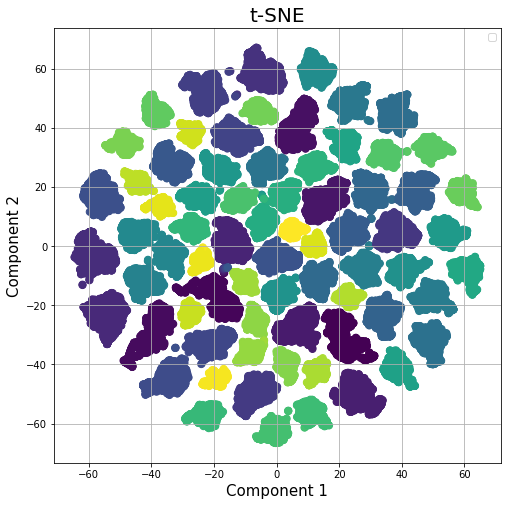

In [29]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df['component 1'], temp_embeddings_tsne_df['component 2'], c = temp_embeddings_tsne_df['Time'], s = 50)
ax.legend()
ax.grid()

In [30]:
temp_embeddings_tsne_df[:100]

component 1  component 2  Time  Section
0     22.376740   -30.025965   0.0      0.0
1    -18.807642   -14.181750   1.0      0.0
2    -36.712296   -31.362238   2.0      0.0
3      9.864654    36.857738   3.0      0.0
4     14.016857    19.143394   4.0      0.0
..          ...          ...   ...      ...
95   -11.844868   -14.050598  60.0      8.0
96    10.404031   -40.817364  61.0      8.0
97    23.074488   -19.594261  62.0      8.0
98   -46.007690    19.562733  63.0      9.0
99   -29.445410   -23.379139  64.0      9.0

[100 rows x 4 columns]

In [32]:
pd.set_option('display.max_rows', None)

In [33]:
temp_embeddings_tsne_df[:100]

component 1  component 2  Time  Section
0     22.376740   -30.025965   0.0      0.0
1    -18.807642   -14.181750   1.0      0.0
2    -36.712296   -31.362238   2.0      0.0
3      9.864654    36.857738   3.0      0.0
4     14.016857    19.143394   4.0      0.0
5      6.701970   -31.858288   5.0      0.0
6     23.613855   -52.916611   6.0      0.0
7    -19.652802     1.047200   7.0      1.0
8    -59.209888   -25.260771   8.0      1.0
9    -63.458134     1.601208   9.0      1.0
10    -9.274850    61.968029  10.0      1.0
11    42.287624     7.529037  11.0      1.0
12    -8.378672   -49.075741  12.0      1.0
13   -19.501017    55.269497  13.0      1.0
14    -9.721286    38.587814  14.0      2.0
15   -20.048853   -35.775589  15.0      2.0
16   -34.339649   -46.546452  16.0      2.0
17   -59.618256    14.485751  17.0      2.0
18     1.081411    -4.473722  18.0      2.0
19   -38.811401    27.449160  19.0      2.0
20    17.865265     4.508068  20.0      2.0
21    42.374619    23.625191  21.0      3.0
22    29.645739   -26.542686  22.0      3.0
23    32.912277    22.776402  23.0      3.0
24     8.821250   -11.143384  24.0      3.0
25    34.641926    47.989563  25.0      3.0
26    51.857418   -33.236267  26.0      3.0
27    -7.680455    25.790722  27.0      3.0
28    22.607635    52.899609  28.0      4.0
29    53.564560   -17.780334  29.0      4.0
30    24.040155    -5.099919  30.0      4.0
31   -45.844093   -15.417543  31.0      4.0
32   -31.073229    -7.948251  32.0      4.0
33   -48.772007     6.997759  33.0      4.0
34    11.470372    65.195305  34.0      4.0
35    21.079510   -23.358297   0.0      0.0
36   -17.691601   -23.923096   1.0      0.0
37   -34.426048   -22.657194   2.0      0.0
38     6.993462    34.813259   3.0      0.0
39    10.381984    13.531857   4.0      0.0
40    11.807471   -25.353750   5.0      0.0
41    22.235519   -47.971664   6.0      0.0
42   -15.450109    -2.316148   7.0      1.0
43   -56.638409   -19.746044   8.0      1.0
44   -58.426529    -7.306659   9.0      1.0
45    -6.471000    54.473064  10.0      1.0
46    34.752617     8.251710  11.0      1.0
47    -8.644495   -45.756466  12.0      1.0
48   -18.399822    49.856880  13.0      1.0
49   -14.586177    40.992664  14.0      2.0
50   -20.352661   -36.957409  15.0      2.0
51   -31.386566   -49.244312  16.0      2.0
52   -56.285561    12.522410  17.0      2.0
53     0.289636    -1.007058  18.0      2.0
54   -35.022972    24.671217  19.0      2.0
55    22.235920     6.881779  20.0      2.0
56    42.455448    18.547611  21.0      3.0
57    35.714573   -27.342274  22.0      3.0
58    26.301952    21.604321  23.0      3.0
59     9.094042   -13.316139  24.0      3.0
60    35.645523    45.160225  25.0      3.0
61    52.704948   -32.483044  26.0      3.0
62    -4.344718    29.444927  27.0      3.0
63    25.928947    49.158520  28.0      4.0
64    48.462631   -19.797722  29.0      4.0
65    26.254499   -10.914620  30.0      4.0
66   -42.170265    -8.886860  31.0      4.0
67   -35.081097    -5.222844  32.0      4.0
68   -49.301395     2.483174  33.0      4.0
69    12.865305    61.038147  34.0      4.0
70    43.659744    -9.605247  35.0      5.0
71     4.993107   -17.844292  36.0      5.0
72   -20.743692    23.200178  37.0      5.0
73    56.897667     6.951606  38.0      5.0
74   -25.814081    20.738144  39.0      5.0
75    40.702778   -42.902473  40.0      5.0
76    19.244413    32.509537  41.0      5.0
77    57.976585   -10.939051  42.0      6.0
78    -1.452906     5.813050  43.0      6.0
79     5.491574    18.141644  44.0      6.0
80    14.526681    24.711950  45.0      6.0
81   -29.268026     4.070616  46.0      6.0
82   -23.980585   -59.987492  47.0      6.0
83     8.664398   -58.620033  48.0      6.0
84    -2.507715   -59.121765  49.0      7.0
85    -7.900866    16.058104  50.0      7.0
86    36.604275    27.494431  51.0      7.0
87    48.550365    29.886665  52.0      7.0
88   -36.204708    47.006954  53.0      7.0
89    61.686749    20.989752  54.0      7.0


[(0.0, 0.0, 0.0), (0.1, 0.1, 0.1), (0.2, 0.2, 0.2), (0.30000000000000004, 0.30000000000000004, 0.30000000000000004), (0.4, 0.4, 0.4), (0.5, 0.5, 0.5), (0.6000000000000001, 0.6000000000000001, 0.6000000000000001), (0.7000000000000001, 0.7000000000000001, 0.7000000000000001), (0.8, 0.8, 0.8), (0.9, 0.9, 0.9)]


ValueError: RGBA values should be within 0-1 range

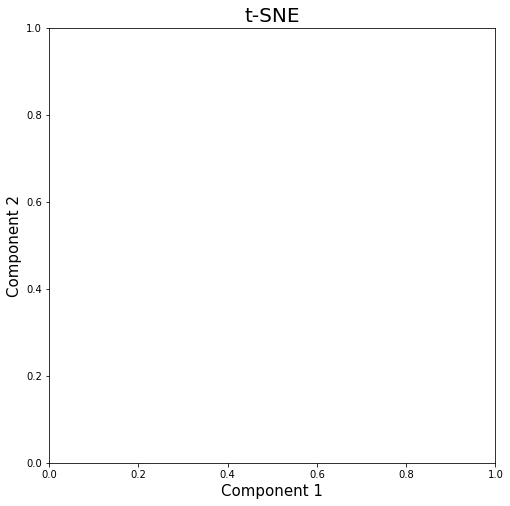

In [35]:
colors = []
for time in temp_embeddings_tsne_df['Time']:
    colors.append((0.1 * time, 0.1 * time, 0.1 * time))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df['component 1'], temp_embeddings_tsne_df['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

In [36]:
for color in colors:
    for val in color:
        if val < 0 or val > 1:
            print(color)

(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2

(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 

(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3

(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001

(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3

(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(6.0, 6.0, 6.0

(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.20000000

(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005

(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4

(2.7, 2.7, 2.7)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.7, 3.7, 3

(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.100000000000

(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.20000000

(6.0, 6.0, 6.0)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0

(3.5, 3.5, 3.5)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.600000000000000

(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.100000000000

(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.5, 6.5, 6.5

(2.6, 2.6, 2.6)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.6, 3.6, 3

(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3

(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001

(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.70000000000

(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 

(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1

(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 

(4.4, 4.4, 4.4)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4

(6.9, 6.9, 6.9)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.90

(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1

(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.3000000000000003, 2.3000000000000003, 2.30000000000

(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.1, 2.1, 2

(3.1, 3.1, 3.1)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.100000000

(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.7, 2.7

(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(7.0, 7.0, 7.0)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000

(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2

(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.800000000000001, 4.800000000000001, 4.800000000000001)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(4.9, 4.9, 4.9)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.0, 5.0, 5.0)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.7, 5.7, 5.7

(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3.6)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.1000000000000005, 4.10000

(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 

(7.0, 7.0, 7.0)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.8, 1.8, 1.8)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(2.0, 2.0, 2

(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.7, 6.7, 6.7)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.800000000000001, 6.800000000000001, 6.800000000000001)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9)
(6.9, 6.9, 6.9

(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0

(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(2.9000000000000004, 2.9000000000000004, 2.9000000000000004)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.0, 3.0, 3.0)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.1, 3.1, 3.1)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.2, 3.2, 3.2)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.3000000000000003, 3.3000000000000003, 3.3000000000000003)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.4000000000000004, 3.4000000000000004, 3.4000000000000004)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.5, 3.5, 3.5)
(3.6, 3.6, 3.6)
(3.6, 3.6, 3

(4.0, 4.0, 4.0)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.1, 1.1, 1.1)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.2000000000000002, 1.2000000000000002, 1.2000000000000002)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.3, 1.3, 1.3)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.4000000000000001, 1.4000000000000001, 1.4000000000000001)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.5, 1.5, 1.5)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.6, 1.6, 1.6)
(1.7000000000000002, 1.7000000000000002, 1.7000000000000002)
(1.7000000000000002, 1.700000000000000

(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005

(5.1000000000000005, 5.1000000000000005, 5.1000000000000005)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.2, 5.2, 5.2)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.300000000000001, 5.300000000000001, 5.300000000000001)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.4, 5.4, 5.4)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.5, 5.5, 5.5)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.6000000000000005, 5.6000000000000005, 5.6000000000000005)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005

(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.7, 5.7, 5.7)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.800000000000001, 5.800000000000001, 5.800000000000001)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(5.9, 5.9, 5.9)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.0, 6.0, 6.0)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.1000000000000005, 6.1000000000000005, 6.1000000000000005)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.2, 6.2, 6.2)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.300000000000001, 6.300000000000001, 6.300000000000001)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.4, 6.4, 6.4)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.5, 6.5, 6.5)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005)
(6.6000000000000005, 6.6000000000000005, 6.6000000000000005

(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.7, 4.7, 4.7)
(4.800000000000001, 4.800000000000001, 4.

(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.7, 3.7, 3.7)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.8000000000000003, 3.8000000000000003, 3.8000000000000003)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(3.9000000000000004, 3.9000000000000004, 3.9000000000000004)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.0, 4.0, 4.0)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.1000000000000005, 4.1000000000000005, 4.1000000000000005)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.2, 4.2, 4.2)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.3, 4.3, 4.3)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.4, 4.4, 4.4)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.5, 4.5, 4.5)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 4.6000000000000005)
(4.6000000000000005, 4.6000000000000005, 

(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 

(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(1.9000000000000001, 1.9000000000000001, 1.9000000000000001)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.0, 2.0, 2.0)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.1, 2.1, 2.1)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.2, 2.2, 2.2)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.3000000000000003, 2.3000000000000003, 2.3000000000000003)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.4000000000000004, 2.4000000000000004, 2.4000000000000004)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.5, 2.5, 2.5)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.6, 2.6, 2.6)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.7, 2.7, 2.7)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 2.8000000000000003)
(2.8000000000000003, 2.8000000000000003, 

KeyboardInterrupt: 

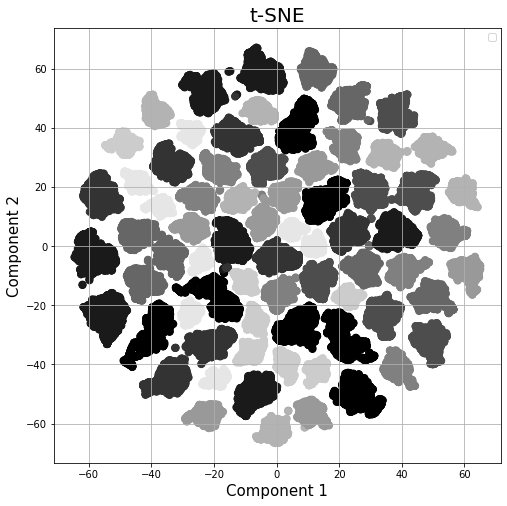

In [37]:
colors = []
for time_sect in temp_embeddings_tsne_df['Section']:
    colors.append((0.1 * time_sect, 0.1 * time_sect, 0.1 * time_sect))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df['component 1'], temp_embeddings_tsne_df['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

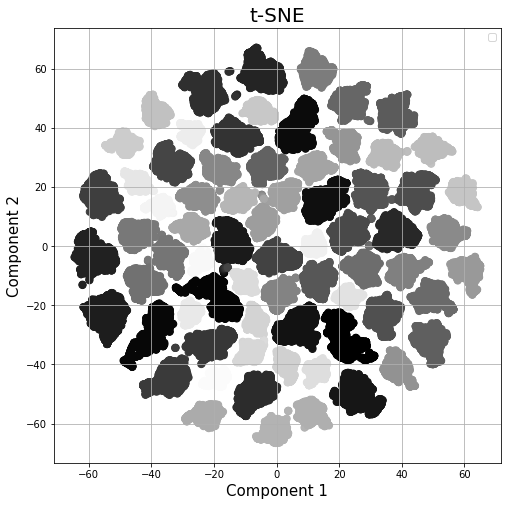

In [38]:
colors = []
for time in temp_embeddings_tsne_df['Time']:
    colors.append((time / 70, time / 70, time / 70))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df['component 1'], temp_embeddings_tsne_df['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

In [39]:
for i in range(20):
    print(colors[i])

(0.0, 0.0, 0.0)
(0.014285714285714285, 0.014285714285714285, 0.014285714285714285)
(0.02857142857142857, 0.02857142857142857, 0.02857142857142857)
(0.04285714285714286, 0.04285714285714286, 0.04285714285714286)
(0.05714285714285714, 0.05714285714285714, 0.05714285714285714)
(0.07142857142857142, 0.07142857142857142, 0.07142857142857142)
(0.08571428571428572, 0.08571428571428572, 0.08571428571428572)
(0.1, 0.1, 0.1)
(0.11428571428571428, 0.11428571428571428, 0.11428571428571428)
(0.12857142857142856, 0.12857142857142856, 0.12857142857142856)
(0.14285714285714285, 0.14285714285714285, 0.14285714285714285)
(0.15714285714285714, 0.15714285714285714, 0.15714285714285714)
(0.17142857142857143, 0.17142857142857143, 0.17142857142857143)
(0.18571428571428572, 0.18571428571428572, 0.18571428571428572)
(0.2, 0.2, 0.2)
(0.21428571428571427, 0.21428571428571427, 0.21428571428571427)
(0.22857142857142856, 0.22857142857142856, 0.22857142857142856)
(0.24285714285714285, 0.24285714285714285, 0.24285714

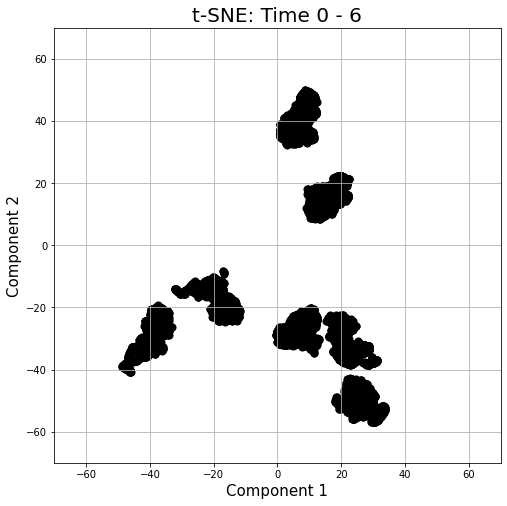

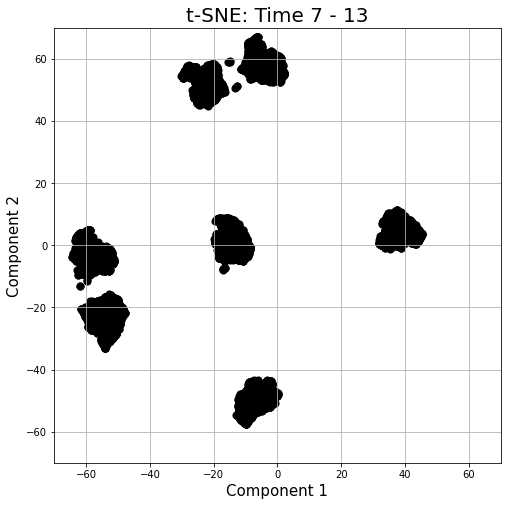

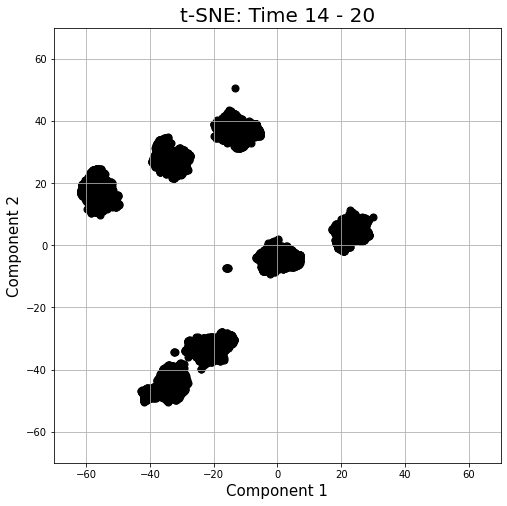

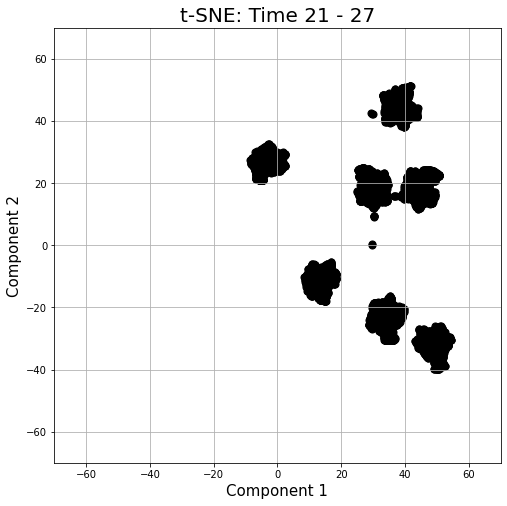

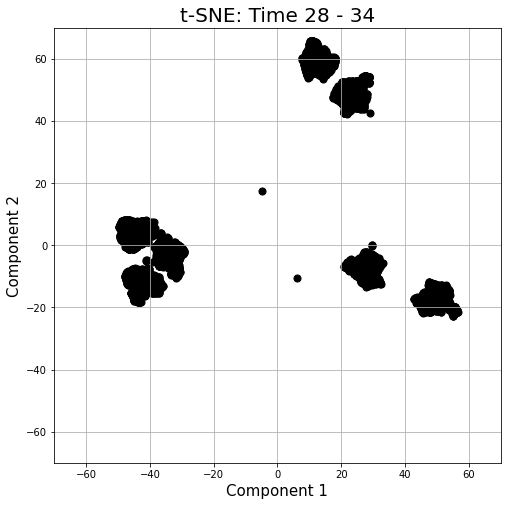

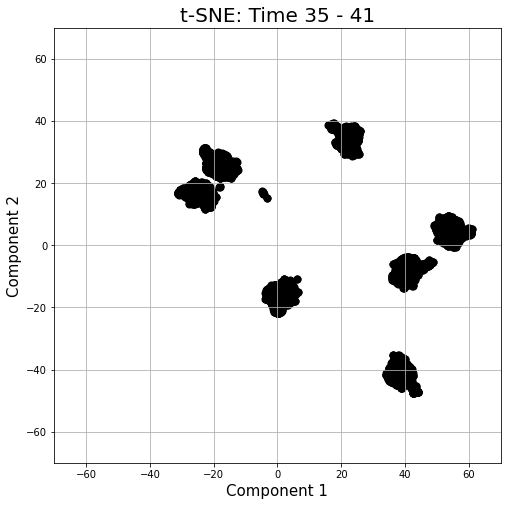

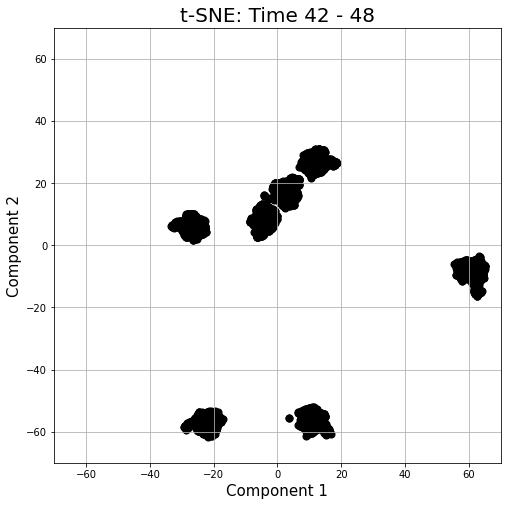

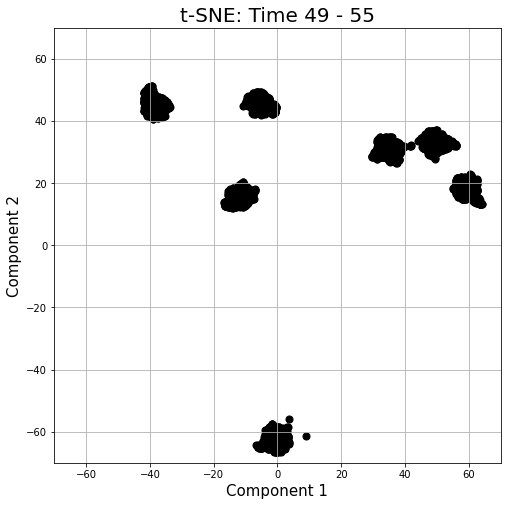

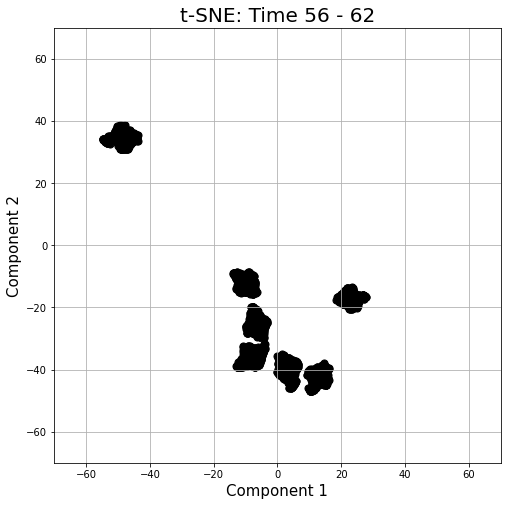

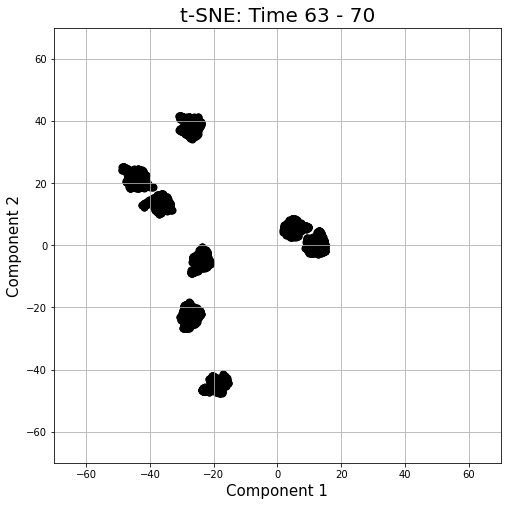

In [44]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title('t-SNE: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    plt.xlim(-70, 70)
    plt.ylim(-70, 70)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
        ax.scatter(temp_embeddings_tsne_df.loc[indices_to_keep, 'component 1'], temp_embeddings_tsne_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


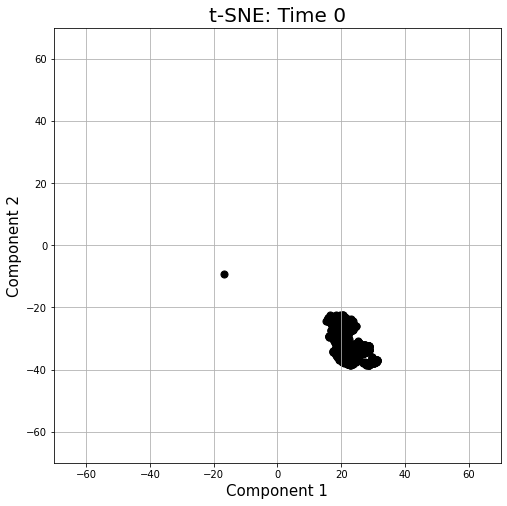

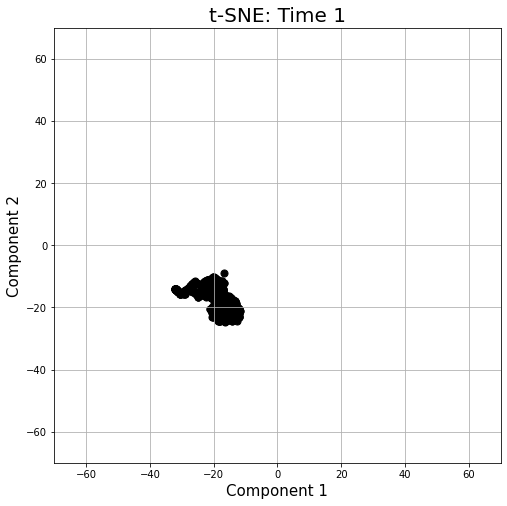

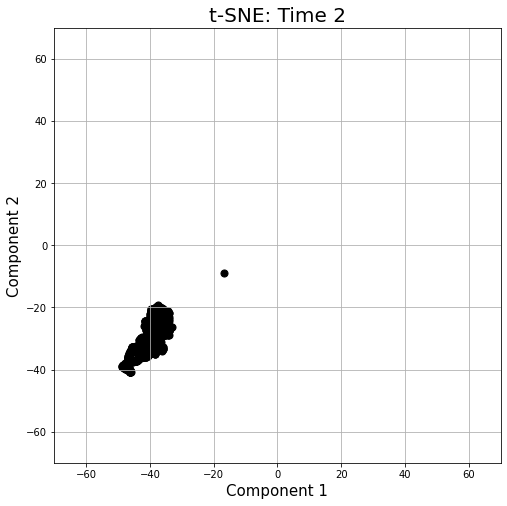

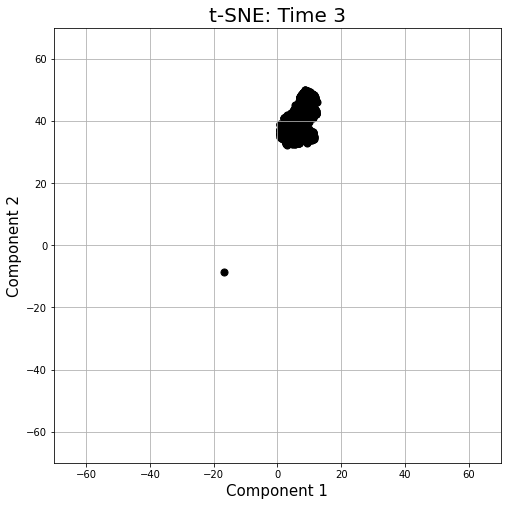

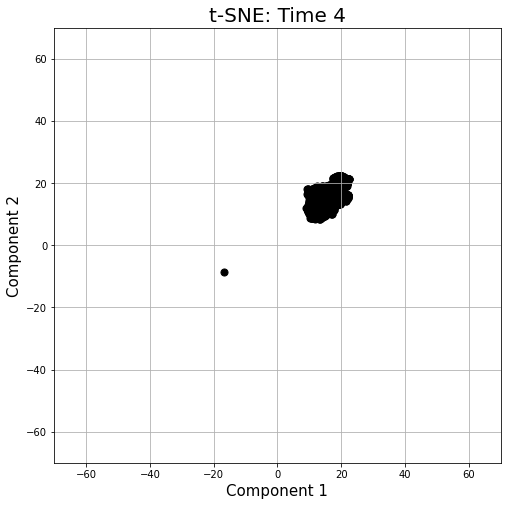

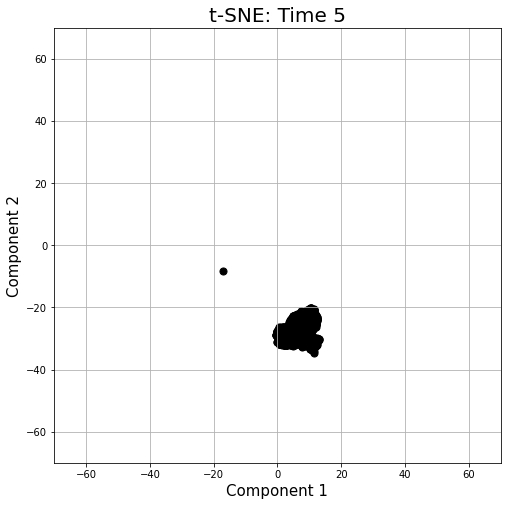

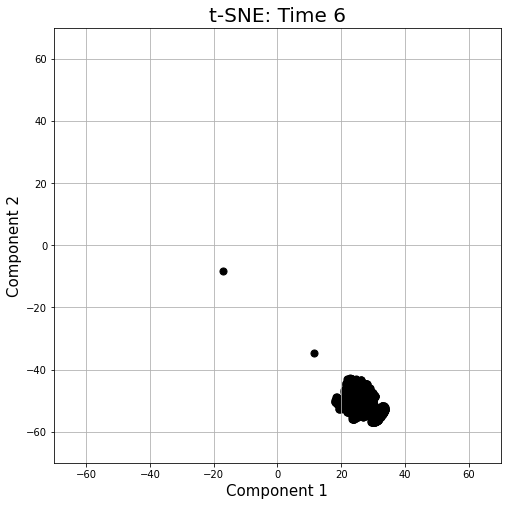

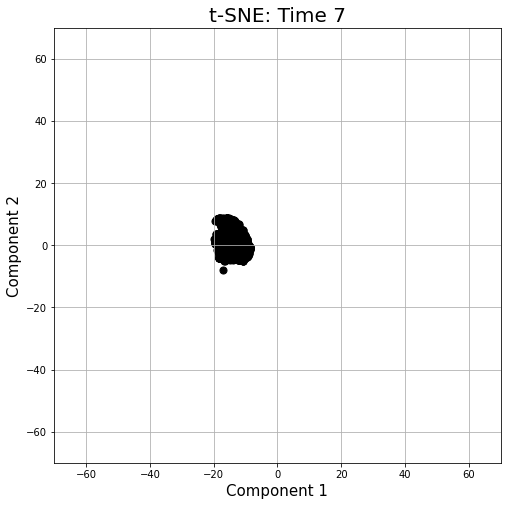

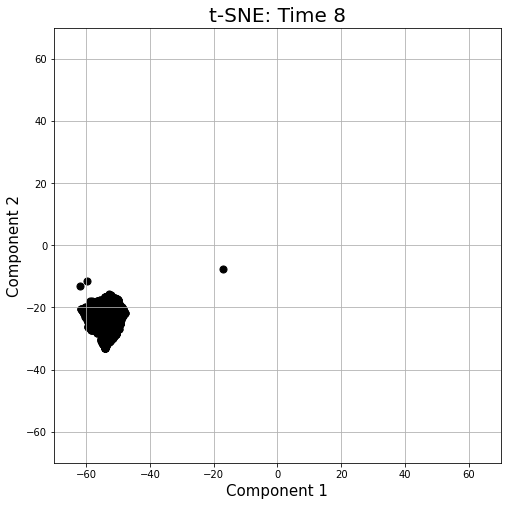

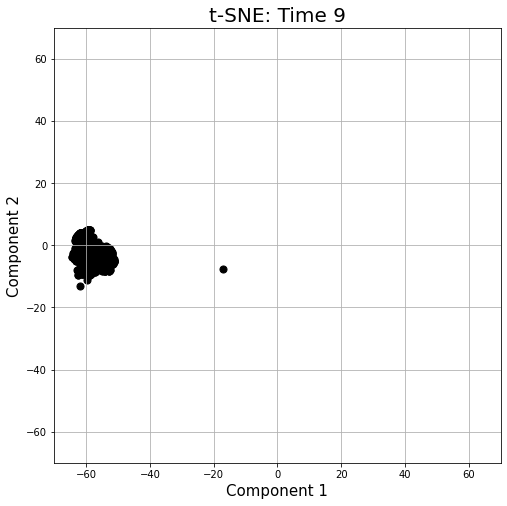

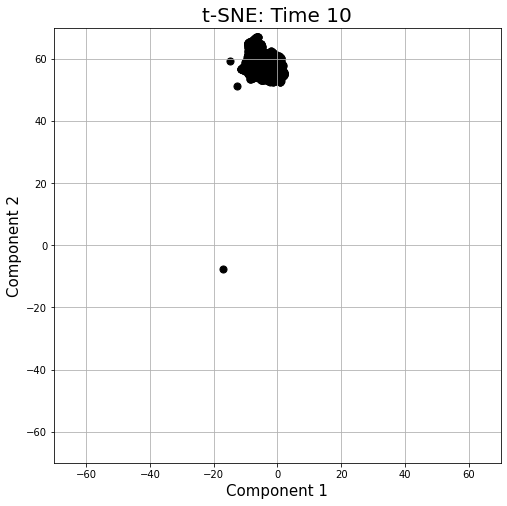

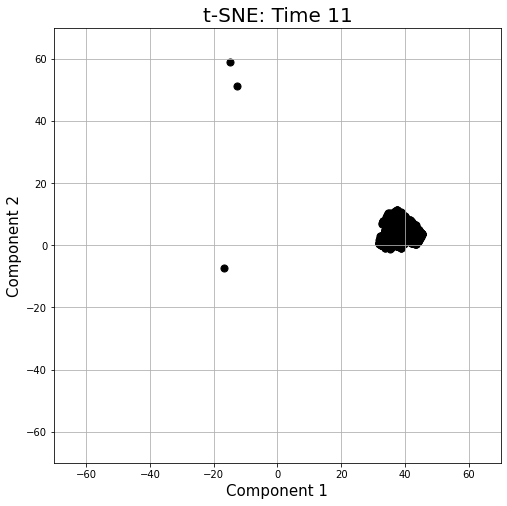

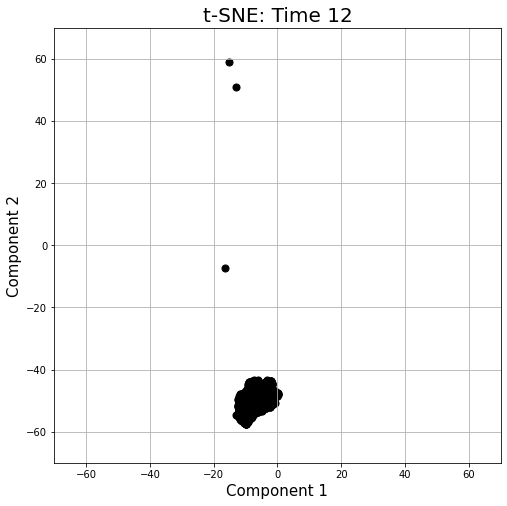

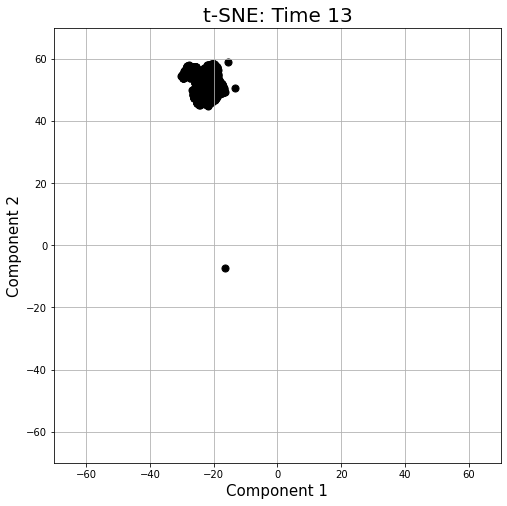

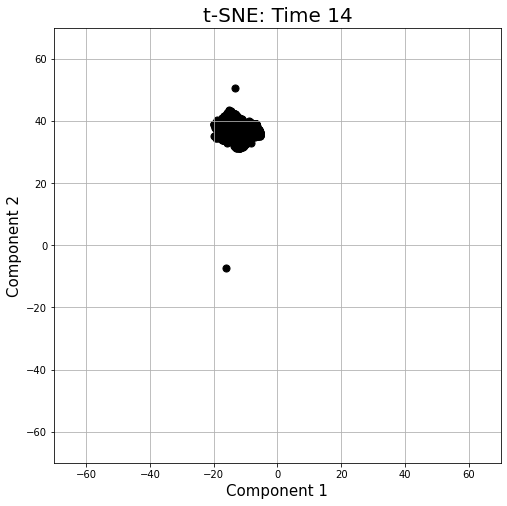

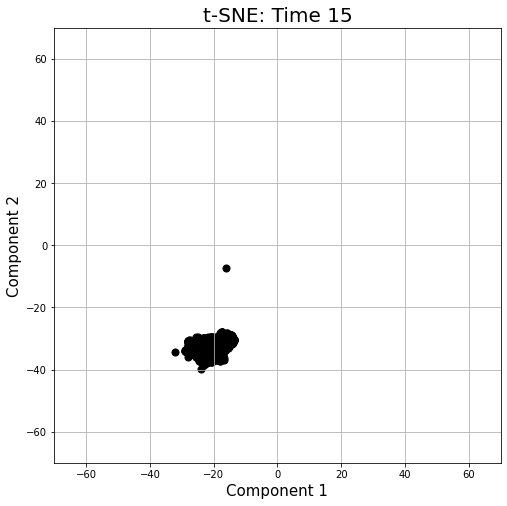

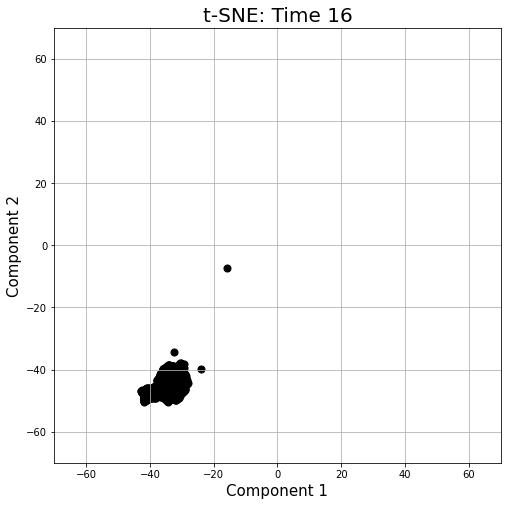

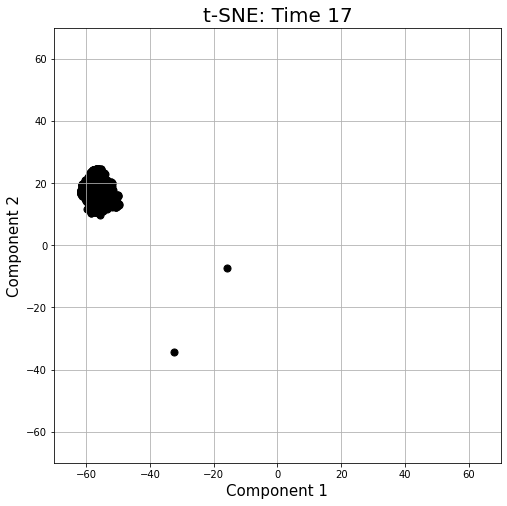

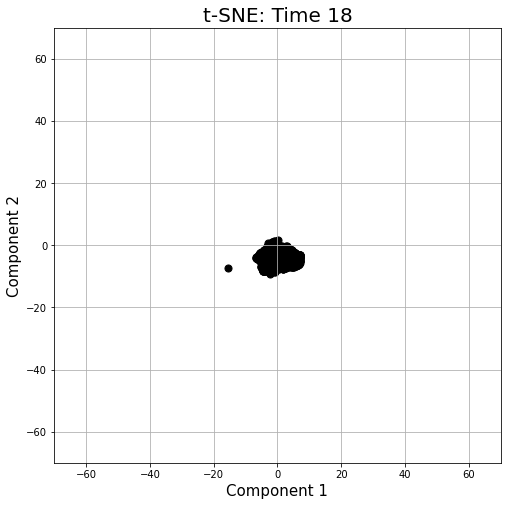

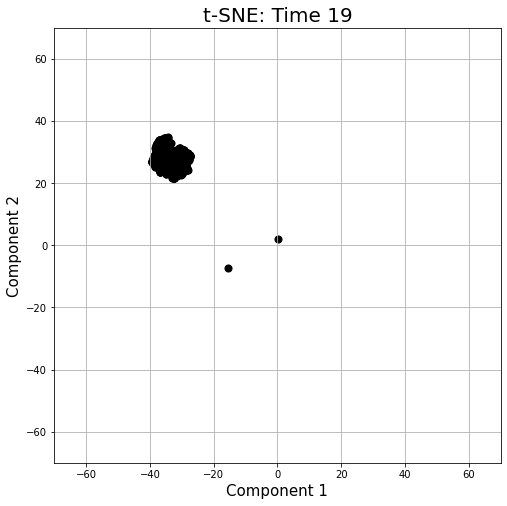

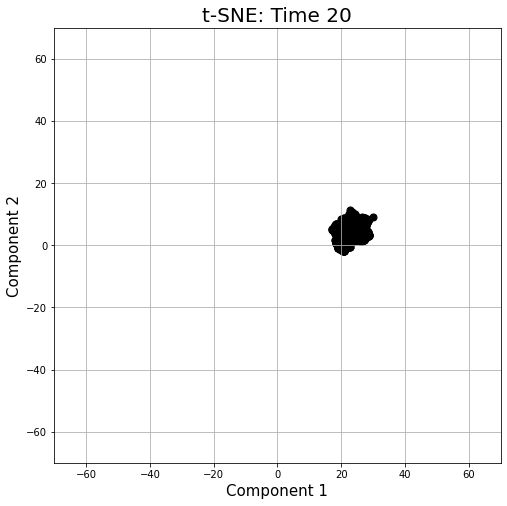

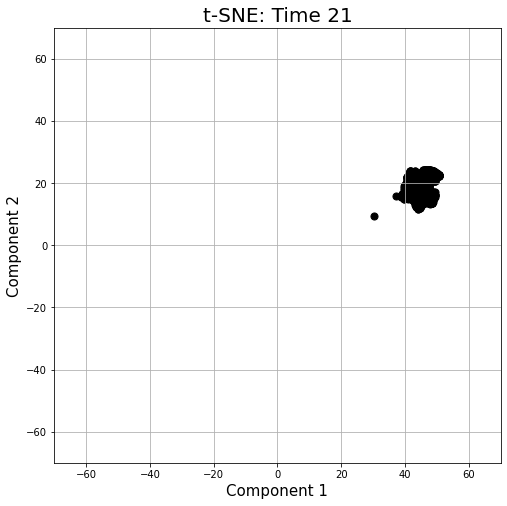

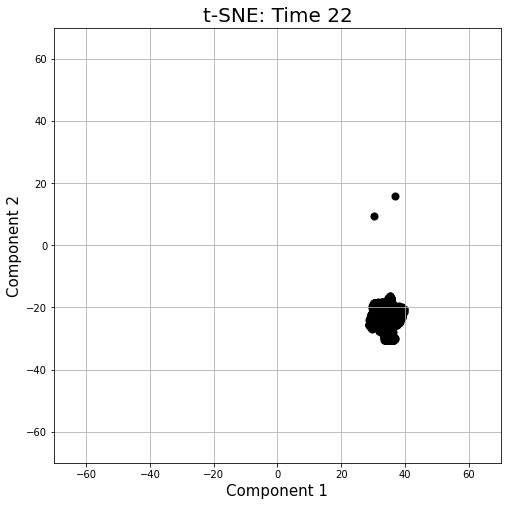

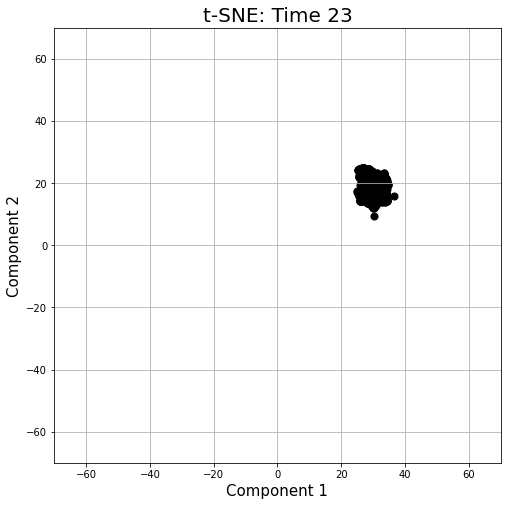

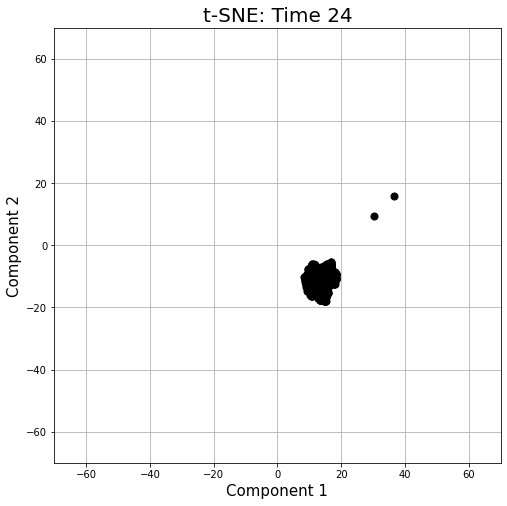

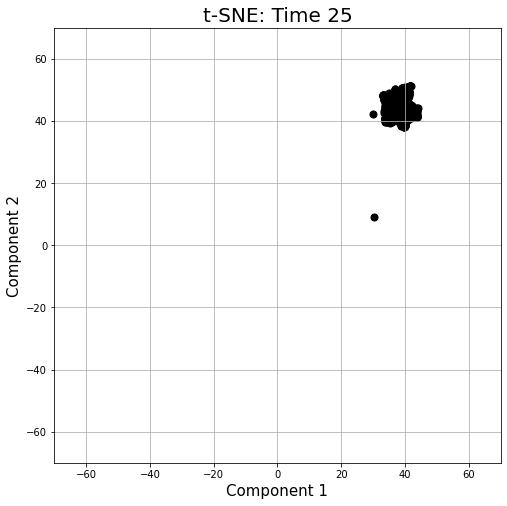

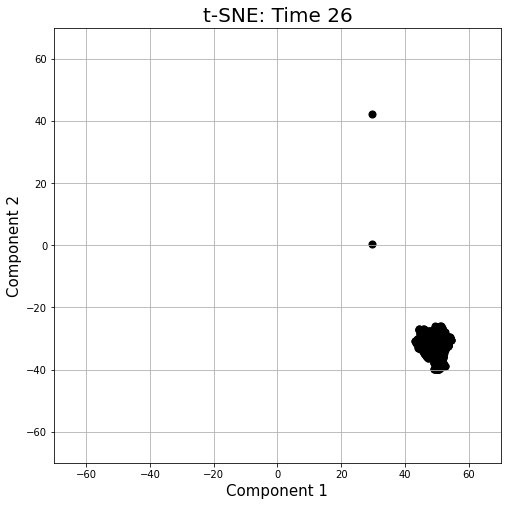

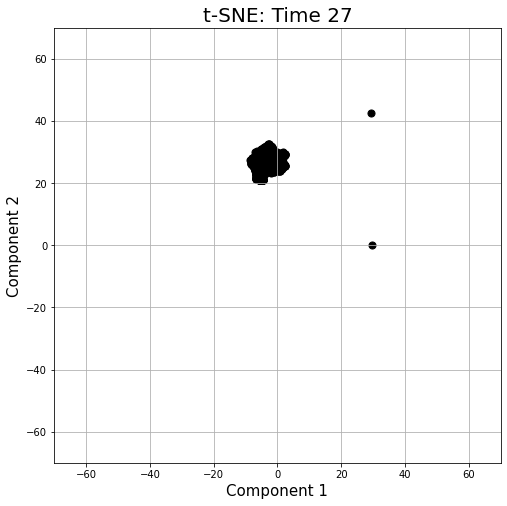

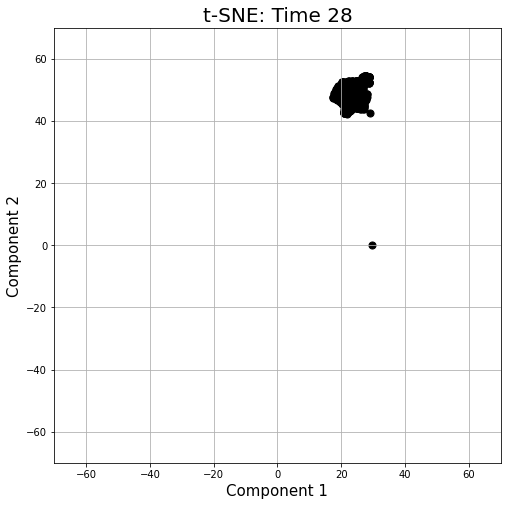

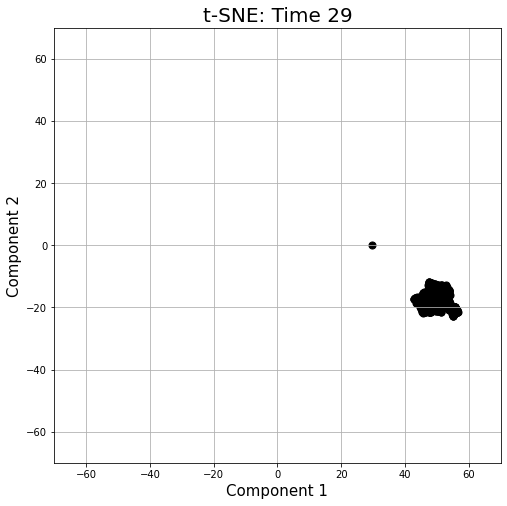

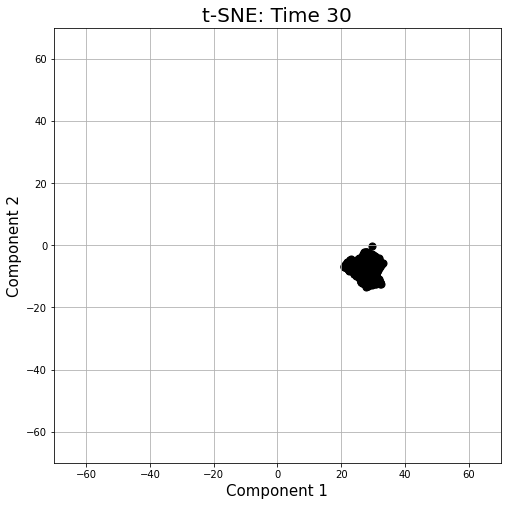

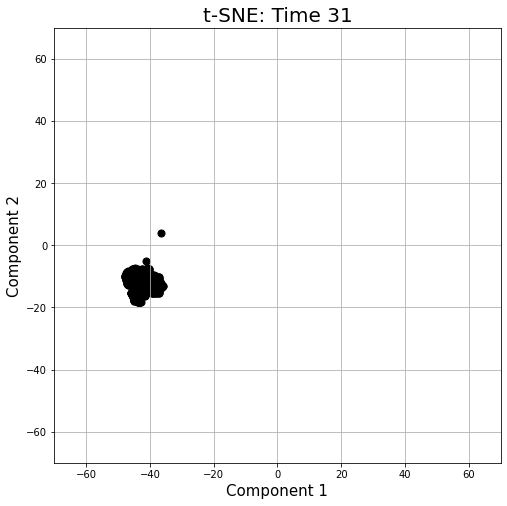

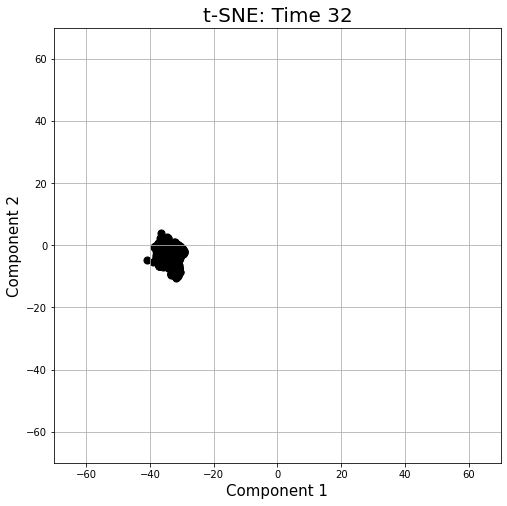

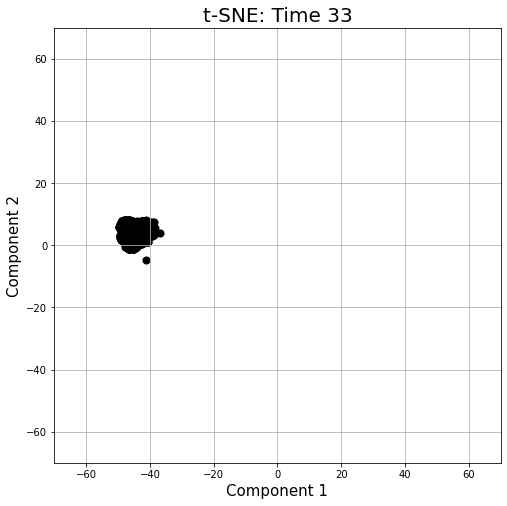

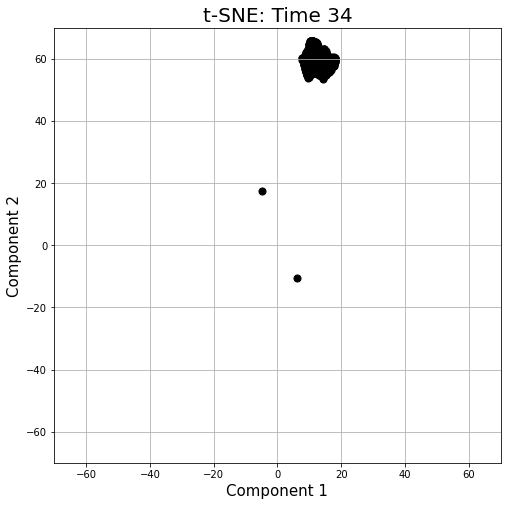

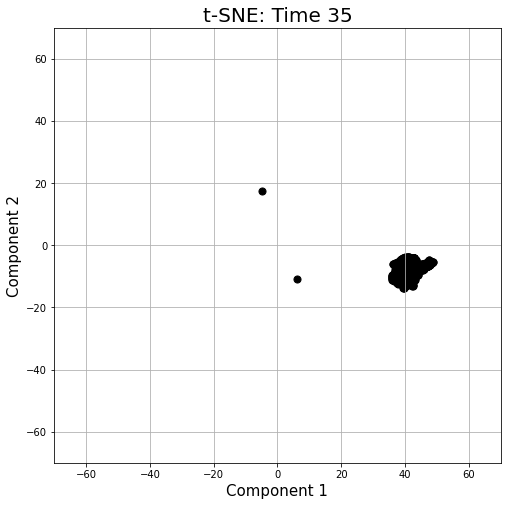

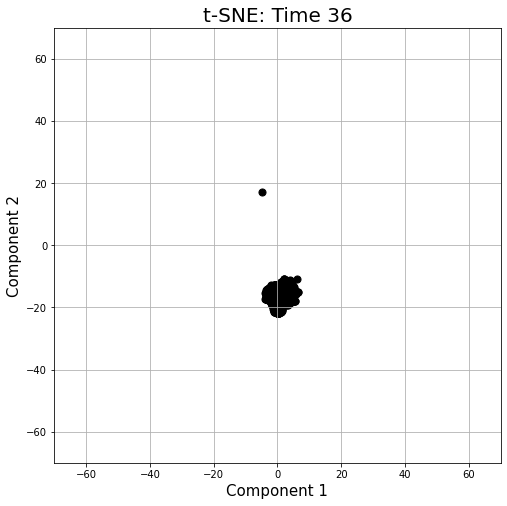

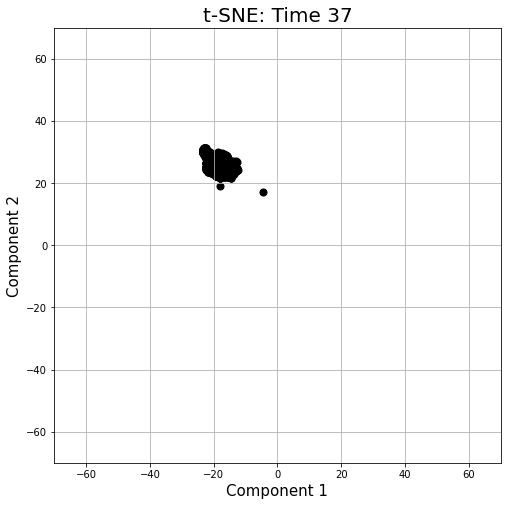

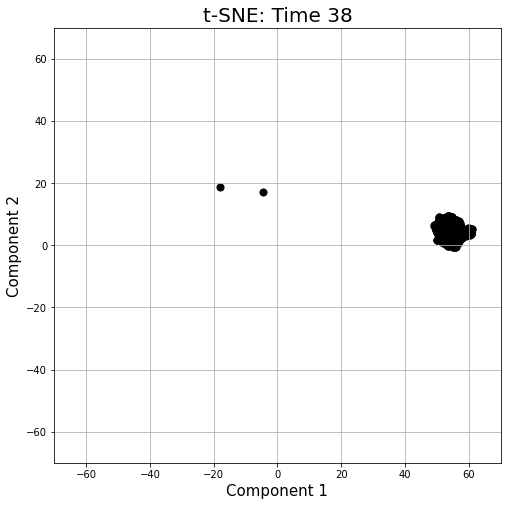

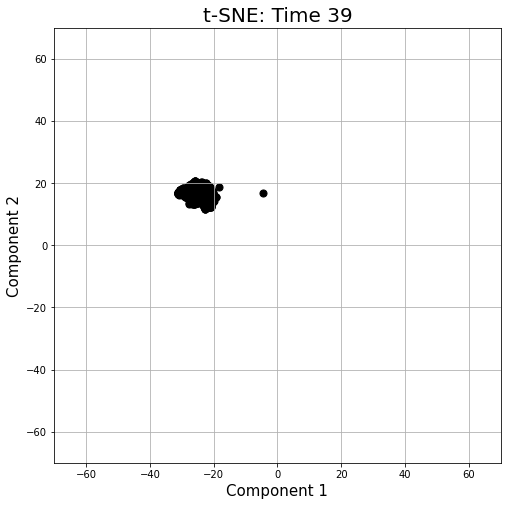

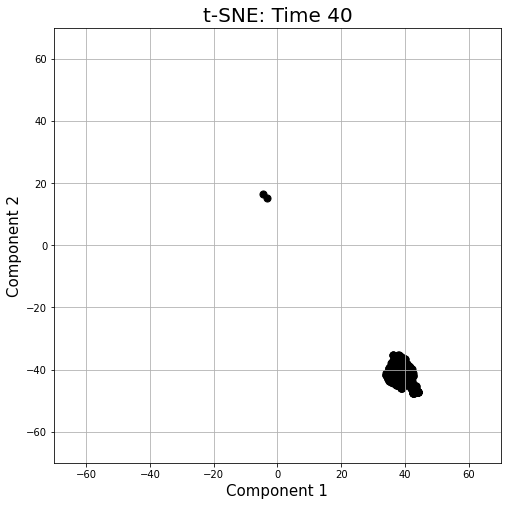

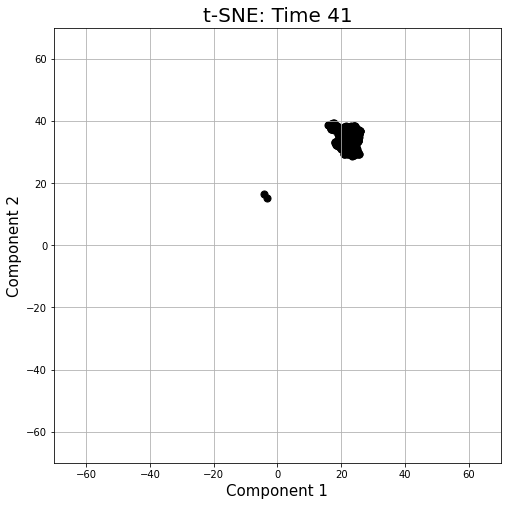

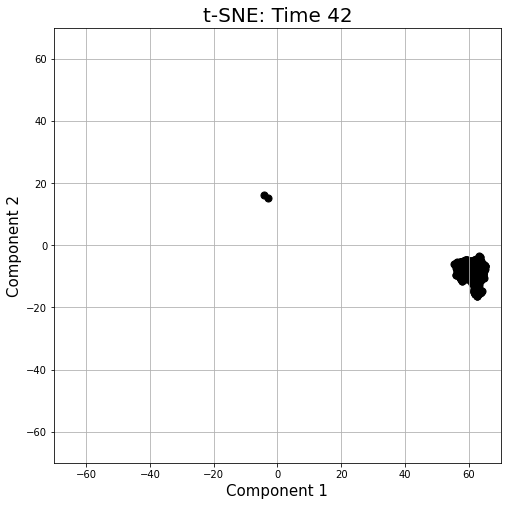

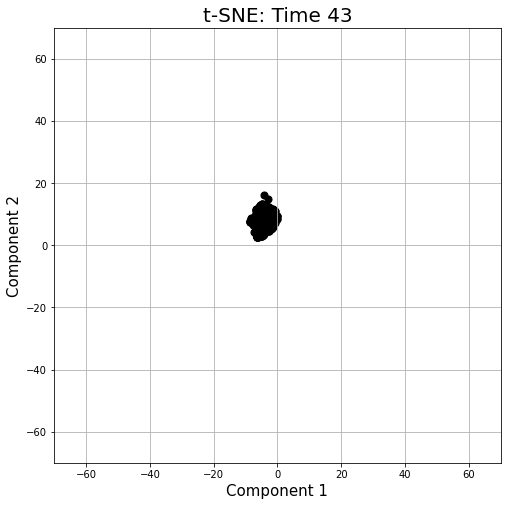

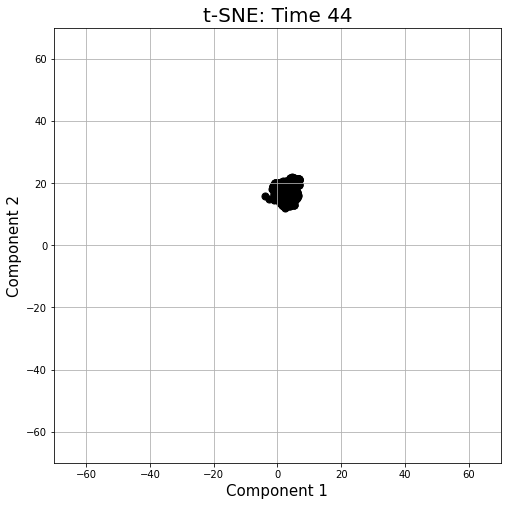

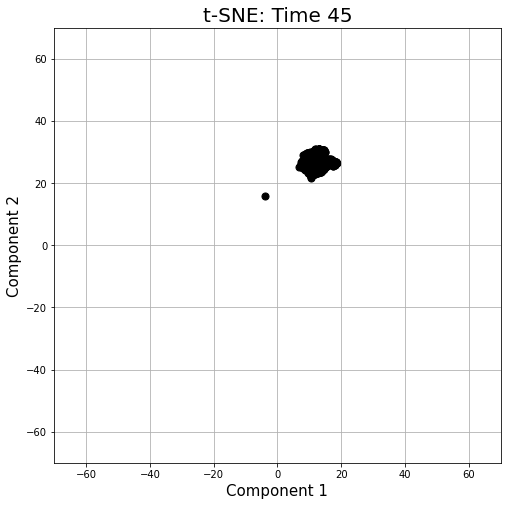

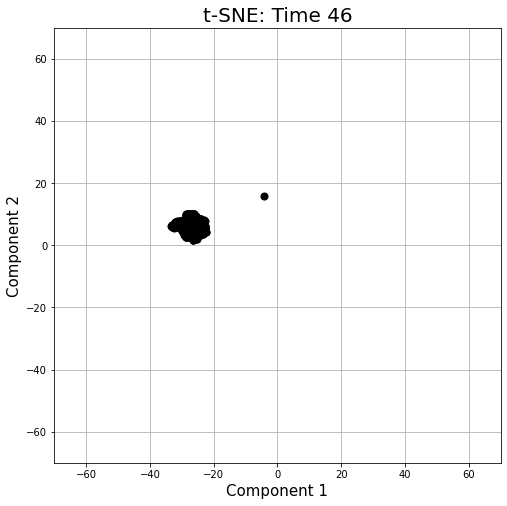

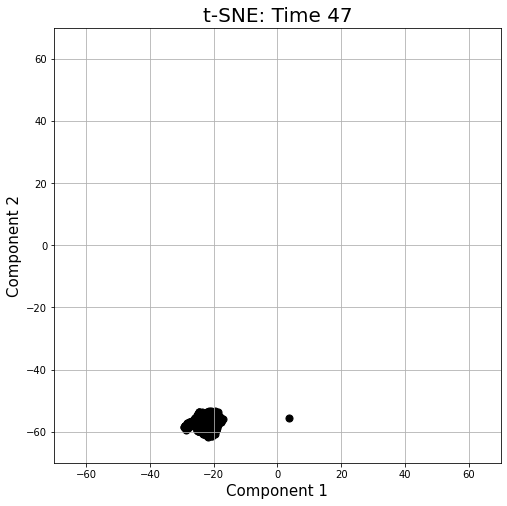

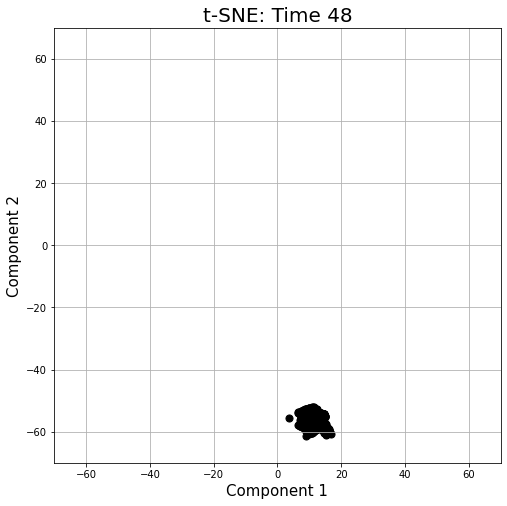

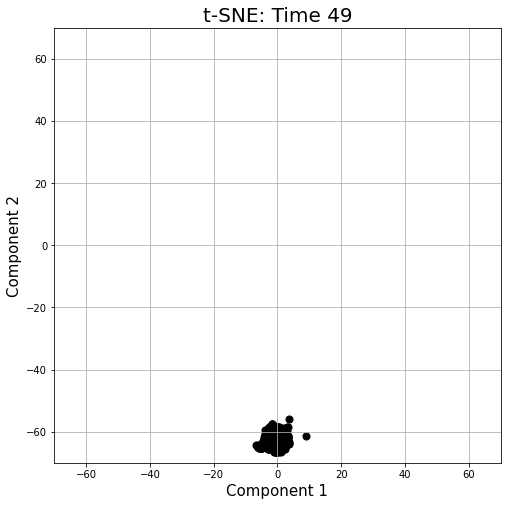

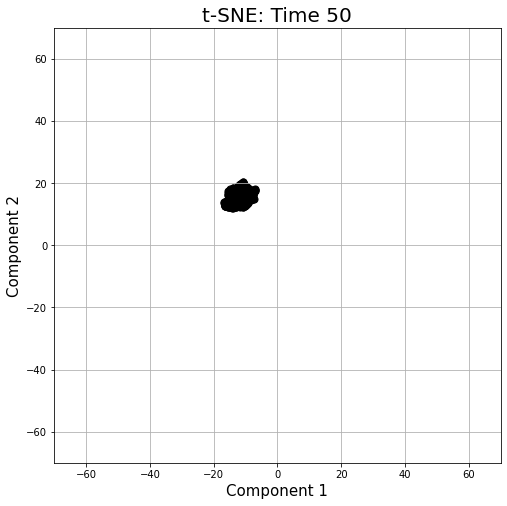

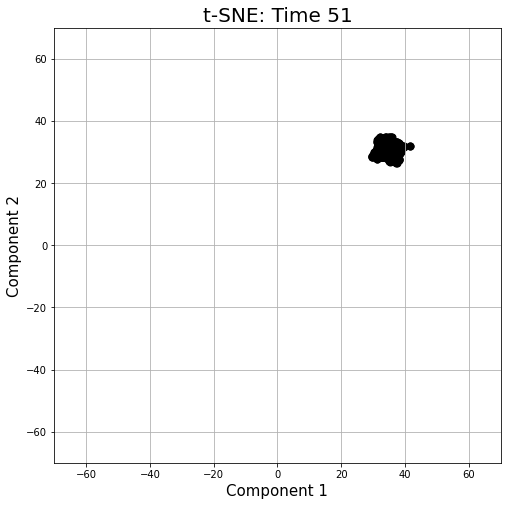

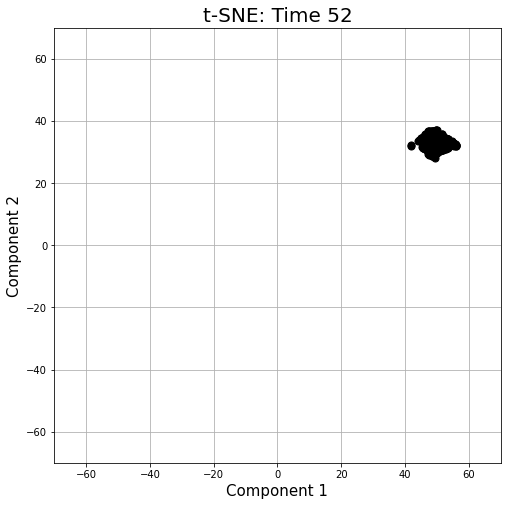

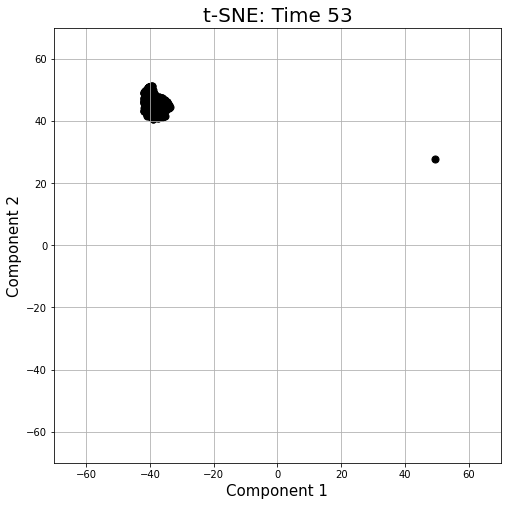

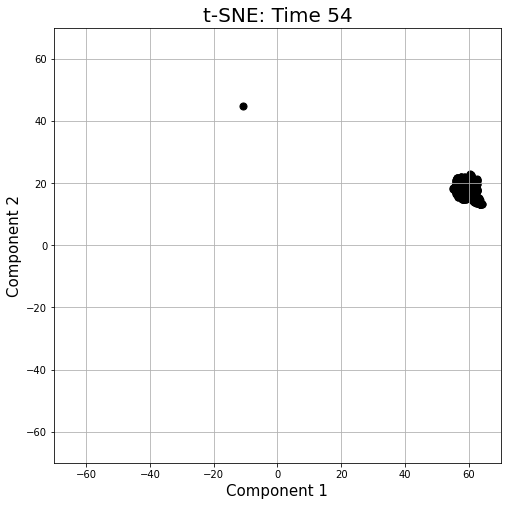

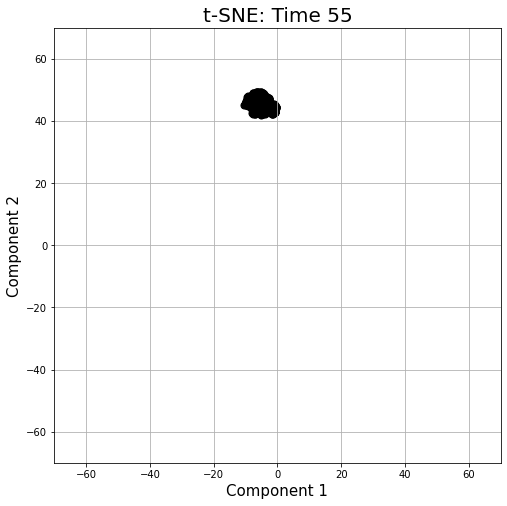

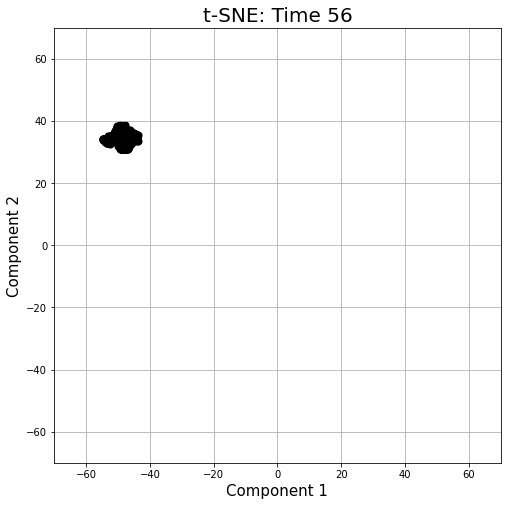

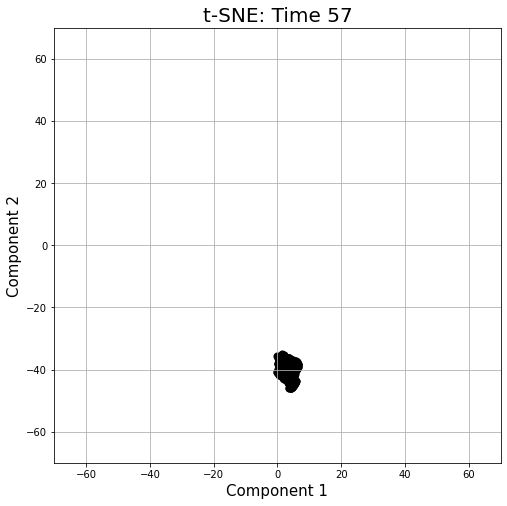

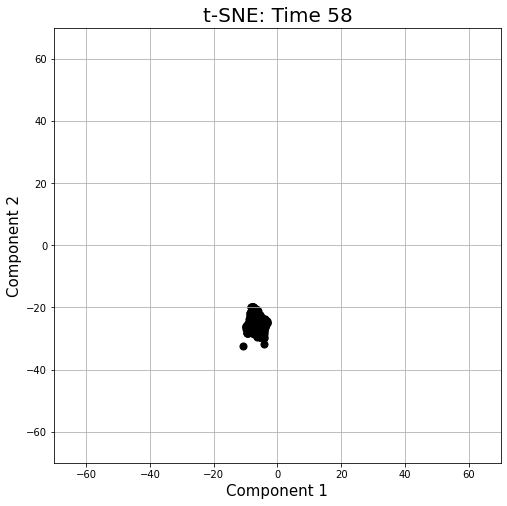

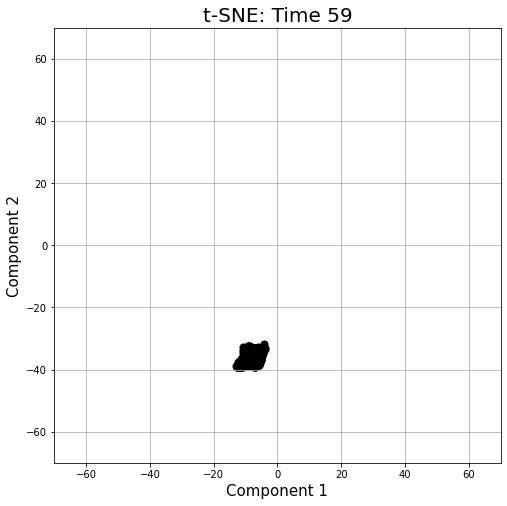

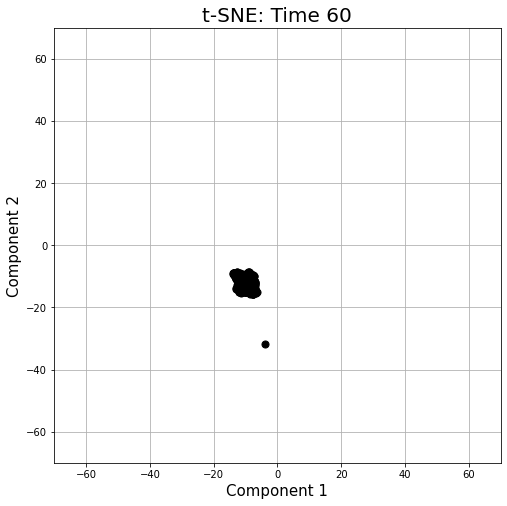

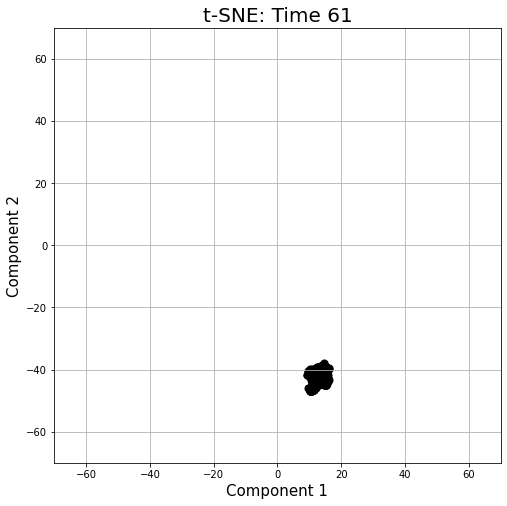

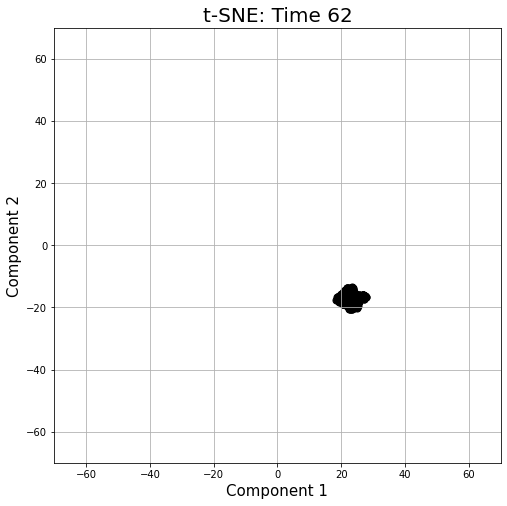

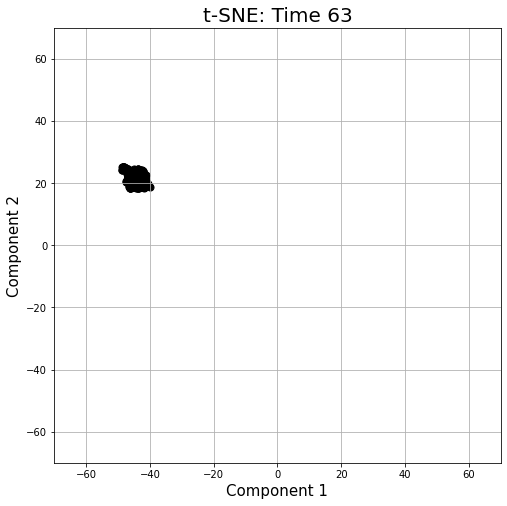

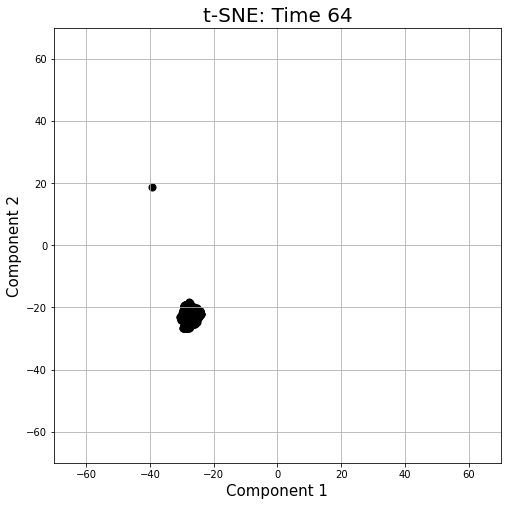

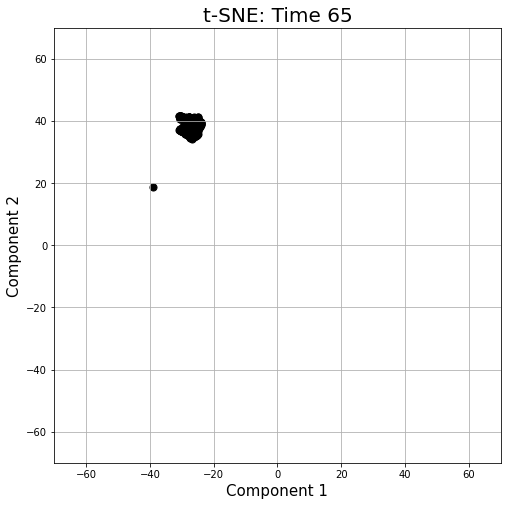

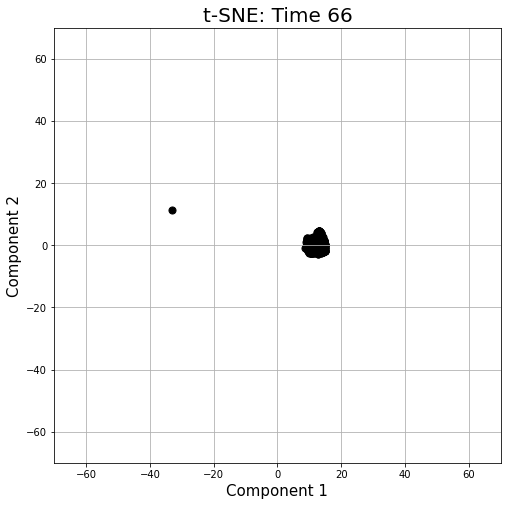

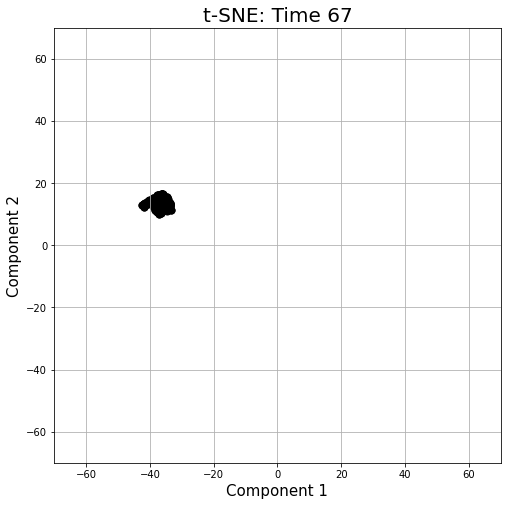

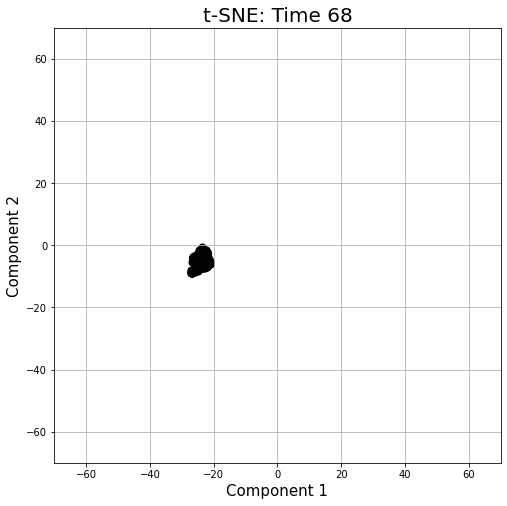

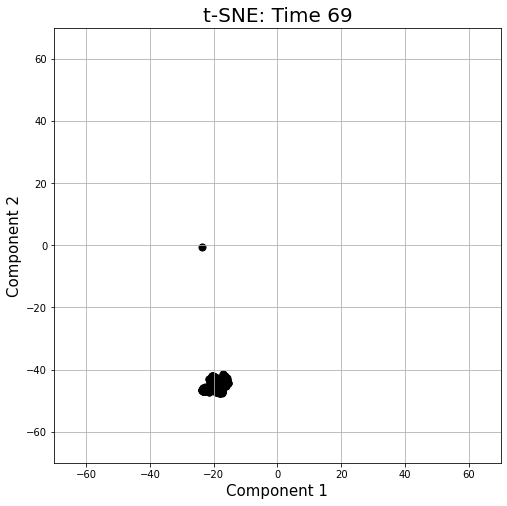

In [45]:
for time in range(70):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title('t-SNE: Time ' + str(time), fontsize = 20)
    plt.xlim(-70, 70)
    plt.ylim(-70, 70)
    indices_to_keep = (temp_embeddings_pca_df['Time'] == time)
    ax.scatter(temp_embeddings_tsne_df.loc[indices_to_keep, 'component 1'], temp_embeddings_tsne_df.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()

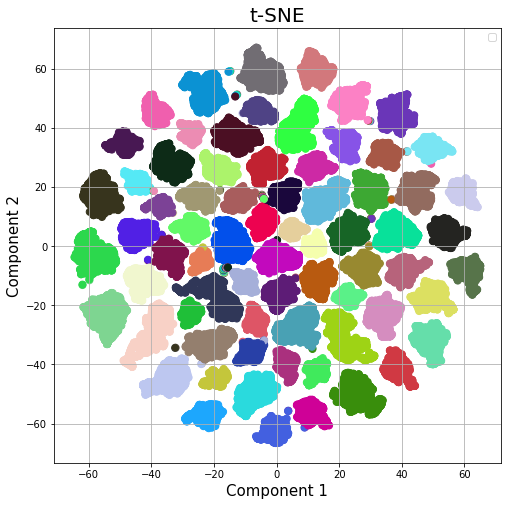

In [53]:
from random import randint

def get_rand_colors(num_colors):
    colors = {k: [] for k in 'rgb'} 
    for i in range(num_colors):
        temp = {k: randint(0, 255) for k in 'rgb'} 
        for k in temp: 
            while 1: 
                c = temp[k]
                # ensure colors are at least 1 apart in each of R, G, and B values
                t = set(j for j in range(c-1, c+1) if 0 <= j <= 255) 
                if t.intersection(colors[k]): 
                    temp[k] = randint(0, 255) 
                else: 
                    break 
            colors[k].append(temp[k]) 
    colors_lst = [(colors['r'][i] / 255, colors['g'][i] / 255, colors['b'][i] / 255) for i in range(num_colors)]
    return colors_lst

time_colors = get_rand_colors(71)
colors = []
for time in temp_embeddings_tsne_df['Time']:
    colors.append(time_colors[int(time)])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df['component 1'], temp_embeddings_tsne_df['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

In [50]:
time_colors

[[[0.5529411764705883, 0.3803921568627451, 0.3137254901960784]],
 [[0.16470588235294117, 0.2235294117647059, 0.9215686274509803]],
 [[0.25882352941176473, 0.6274509803921569, 0.9176470588235294]],
 [[0.4745098039215686, 0.12941176470588237, 0.8352941176470589]],
 [[0.2901960784313726, 0.8313725490196079, 0.8745098039215686]],
 [[0.7725490196078432, 0.058823529411764705, 0.39215686274509803]],
 [[0.3058823529411765, 0.7764705882352941, 0.4470588235294118]],
 [[0.6980392156862745, 0.5803921568627451, 0.15294117647058825]],
 [[0.6039215686274509, 0.03137254901960784, 0.12549019607843137]],
 [[0.01568627450980392, 0.8784313725490196, 0.11372549019607843]],
 [[0.9686274509803922, 0.7529411764705882, 0.4980392156862745]],
 [[0.2196078431372549, 0.49019607843137253, 0.3803921568627451]],
 [[0.9294117647058824, 0.23137254901960785, 0.17254901960784313]],
 [[0.7529411764705882, 0.0196078431372549, 0.8117647058823529]],
 [[0.9098039215686274, 0.2784313725490196, 0.5647058823529412]],
 [[0.690196

In [54]:
tsne.n_iter_

999

In [55]:
tsne2 = TSNE(n_components=2)
embeddings = tsne2.fit_transform(temp_embeddings_df)

In [56]:
tsne2.n_iter_

999

In [57]:
tsne2 = TSNE(n_components=2, n_iter = 2000)
embeddings = tsne2.fit_transform(temp_embeddings_df)

In [58]:
# also retrieve method for loading embeddings dataframes from saved files

In [59]:
temp_embeddings_df = pd.read_csv('/data/large_files/embeddings/pad_dense_embeddings.csv', index_col=[0])
temp_embeddings_pca_df = pd.read_csv('/data/large_files/embeddings/resize_dense_embeddings_pca.csv', index_col=[0])

In [60]:
tsne2.n_iter_

1999

In [66]:
for time in range(71):
    num = 0
    for frame in temp_embeddings_pca_df['Frame']:
        if frame == time:
            num += 1
    print(str(time) + ' ' + str(num))

0 1306
1 1282
2 1269
3 1251
4 1232
5 1215
6 1198
7 1185
8 1164
9 1142
10 1131
11 1102
12 1086
13 1064
14 1057
15 1050
16 1034
17 1018
18 1004
19 992
20 983
21 976
22 972
23 957
24 937
25 920
26 910
27 896
28 877
29 870
30 861
31 854
32 837
33 829
34 814
35 802
36 793
37 784
38 770
39 756
40 746
41 730
42 721
43 706
44 696
45 683
46 669
47 658
48 645
49 643
50 632
51 626
52 615
53 606
54 589
55 582
56 569
57 562
58 545
59 530
60 511
61 501
62 486
63 479
64 470
65 457
66 446
67 438
68 429
69 418
70 408


In [62]:
temp_embeddings_pca_df[:5]

component 1  component 2  Frame
0     0.186461    -0.528309    0.0
1     0.554844    -0.304839    1.0
2     0.727843    -0.076988    2.0
3     0.638195     0.034307    3.0
4     0.338890    -0.484105    4.0

In [65]:
temp_embeddings_pca_df[30:40]

component 1  component 2  Frame
30    -0.038015    -0.466451   30.0
31    -0.152070    -0.471193   31.0
32    -0.092122    -0.629750   32.0
33     0.333430     1.410008   33.0
34     0.364100     2.605453   34.0
35    -0.076782     4.535107    0.0
36    -0.206333     3.937086    1.0
37    -0.153288     4.366124    2.0
38    -0.154070     4.362001    3.0
39    -0.306843     4.470980    4.0

In [67]:
for time in range(71):
    num = 0
    for frame in temp_embeddings_pca_df['Frame']:
        num += 1
print(num / 71)

816.5633802816901


In [68]:
tsne2 = TSNE(n_components=2, perplexity=816.56)

In [69]:
def project_embeddings_tsne(temp_embeddings_df, tsne):
    neighbors_embeddings = tsne.fit_transform(temp_embeddings_df)
    neighbors_df = pd.DataFrame(data = neighbors_embeddings, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([neighbors_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

In [71]:
temp_embeddings_tsne_df_2 = project_embeddings_tsne(temp_embeddings_df, tsne2)

KeyError: "None of [Index(['Time'], dtype='object')] are in the [columns]"

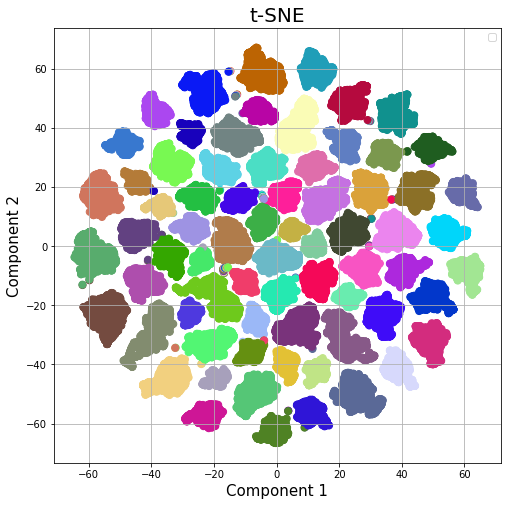

In [72]:
from random import randint

def get_rand_colors(num_colors):
    colors = {k: [] for k in 'rgb'} 
    for i in range(num_colors):
        temp = {k: randint(0, 255) for k in 'rgb'} 
        for k in temp: 
            while 1: 
                c = temp[k]
                # ensure colors are at least 1 apart in each of R, G, and B values
                t = set(j for j in range(c-1, c+1) if 0 <= j <= 255) 
                if t.intersection(colors[k]): 
                    temp[k] = randint(0, 255) 
                else: 
                    break 
            colors[k].append(temp[k]) 
    colors_lst = [(colors['r'][i] / 255, colors['g'][i] / 255, colors['b'][i] / 255) for i in range(num_colors)]
    return colors_lst

time_colors = get_rand_colors(71)
colors = []
for time in temp_embeddings_tsne_df['Time']:
    colors.append(time_colors[int(time)])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df['component 1'], temp_embeddings_tsne_df['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

In [73]:
temp_embeddings_df[:5]

0    1    2    3    4    5    6    7    8    9  ...  1015  1016  1017  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

   1018  1019  1020  1021  1022  1023  Frame  
0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0    1.0  
2   0.0   0.0   0.0   0.0   0.0   0.0    2.0  
3   0.0   0.0   0.0   0.0   0.0   0.0    3.0  
4   0.0   0.0   0.0   0.0   0.0   0.0    4.0  

[5 rows x 1025 columns]

In [74]:
def project_embeddings_tsne(temp_embeddings_df, tsne):
    neighbors_embeddings = tsne.fit_transform(temp_embeddings_df)
    neighbors_df = pd.DataFrame(data = neighbors_embeddings, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([neighbors_df, temp_embeddings_df[['Frame']]], axis = 1)
                          
    return final_df

In [75]:
# took a while ~30 minutes
temp_embeddings_tsne_df_2 = project_embeddings_tsne(temp_embeddings_df, tsne2)

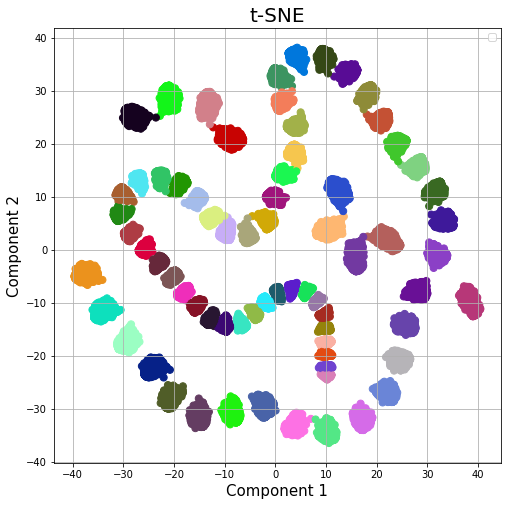

In [78]:
from random import randint

def get_rand_colors(num_colors):
    colors = {k: [] for k in 'rgb'} 
    for i in range(num_colors):
        temp = {k: randint(0, 255) for k in 'rgb'} 
        for k in temp: 
            while 1: 
                c = temp[k]
                # ensure colors are at least 1 apart in each of R, G, and B values
                t = set(j for j in range(c-1, c+1) if 0 <= j <= 255) 
                if t.intersection(colors[k]): 
                    temp[k] = randint(0, 255) 
                else: 
                    break 
            colors[k].append(temp[k]) 
    colors_lst = [(colors['r'][i] / 255, colors['g'][i] / 255, colors['b'][i] / 255) for i in range(num_colors)]
    return colors_lst

time_colors = get_rand_colors(71)
colors = []
for time in temp_embeddings_tsne_df_2['Frame']:
    colors.append(time_colors[int(time)])

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df_2['component 1'], temp_embeddings_tsne_df_2['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


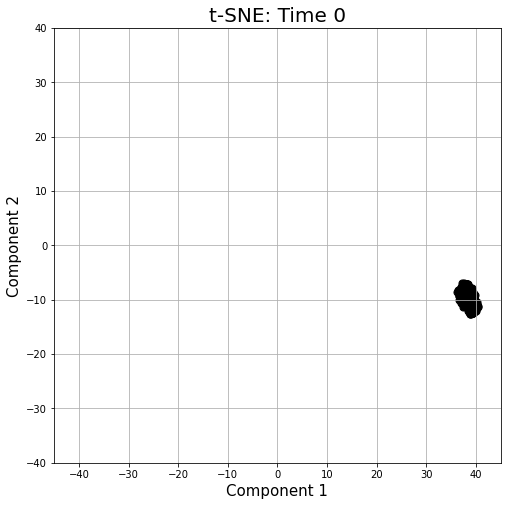

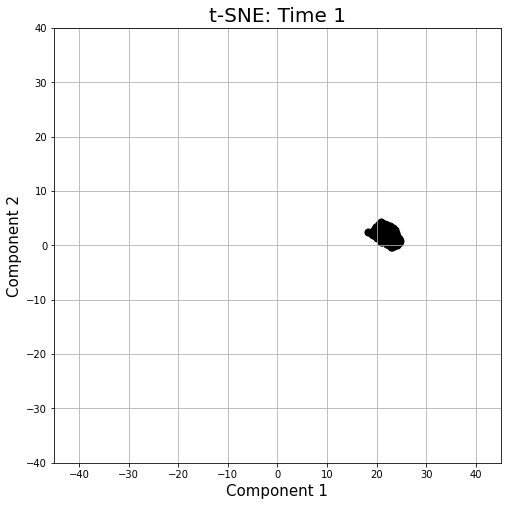

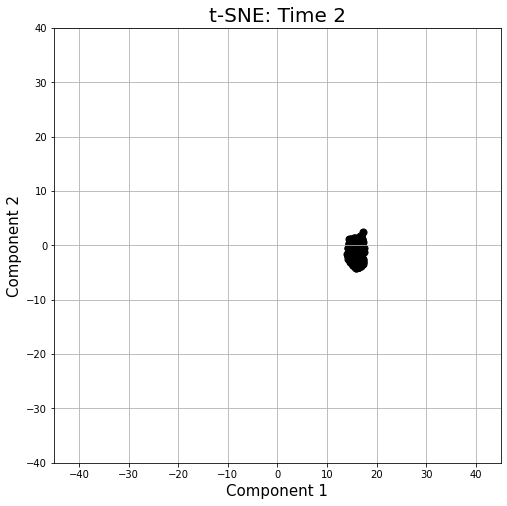

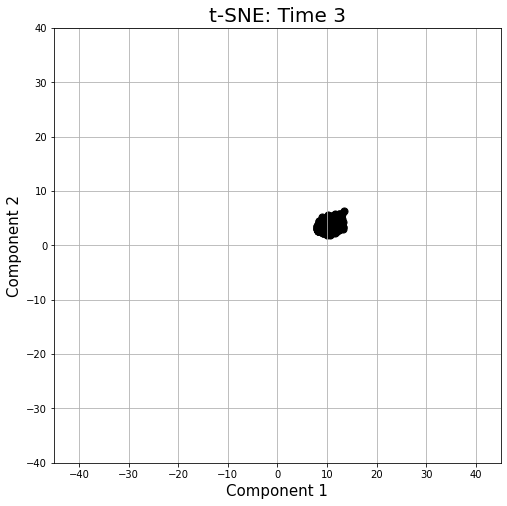

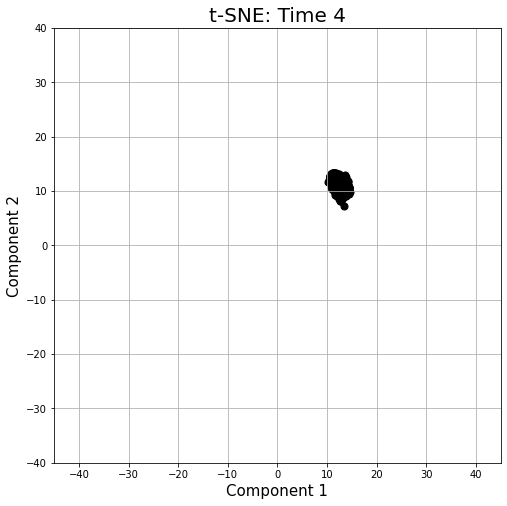

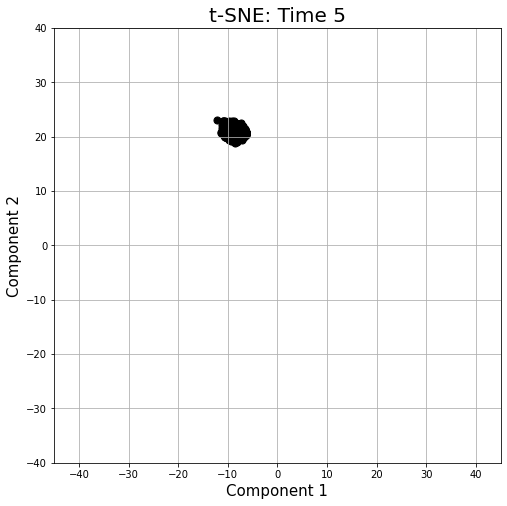

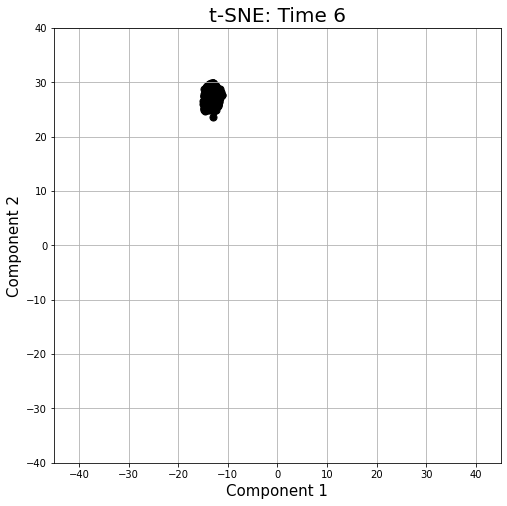

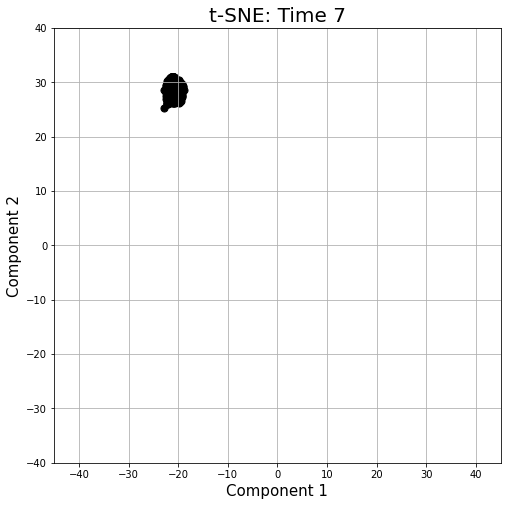

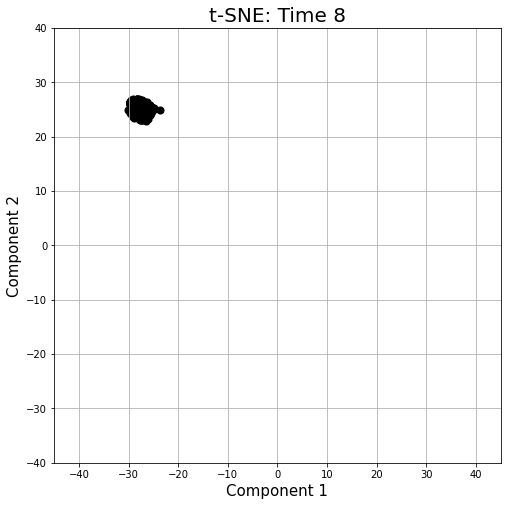

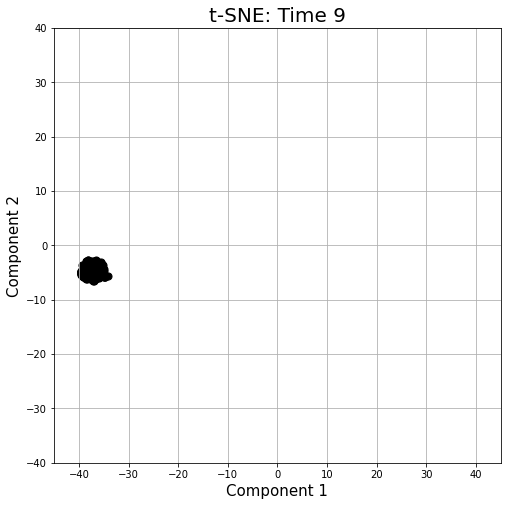

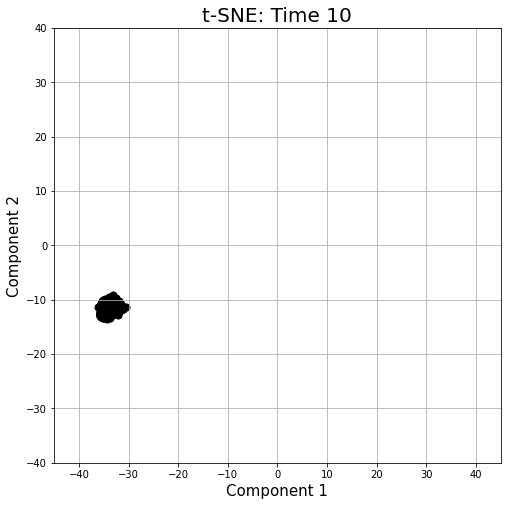

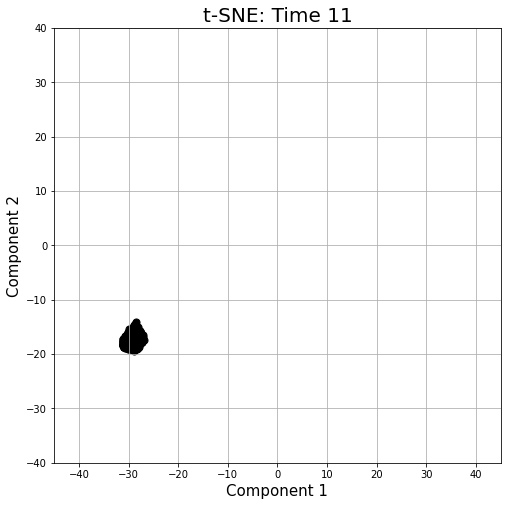

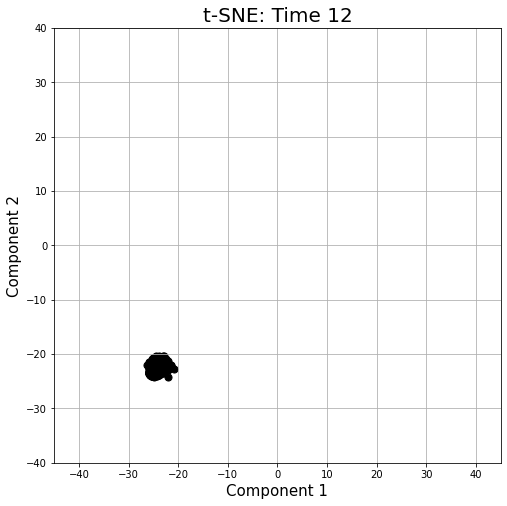

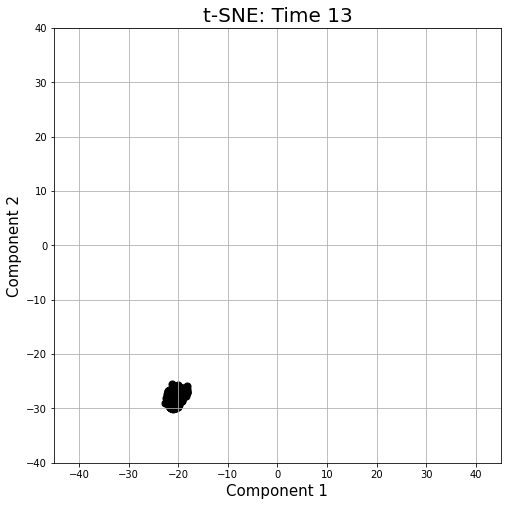

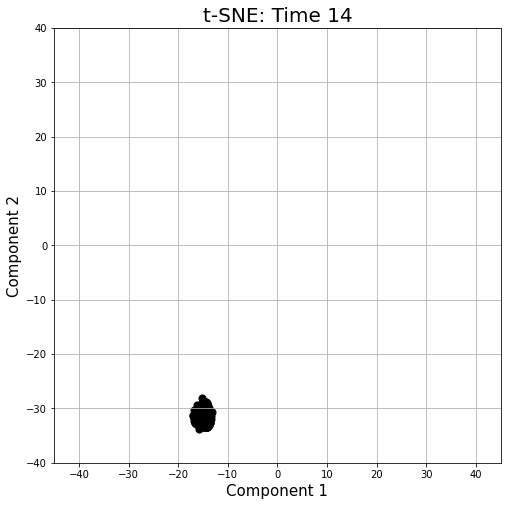

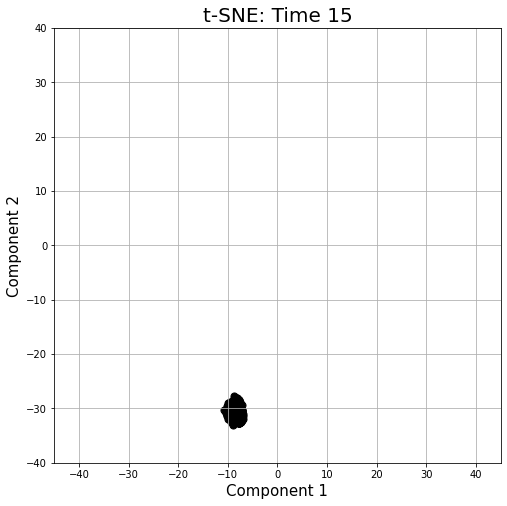

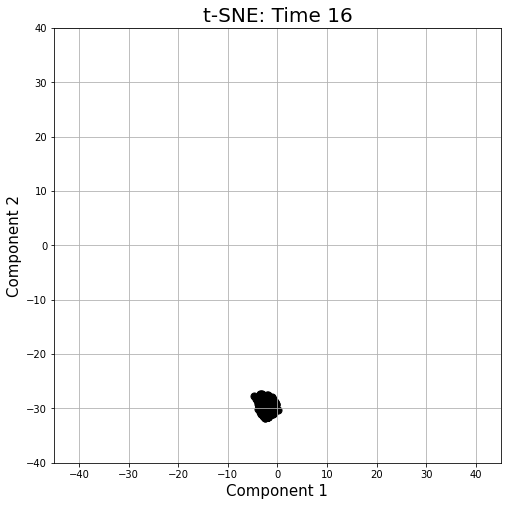

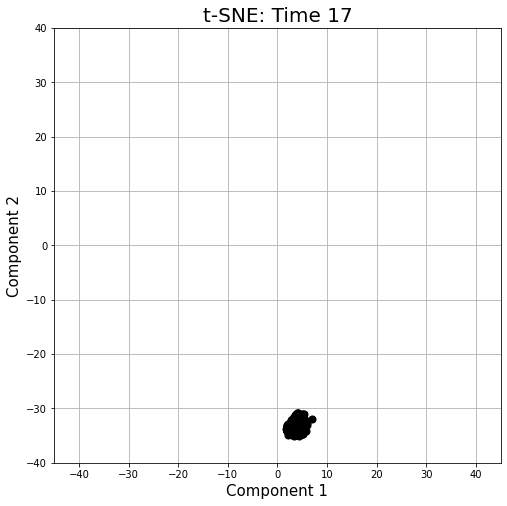

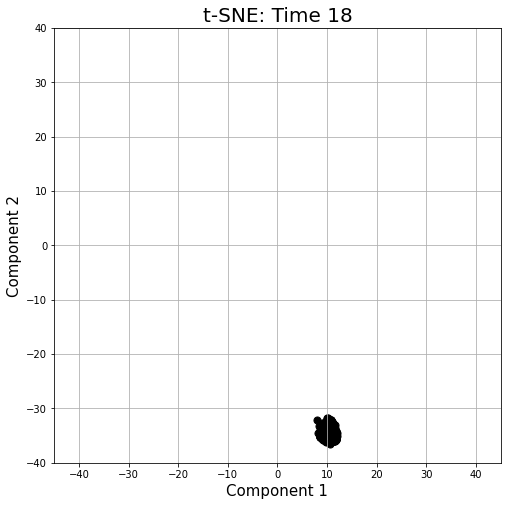

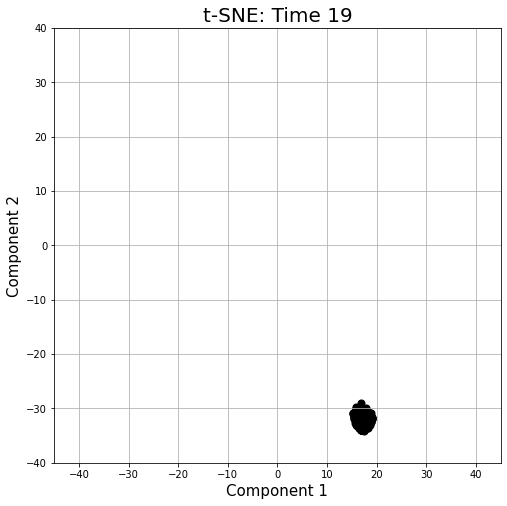

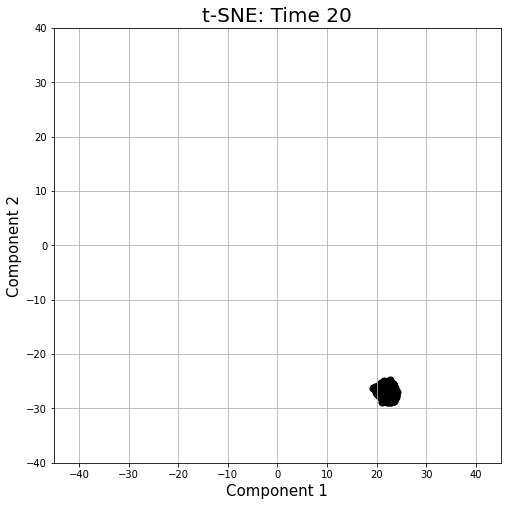

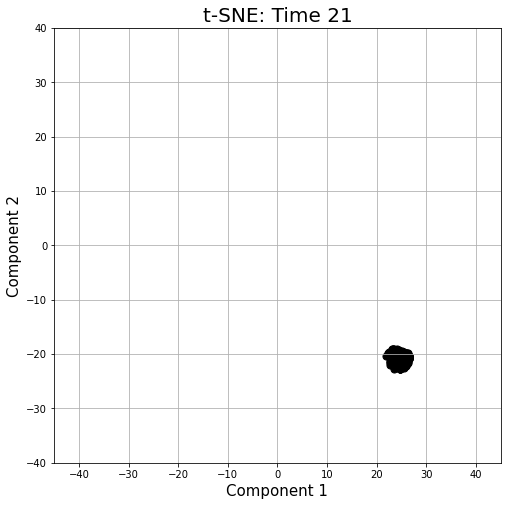

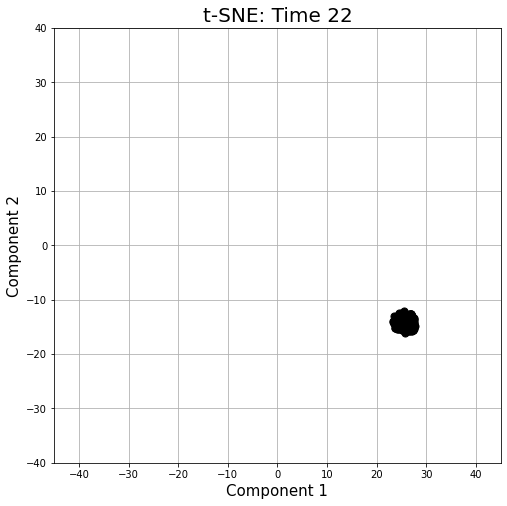

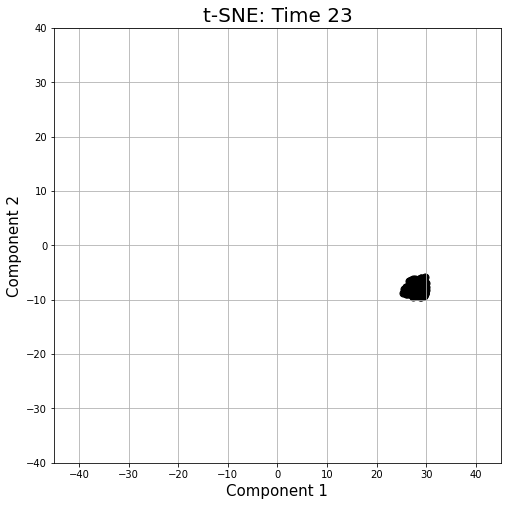

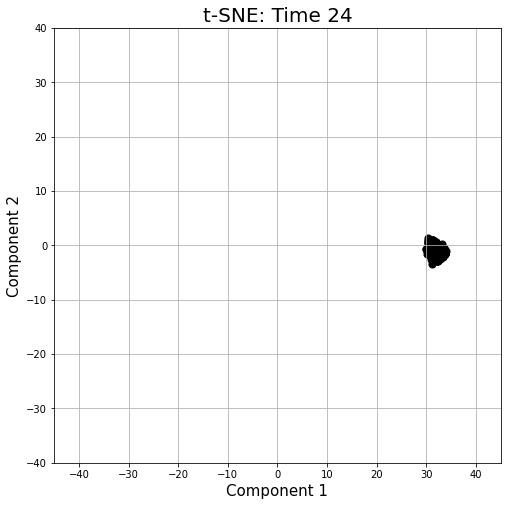

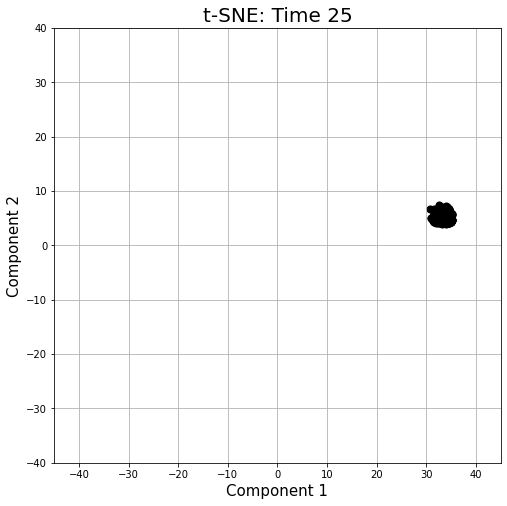

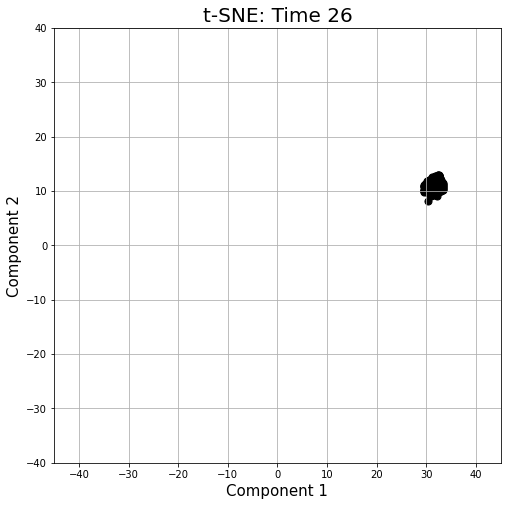

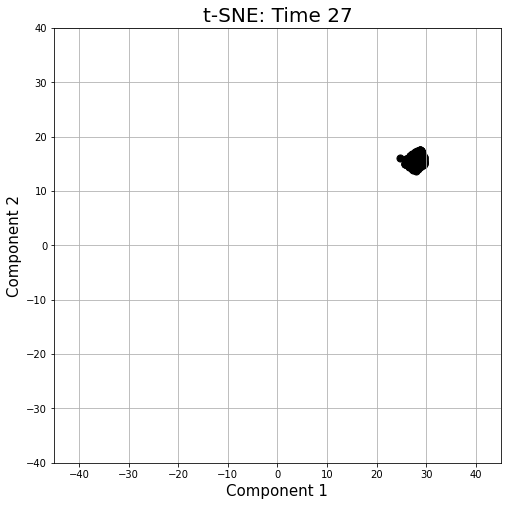

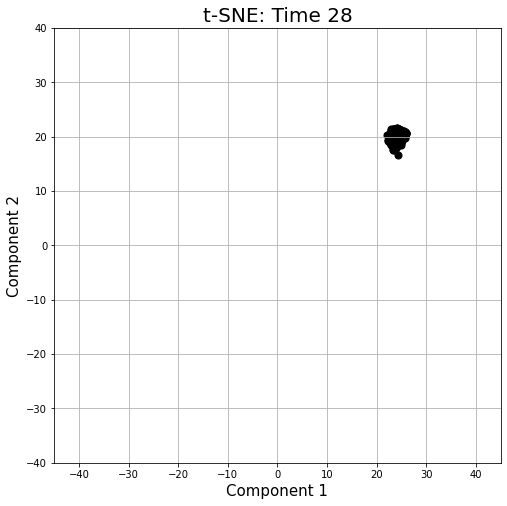

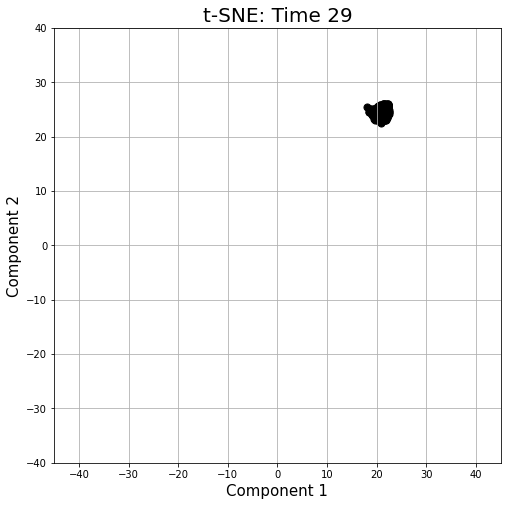

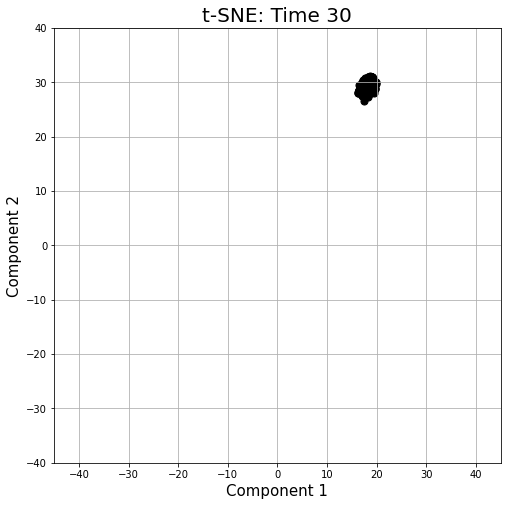

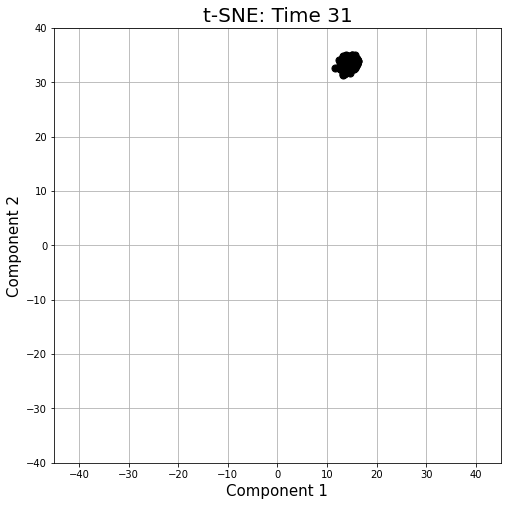

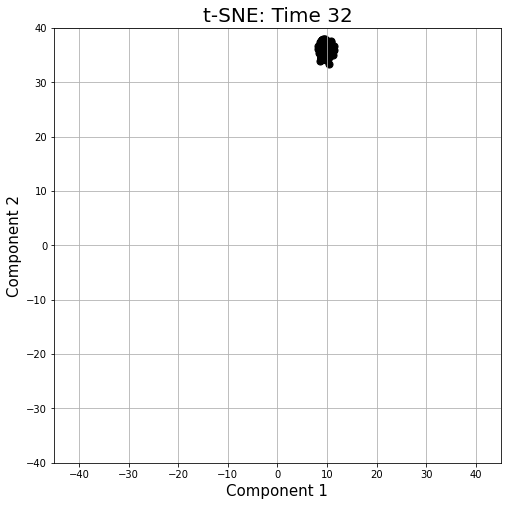

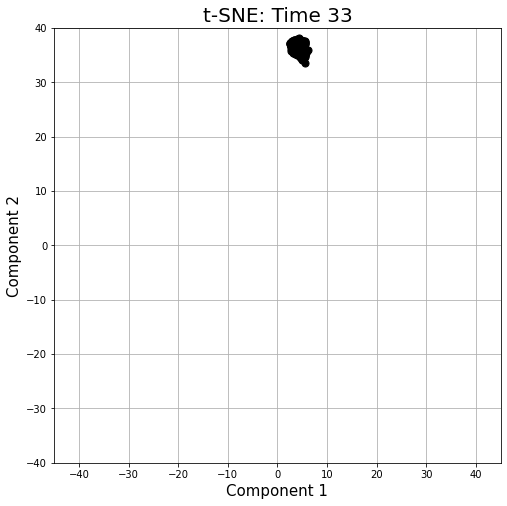

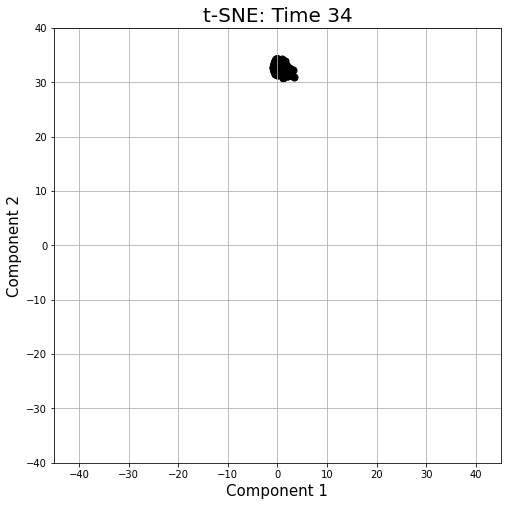

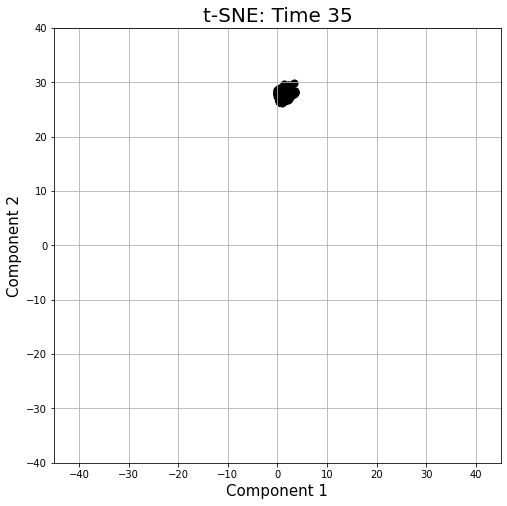

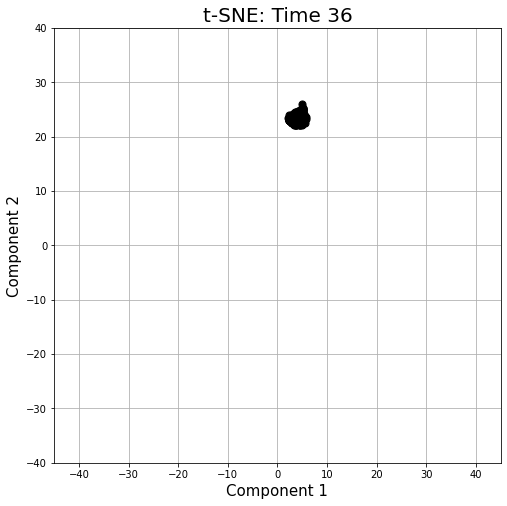

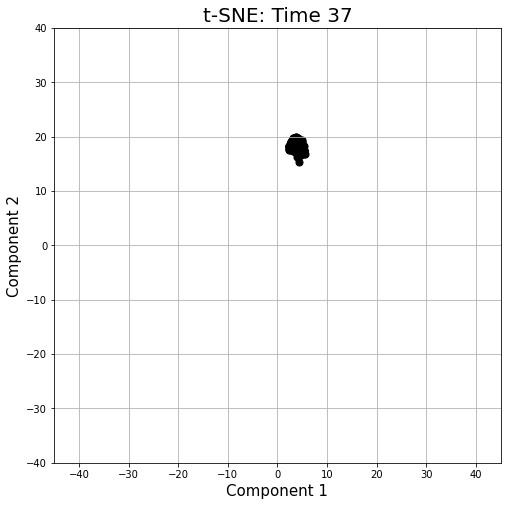

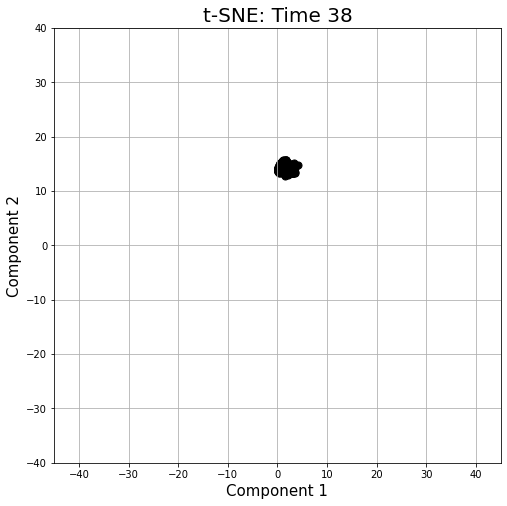

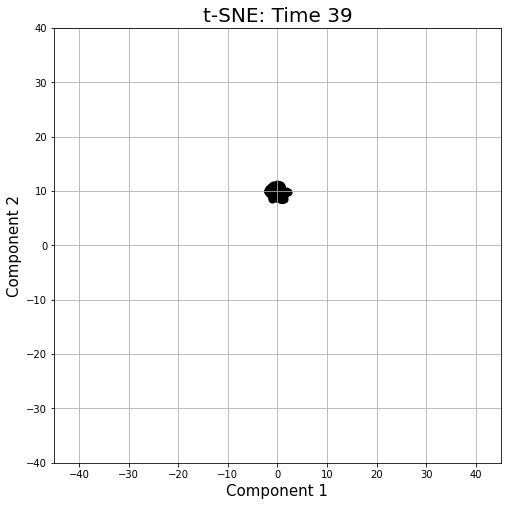

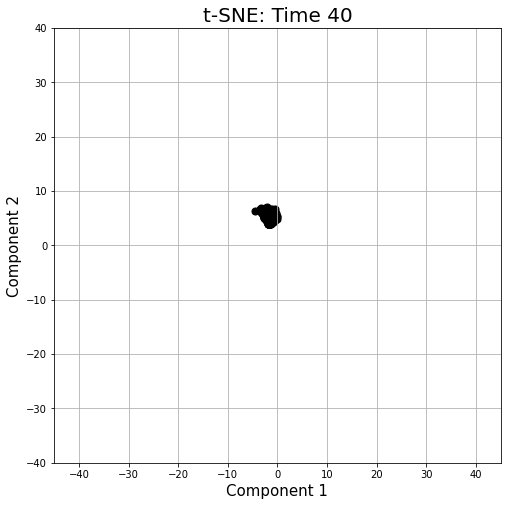

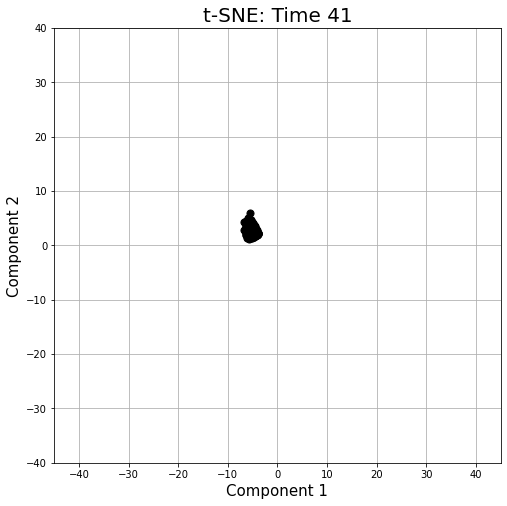

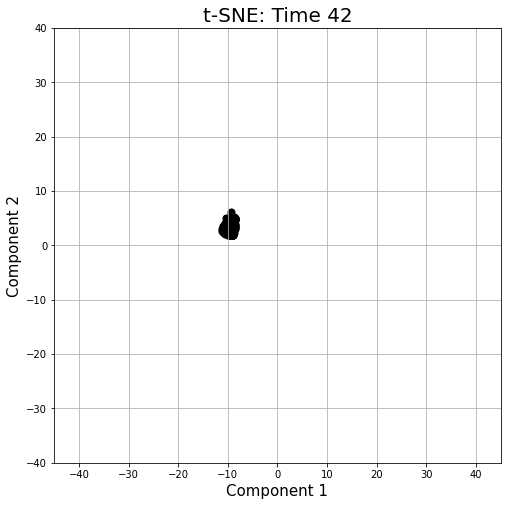

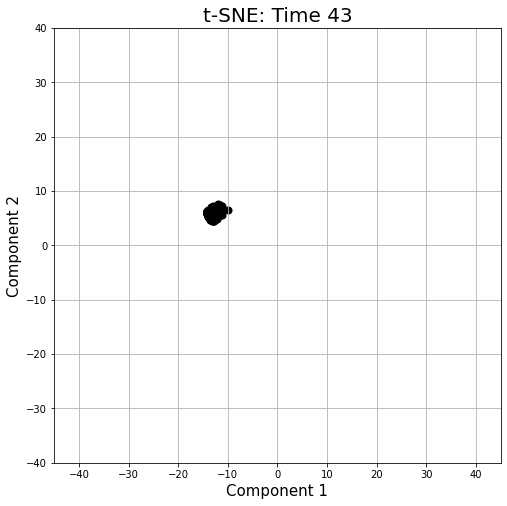

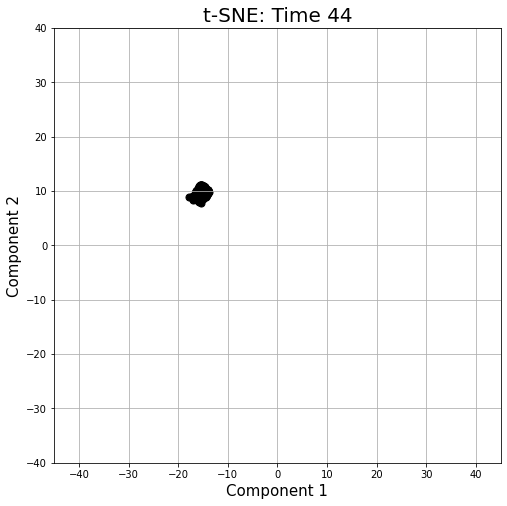

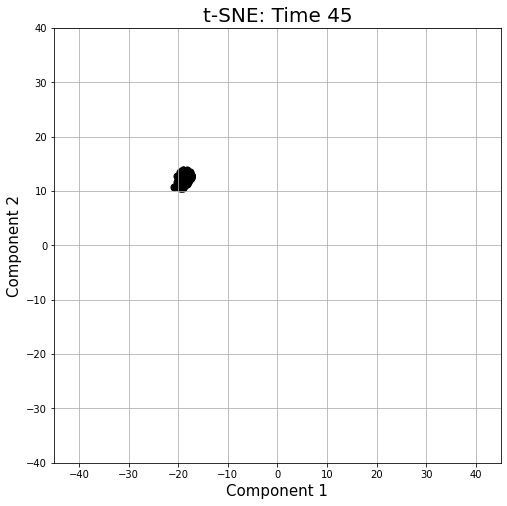

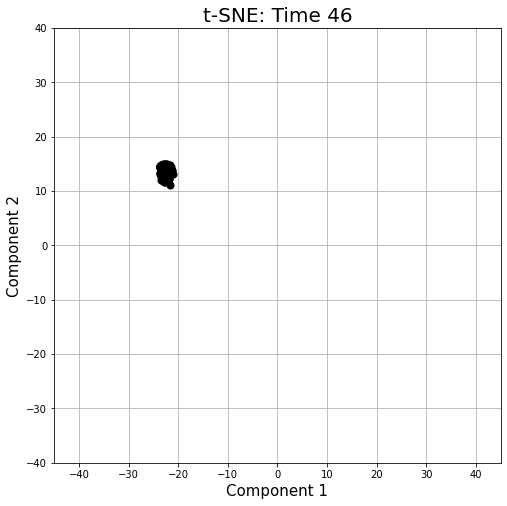

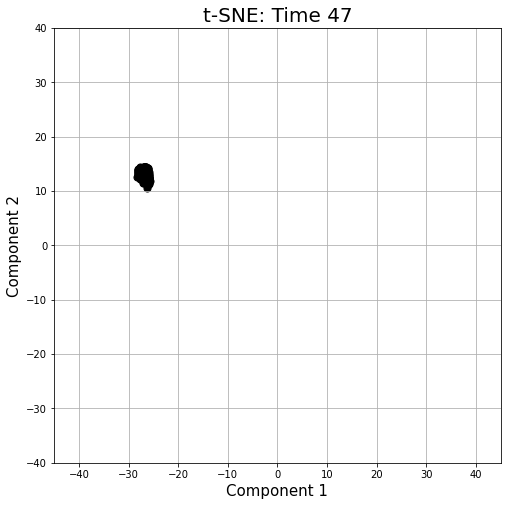

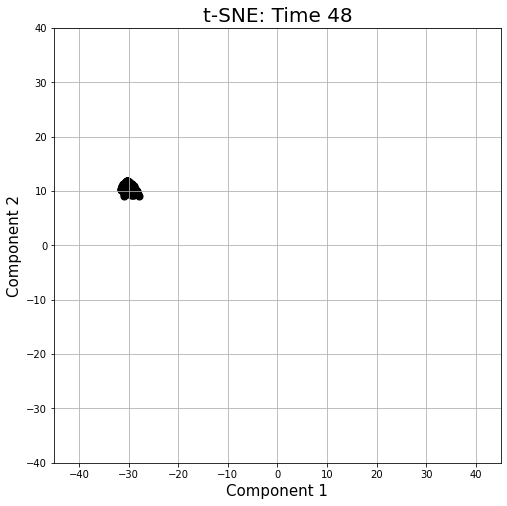

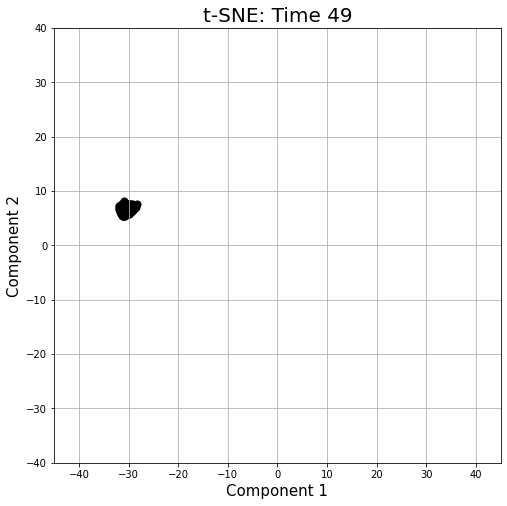

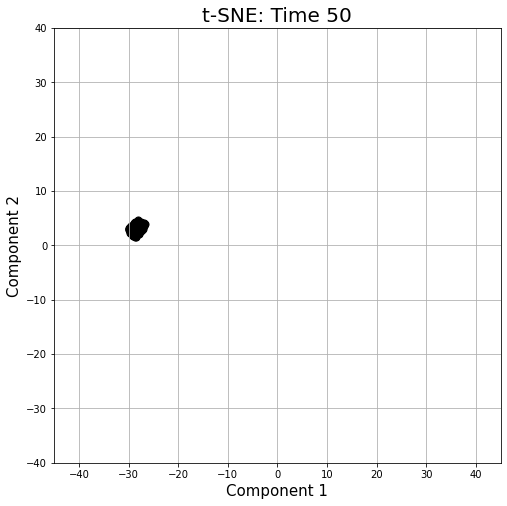

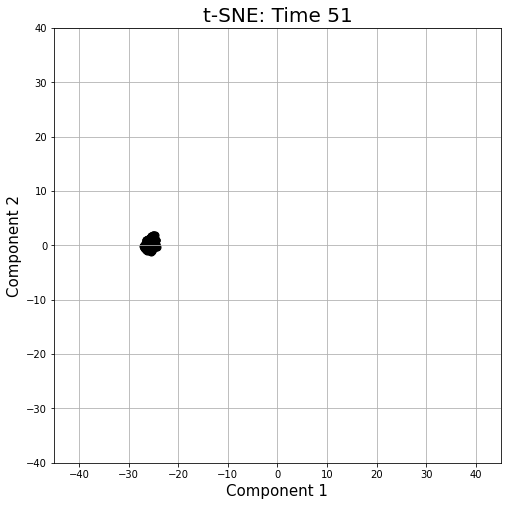

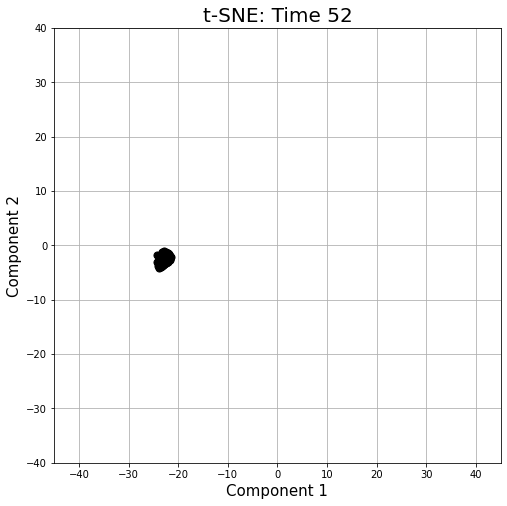

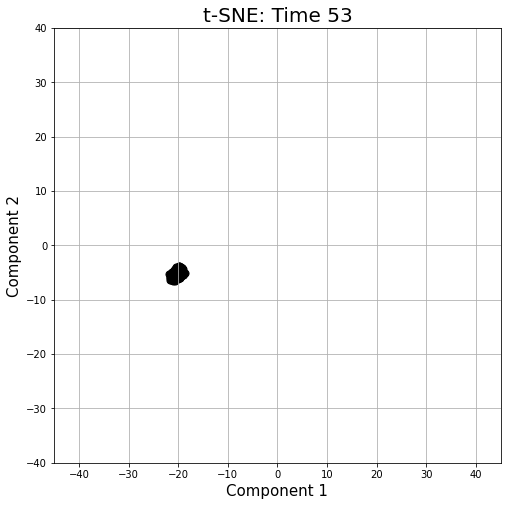

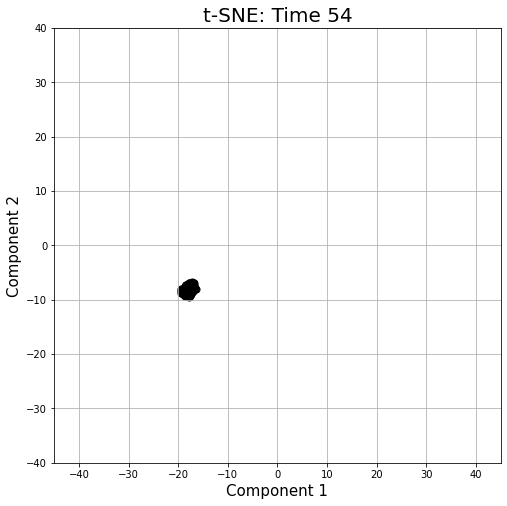

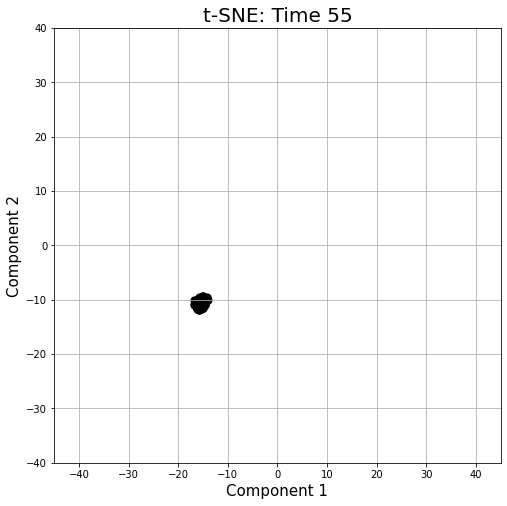

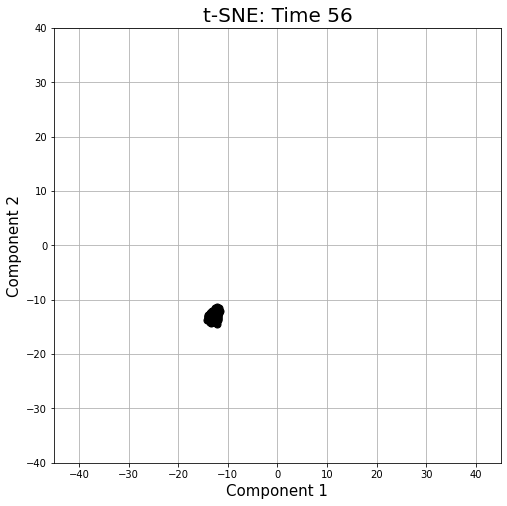

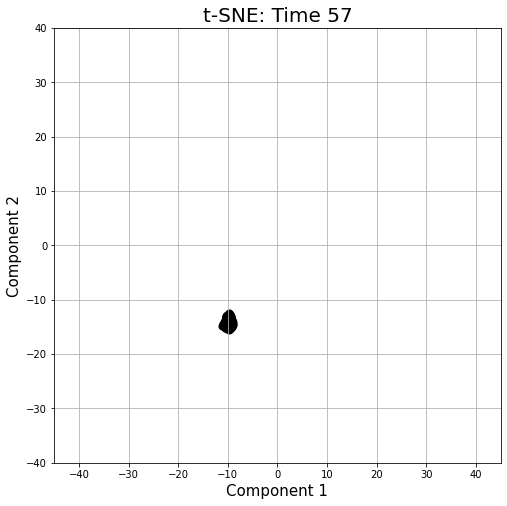

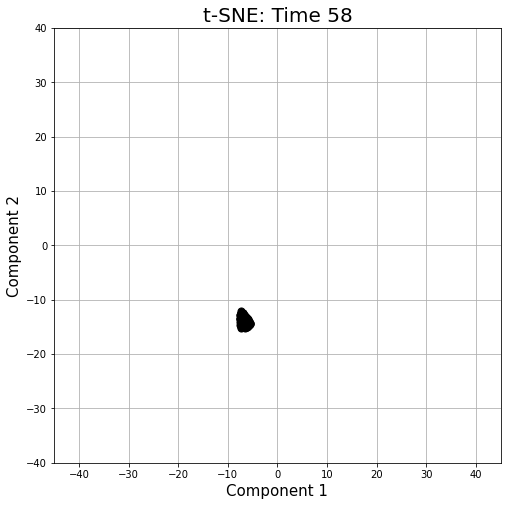

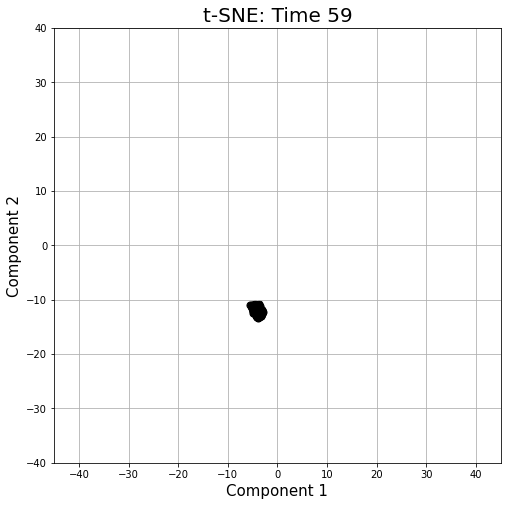

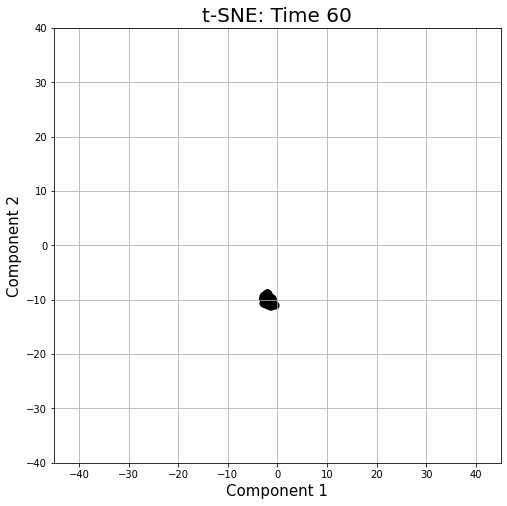

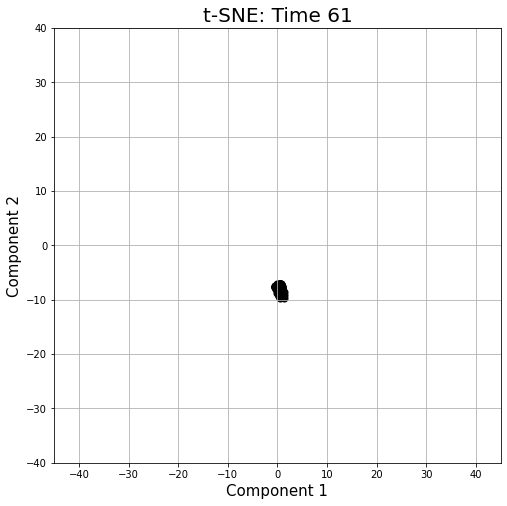

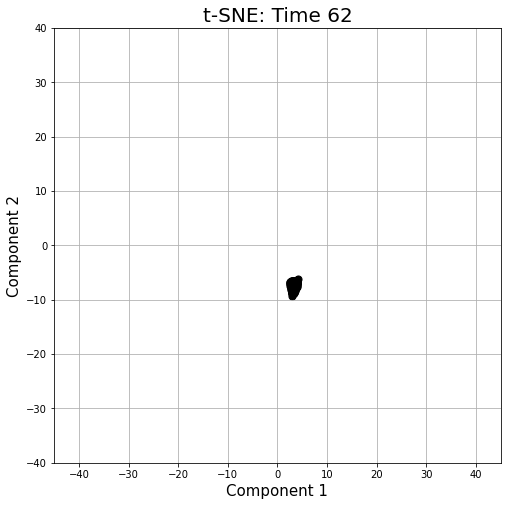

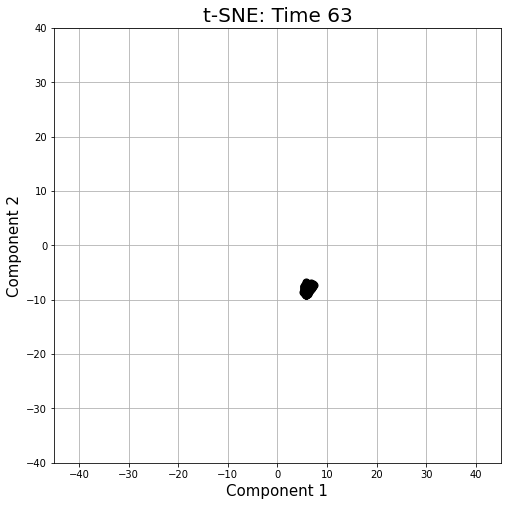

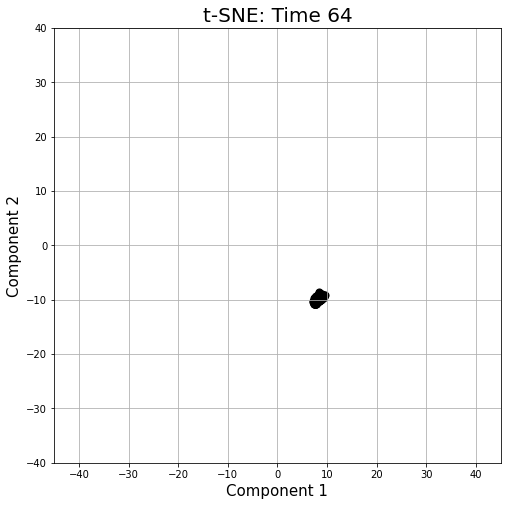

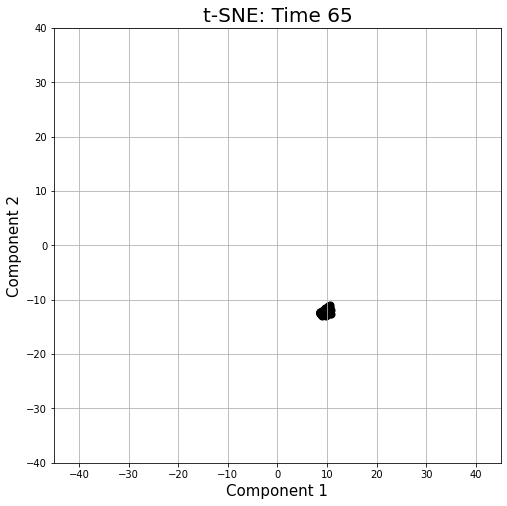

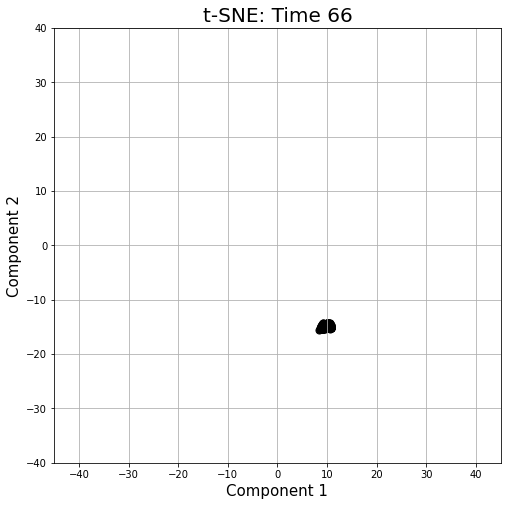

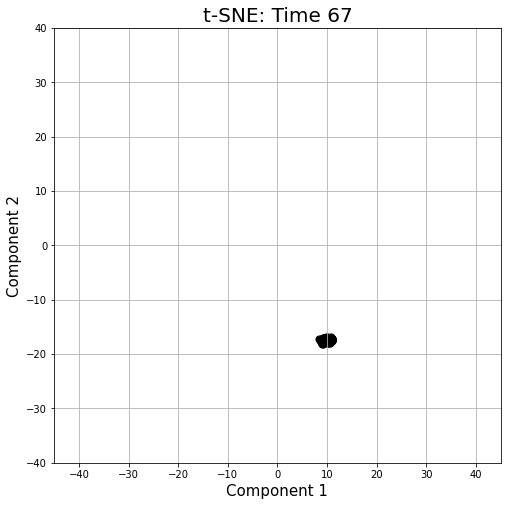

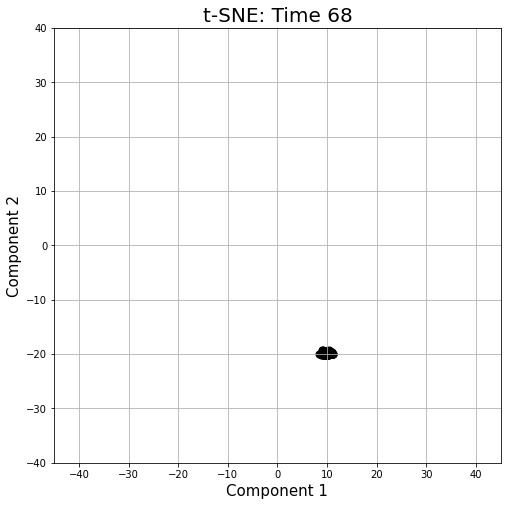

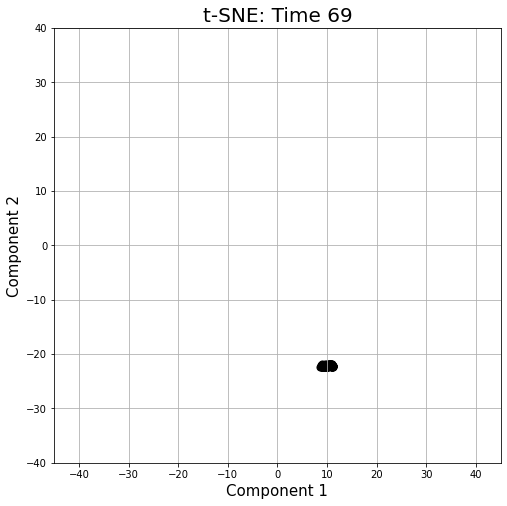

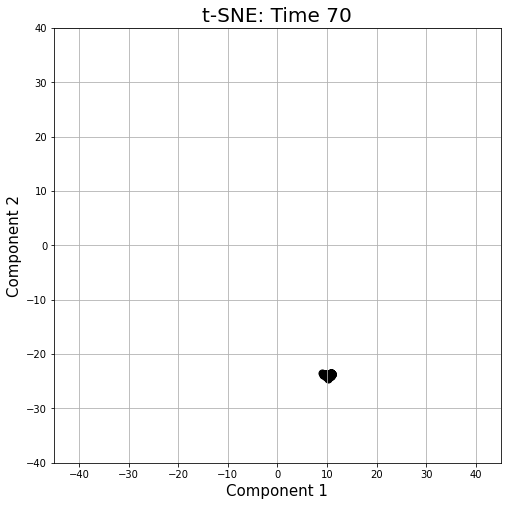

In [84]:
for time in range(71):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title('t-SNE: Time ' + str(time), fontsize = 20)
    plt.xlim(-45, 45)
    plt.ylim(-40, 40)
    indices_to_keep = (temp_embeddings_tsne_df_2['Frame'] == time)
    ax.scatter(temp_embeddings_tsne_df_2.loc[indices_to_keep, 'component 1'], temp_embeddings_tsne_df_2.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()

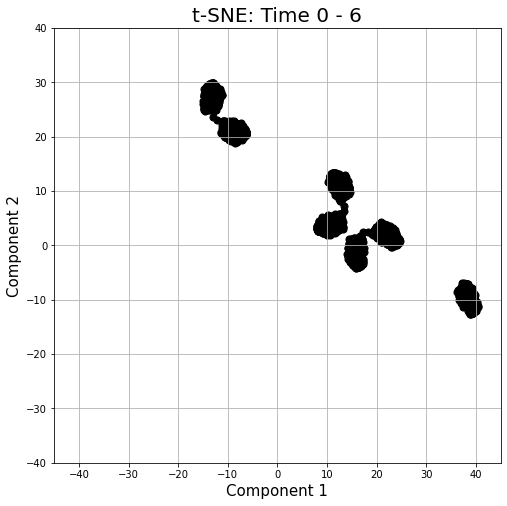

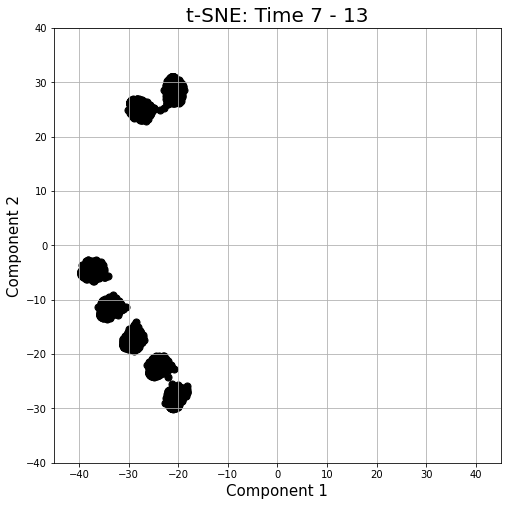

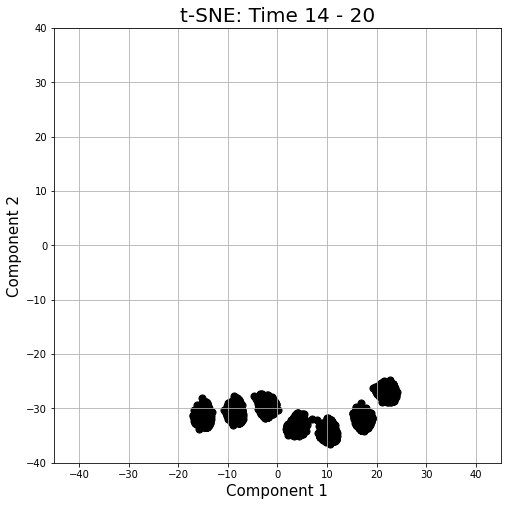

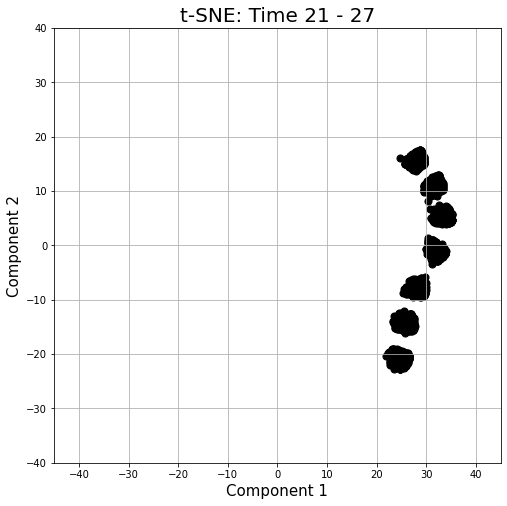

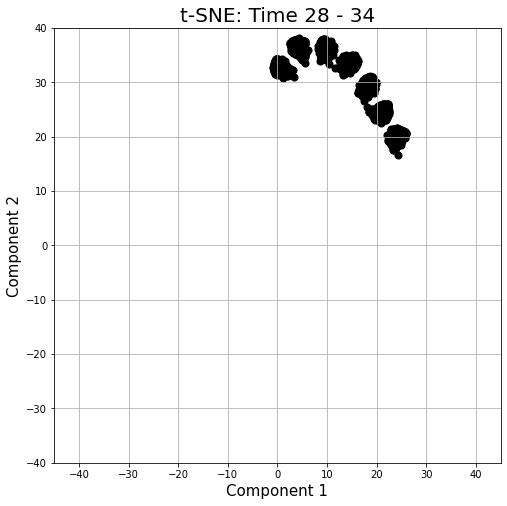

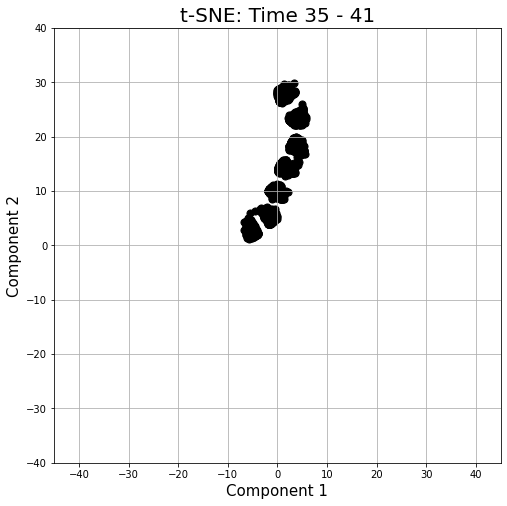

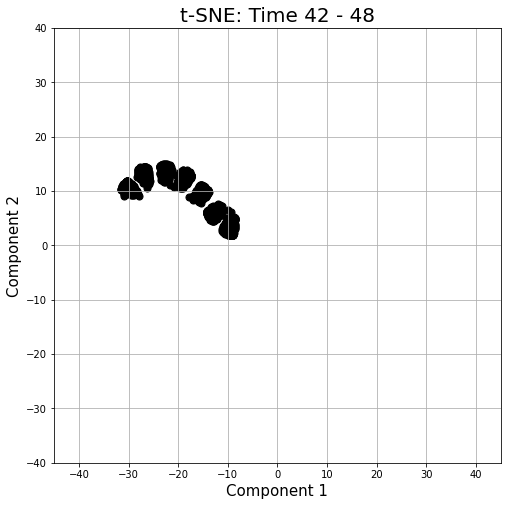

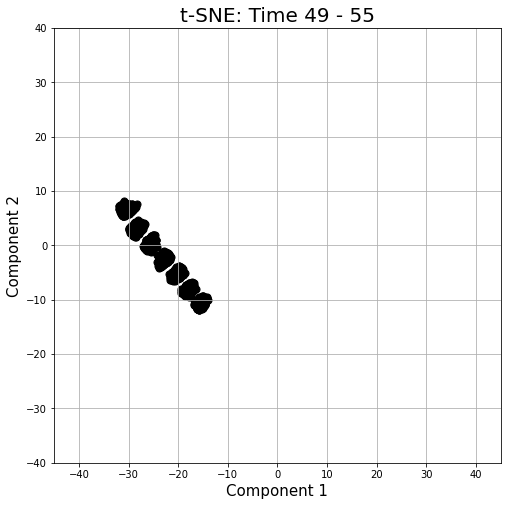

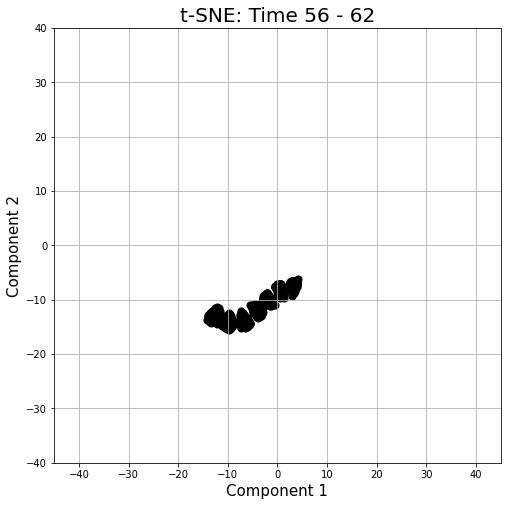

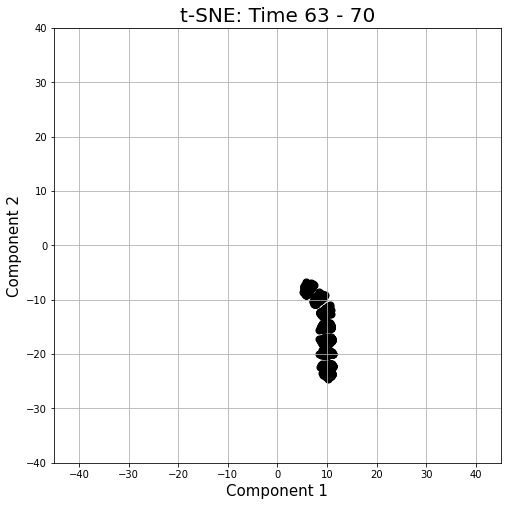

In [85]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title('t-SNE: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    plt.xlim(-45, 45)
    plt.ylim(-40, 40)
    times = [time for time in range(time_init, time_final + 1)]
    for time in times:
        indices_to_keep = (temp_embeddings_tsne_df_2['Frame'] == time)
        ax.scatter(temp_embeddings_tsne_df_2.loc[indices_to_keep, 'component 1'], temp_embeddings_tsne_df_2.loc[indices_to_keep, 'component 2'], c = 'black', s = 50)
    ax.grid()

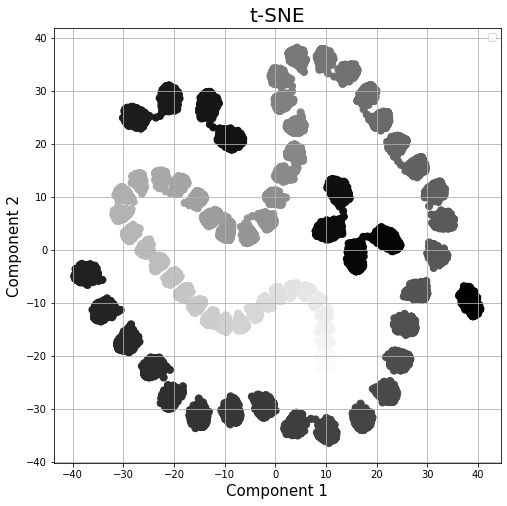

In [86]:
colors = []
for time in temp_embeddings_tsne_df['Time']:
    colors.append((time / 70, time / 70, time / 70))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_df_2['component 1'], temp_embeddings_tsne_df_2['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

In [88]:
tsne2.kl_divergence_

0.41503050923347473

In [89]:
tsne.kl_divergence_

2.050698757171631

In [90]:
# Initialize with PCA

In [92]:
pca.explained_variance_

array([13.20320273,  9.37682256])

In [93]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

std_embeddings_df = standardize_embeddings(temp_embeddings_df)

def project_embeddings(std_embeddings_df):
    principal_components = pca.fit_transform(std_embeddings_df)
    principal_df = pd.DataFrame(data = principal_components, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

KeyError: "None of [Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,\n            ...\n            1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023],\n           dtype='int64', length=1024)] are in the [columns]"

In [94]:
temp_embeddings_df[:5]

0    1    2    3    4    5    6    7    8    9  ...  1015  1016  1017  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

   1018  1019  1020  1021  1022  1023  Frame  
0   0.0   0.0   0.0   0.0   0.0   0.0    0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0    1.0  
2   0.0   0.0   0.0   0.0   0.0   0.0    2.0  
3   0.0   0.0   0.0   0.0   0.0   0.0    3.0  
4   0.0   0.0   0.0   0.0   0.0   0.0    4.0  

[5 rows x 1025 columns]

In [95]:
temp_embeddings_df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023',
       'Frame'],
      dtype='object', length=1025)

In [96]:
temp_embeddings_df = get_temp_embeddings_df()

In [97]:
temp_embeddings_df[:5]

0    1    2    3    4    5    6    7    8    9  ...  1015  1016  1017  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

   1018  1019  1020  1021  1022  1023  Time  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   2.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   3.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   4.0  

[5 rows x 1025 columns]

In [98]:
temp_embeddings_df.columns

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
         1015,   1016,   1017,   1018,   1019,   1020,   1021,   1022,   1023,
       'Time'],
      dtype='object', length=1025)

In [99]:
std_embeddings_df = standardize_embeddings(temp_embeddings_df)

In [101]:
cols = [idx for idx in range(embedding_dim)]
cols.append('Time')
temp_embeddings_df = pd.read_csv('/data/large_files/embeddings/pad_dense_embeddings.csv', index_col=[0], names=cols)
temp_embeddings_pca_df = pd.read_csv('/data/large_files/embeddings/resize_dense_embeddings_pca.csv', index_col=[0], names=cols)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
from sklearn.decomposition import PCA
pca_10 = PCA(n_components=10)

std_embeddings_df = standardize_embeddings(temp_embeddings_df)

def project_embeddings(std_embeddings_df, pca):
    principal_components = pca.fit_transform(std_embeddings_df)
    principal_df = pd.DataFrame(data = principal_components, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

In [103]:
temp_embeddings_pca_10_df = project_embeddings(std_embeddings_df, pca_10)

ValueError: Shape of passed values is (57977, 10), indices imply (57977, 2)

In [104]:
def project_embeddings(std_embeddings_df, pca):
    comps = pca.components_
    
    principal_components = pca.fit_transform(std_embeddings_df)
    cols = ['component' + str(comp + 1) for comp in range(comps)]
    principal_df = pd.DataFrame(data = principal_components, columns = cols)
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

In [105]:
temp_embeddings_pca_10_df = project_embeddings(std_embeddings_df, pca_10)

TypeError: only integer scalar arrays can be converted to a scalar index

In [107]:
comps = pca_10.components_

In [108]:
comps

array([[ 0.00000000e+00,  3.13027631e-02,  3.13027631e-02, ...,
         3.13027631e-02,  3.13027585e-02,  3.13027631e-02],
       [ 1.27463690e-17, -4.55218966e-04, -4.55218966e-04, ...,
        -4.55218966e-04, -4.57596631e-04, -4.55218966e-04],
       [-1.29583740e-17, -6.80415662e-04, -6.80415662e-04, ...,
        -6.80415662e-04, -6.85127357e-04, -6.80415662e-04],
       ...,
       [-2.94607549e-17, -1.19537257e-03, -1.19537257e-03, ...,
        -1.19537257e-03, -1.25109331e-03, -1.19537257e-03],
       [-3.36672597e-18, -3.42789672e-04, -3.42789672e-04, ...,
        -3.42789672e-04, -3.74122431e-04, -3.42789672e-04],
       [ 1.51998006e-17, -4.60234220e-04, -4.60234220e-04, ...,
        -4.60234220e-04, -3.35685273e-04, -4.60234220e-04]])

In [109]:
len(comps)

10

In [110]:
def project_embeddings(std_embeddings_df, pca):
    n_comps = len(pca.components_)
    
    principal_components = pca.fit_transform(std_embeddings_df)
    cols = ['component' + str(comp + 1) for comp in range(n_comps)]
    principal_df = pd.DataFrame(data = principal_components, columns = cols)
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

In [111]:
temp_embeddings_pca_10_df = project_embeddings(std_embeddings_df, pca_10)

In [113]:
pca_10.explained_variance_

array([1.02056755e+03, 8.93540390e-01, 5.89708969e-01, 4.06780911e-01,
       2.87689628e-01, 5.81558308e-02, 3.75863625e-02, 3.31697789e-02,
       2.35862602e-02, 1.77874100e-02])

In [114]:
pca_2 = PCA(n_components=2)

In [115]:
temp_embeddings_pca_2_df = project_embeddings(std_embeddings_df, pca_2)

AttributeError: 'PCA' object has no attribute 'components_'

In [117]:
def project_embeddings(std_embeddings_df, pca):
    n_comps = pca.n_components_
    
    principal_components = pca.fit_transform(std_embeddings_df)
    cols = ['component' + str(comp + 1) for comp in range(n_comps)]
    principal_df = pd.DataFrame(data = principal_components, columns = cols)
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

In [118]:
temp_embeddings_pca_2_df = project_embeddings(std_embeddings_df, pca_2)

AttributeError: 'PCA' object has no attribute 'n_components_'

In [119]:
def project_embeddings(std_embeddings_df, pca, n_comps):
    principal_components = pca.fit_transform(std_embeddings_df)
    cols = ['component' + str(comp + 1) for comp in range(n_comps)]
    principal_df = pd.DataFrame(data = principal_components, columns = cols)
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

In [120]:
temp_embeddings_pca_2_df = project_embeddings(std_embeddings_df, pca_2, 2)

In [121]:
pca_2.explained_variance_

array([1.02056755e+03, 8.93540390e-01])

In [124]:
pca_2.explained_variance_ratio_

array([9.97605030e-01, 8.73435951e-04])

In [125]:
pca_10.explained_variance_ratio_

array([9.97605030e-01, 8.73435951e-04, 5.76440662e-04, 3.97628441e-04,
       2.81216682e-04, 5.68473389e-05, 3.67406786e-05, 3.24234671e-05,
       2.30555752e-05, 1.73871977e-05])

In [126]:
temp_embeddings_pca_2_df[:5]

component1  component2 Time
0.0  7692.031644   -0.097938  0.0
1.0    -0.174009   -0.486582  1.0
2.0    -0.171788   -0.530651  2.0
3.0    -0.172861   -0.522219  3.0
4.0    -0.156884   -0.550290  4.0
5.0    -0.153812   -0.552751  5.0

In [127]:
temp_embeddings_df[:5]

0    1    2    3    4    5    6    7    8    9  ...    1015    1016  \
NaN  0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  ...  1015.0  1016.0   
0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   
1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   
2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   
3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   
4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   
5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...     0.0     0.0   

       1017    1018    1019    1020    1021    1022    1023   Time  
NaN  1017.0  1018.0  1019.0  1020.0  1021.0  1022.0  1023.0  Frame  
0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.0  
1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    1.0  
2.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    2.0  
3.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    3.0  
4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    4.0  
5.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    5.0  

[7 rows x 1025 columns]

In [128]:
temp_embeddings_df.columns

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
         1015,   1016,   1017,   1018,   1019,   1020,   1021,   1022,   1023,
       'Time'],
      dtype='object', length=1025)

In [130]:
cols = [idx for idx in range(embedding_dim)]
cols.append('Time')
temp_embeddings_df = pd.read_csv('/data/large_files/embeddings/pad_dense_embeddings.csv', index_col=[0], names=cols, header=0)
temp_embeddings_pca_df = pd.read_csv('/data/large_files/embeddings/resize_dense_embeddings_pca.csv', index_col=[0])

In [131]:
temp_embeddings_df[:5]

0    1    2    3    4    5    6    7    8    9  ...  1015  1016  1017  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   0.0   0.0   

   1018  1019  1020  1021  1022  1023  Time  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   2.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   3.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   4.0  

[5 rows x 1025 columns]

In [132]:
temp_embeddings_df.columns

Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
         1015,   1016,   1017,   1018,   1019,   1020,   1021,   1022,   1023,
       'Time'],
      dtype='object', length=1025)

In [133]:
pca_10 = PCA(n_components=10)
std_embeddings_df = standardize_embeddings(temp_embeddings_df)

In [134]:
def project_embeddings(std_embeddings_df, pca, n_comps):
    principal_components = pca.fit_transform(std_embeddings_df)
    cols = ['component' + str(comp + 1) for comp in range(n_comps)]
    principal_df = pd.DataFrame(data = principal_components, columns = cols)
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

In [135]:
temp_embeddings_pca_10_df = project_embeddings(std_embeddings_df, pca_10, 10)

In [136]:
pca_10.explained_variance_ratio_

array([0.07294461, 0.05180476, 0.04367901, 0.04098156, 0.03437475,
       0.0299642 , 0.02859152, 0.02737881, 0.02535943, 0.02392125])

In [137]:
np.sum(pca_10.explained_variance_ratio_)

0.3789998931899753

In [144]:
n_comps = 2
high_exp_var = False
while high_exp_var == False:
    pca = PCA(n_components=n_comps)
    pca_df = project_embeddings(std_embeddings_df, pca, n_comps)
    if np.sum(pca.explained_variance_ratio_) > 0.5:
        print(n_comps)
        print(pca.explained_variance_ratio_)
        print(np.sum(pca.explained_variance_ratio_))
        high_exp_var = True
    n_comps += 1

18
[0.07294461 0.05180476 0.04367901 0.04098157 0.03437476 0.02996421
 0.02859158 0.02737884 0.02536024 0.02392129 0.02132085 0.01940904
 0.0166985  0.01626454 0.01570842 0.01436908 0.01404753 0.01345356]
0.5102723874037512


In [145]:
n_comps = 2
high_exp_var = False
while high_exp_var == False:
    pca = PCA(n_components=n_comps)
    pca_df = project_embeddings(std_embeddings_df, pca, n_comps)
    if np.sum(pca.explained_variance_ratio_) > 0.9:
        print(n_comps)
        print(pca.explained_variance_ratio_)
        high_exp_var = True
    n_comps += 1

81
[0.07294461 0.05180476 0.04367901 0.04098157 0.03437476 0.02996421
 0.02859158 0.02737884 0.02536025 0.0239213  0.02132094 0.01940912
 0.01669935 0.01626552 0.01571036 0.0143772  0.01404884 0.01346457
 0.01294133 0.01246754 0.01199306 0.0110515  0.0106742  0.01048361
 0.01024863 0.0098443  0.0097078  0.00966559 0.00941545 0.0088902
 0.00831098 0.00822727 0.00797953 0.00769876 0.00763651 0.00738494
 0.00694805 0.00676617 0.00663463 0.00659284 0.00636151 0.00626507
 0.00608335 0.00600022 0.00585177 0.00575922 0.00566295 0.00564307
 0.00562188 0.0055984  0.00557087 0.00554756 0.00550422 0.00544335
 0.00535447 0.00515144 0.00504599 0.00492828 0.00485523 0.00475313
 0.00443935 0.00437971 0.00432169 0.00425828 0.00422073 0.00417273
 0.00409479 0.00405884 0.0039952  0.0038861  0.00386379 0.00377551
 0.00370165 0.00360821 0.00347959 0.00340219 0.00336791 0.00333415
 0.0031614  0.00309946 0.00293921]


In [146]:
np.sum(pca.explained_variance_ratio_)

0.9024221564888039

In [150]:
# Initialize with PCA with explained variance > 50%

In [151]:
def project_embeddings(std_embeddings_df, pca, n_comps):
    principal_components = pca.fit_transform(std_embeddings_df)
    cols = ['component' + str(comp + 1) for comp in range(n_comps)]
    principal_df = pd.DataFrame(data = principal_components, columns = cols)
    
    final_df = pd.concat([principal_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

In [152]:
std_embeddings_df = standardize_embeddings(temp_embeddings_df)

In [153]:
pca_18 = PCA(n_components=18)

In [154]:
temp_embeddings_pca_18_df = project_embeddings(temp_embeddings_df, pca_18, 18)

In [155]:
temp_embeddings_pca_18_df[30:40]

component1  component2  component3  component4  component5  component6  \
30    1.345292   -0.416686    0.365107    0.007022    0.305950   -0.371894   
31    2.345312   -0.418960    0.394365    0.016096    0.278000   -0.358367   
32    3.344642   -0.437154   -0.119628    0.018060    0.227681   -0.120701   
33    4.344417   -0.400032   -0.251598    0.086459    0.470045   -0.045209   
34    5.344510   -0.388353   -0.212827    0.080658    0.434071   -0.033270   
35  -28.653552    0.188368    0.240099    0.710935    0.023587   -0.089102   
36  -27.653400    0.240368    0.272683    0.714281   -0.045916   -0.110844   
37  -26.653539    0.214745    0.197247    0.657219   -0.076558    0.099336   
38  -25.653630    0.151591    0.239070    0.644136   -0.039511    0.390151   
39  -24.653626    0.127561    0.288584    0.704699   -0.059251    0.212268   

    component7  component8  component9  component10  component11  component12  \
30   -0.140398    0.455055    0.084794    -0.085740    -0.192051    -0.036020   
31   -0.072539    0.419239    0.086082    -0.095694    -0.182155    -0.026451   
32   -0.193519    0.224316   -0.072343     0.024362    -0.037154     0.091871   
33   -0.108864   -0.006512   -0.235295     0.103206    -0.048040    -0.001762   
34   -0.121867    0.064462   -0.230735     0.093501    -0.070041    -0.008483   
35   -0.156637    0.154812    0.144208     0.178989     0.182826    -0.095897   
36   -0.083215    0.065788    0.178377     0.160257     0.205507    -0.118624   
37   -0.016804    0.053352    0.145687     0.170966     0.202761    -0.106135   
38    0.072317    0.087241    0.110842     0.243554     0.210256    -0.066633   
39   -0.001653    0.102967    0.138845     0.240789     0.183915    -0.066411   

    component13  component14  component15  component16  component17  \
30     0.027973     0.178911     0.302715    -0.113480    -0.147283   
31     0.025653     0.160730     0.318522    -0.136449    -0.132155   
32    -0.045655    -0.006427     0.046968     0.035545    -0.134914   
33    -0.050576    -0.058306     0.014361     0.078566    -0.058018   
34    -0.043924    -0.064270     0.017837     0.098672    -0.067767   
35    -0.135726     0.151563     0.046208    -0.009554    -0.121249   
36    -0.147928     0.115211    -0.006498    -0.046969    -0.075962   
37    -0.146592     0.012272     0.038513    -0.057256    -0.033526   
38    -0.003678     0.036612     0.110667    -0.051323    -0.022156   
39    -0.031950     0.077215     0.054056    -0.033327    -0.060603   

    component18  Time  
30     0.050424  30.0  
31     0.043310  31.0  
32     0.109623  32.0  
33     0.120065  33.0  
34     0.136912  34.0  
35     0.036556   0.0  
36     0.073736   1.0  
37     0.068066   2.0  
38     0.021314   3.0  
39     0.010333   4.0

In [159]:
def project_embeddings_tsne(temp_embeddings_df, tsne):
    neighbors_embeddings = tsne.fit_transform(temp_embeddings_df)
    neighbors_df = pd.DataFrame(data = neighbors_embeddings, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([neighbors_df, temp_embeddings_df[['Time']]], axis = 1)
                          
    return final_df

In [160]:
tsne = TSNE(n_components=2)

In [161]:
temp_embeddings_tsne_18_df = project_embeddings_tsne(temp_embeddings_pca_18_df, tsne)

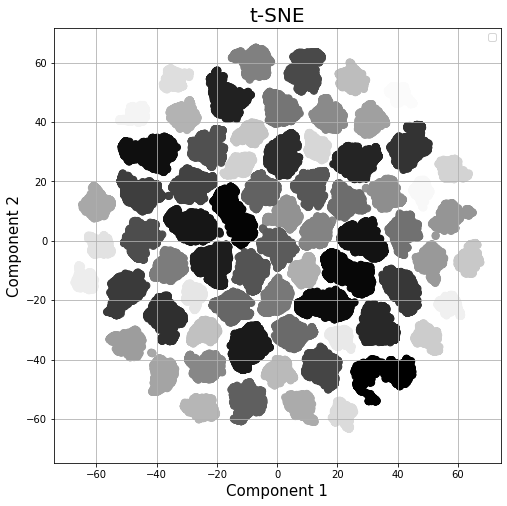

In [162]:
colors = []
for time in temp_embeddings_tsne_df['Time']:
    colors.append((time / 70, time / 70, time / 70))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_18_df['component 1'], temp_embeddings_tsne_18_df['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

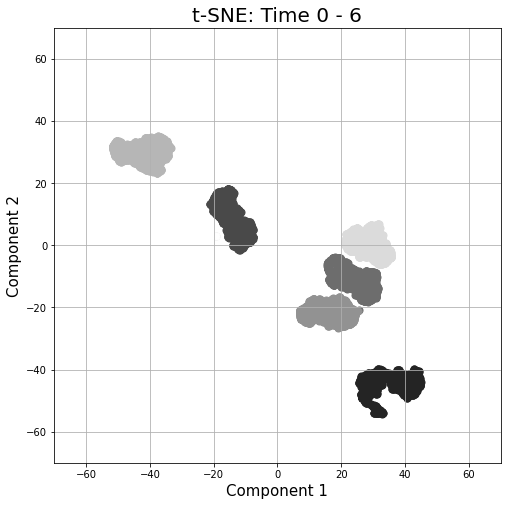

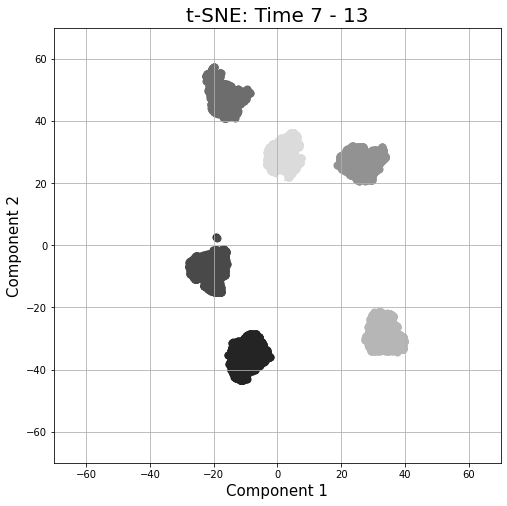

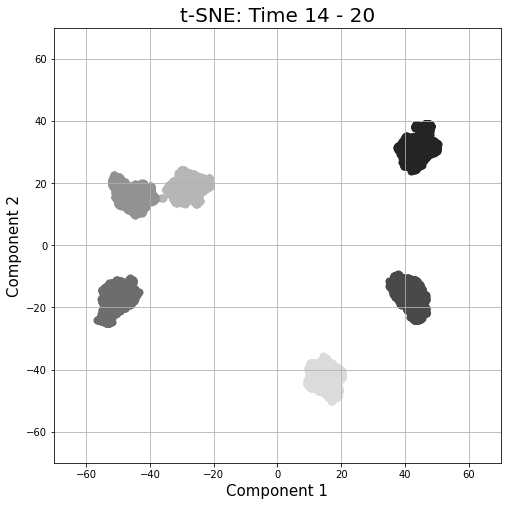

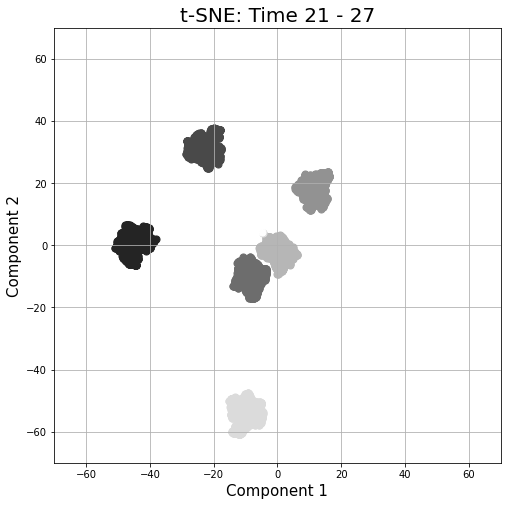

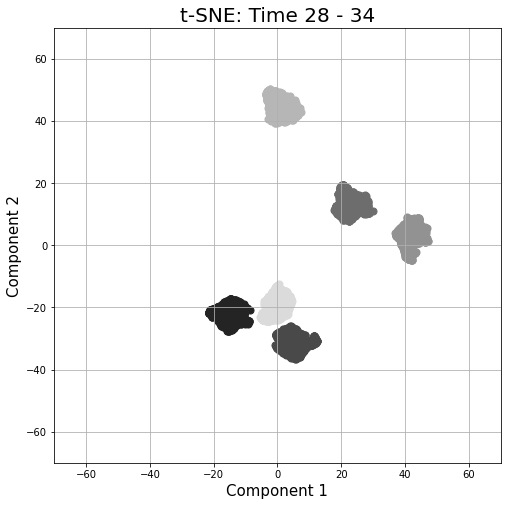

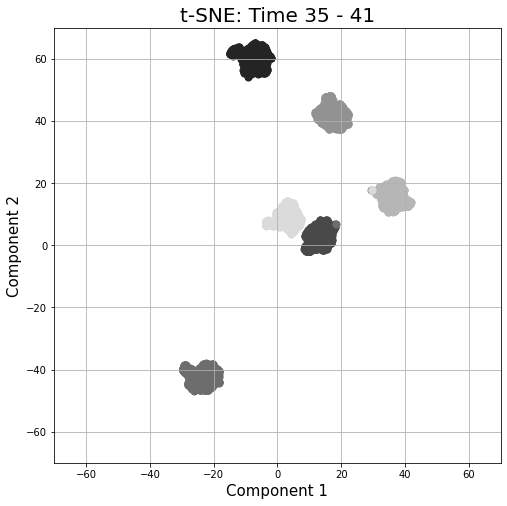

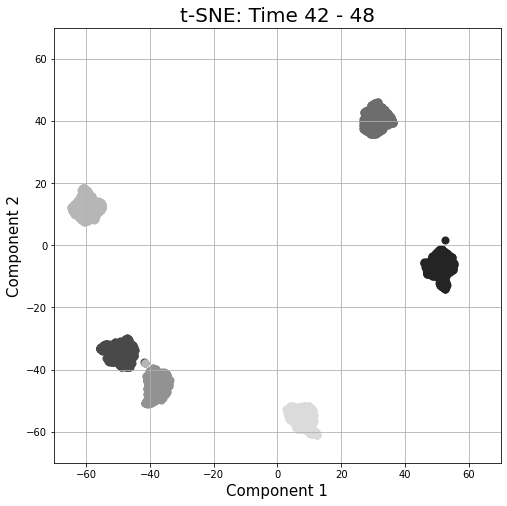

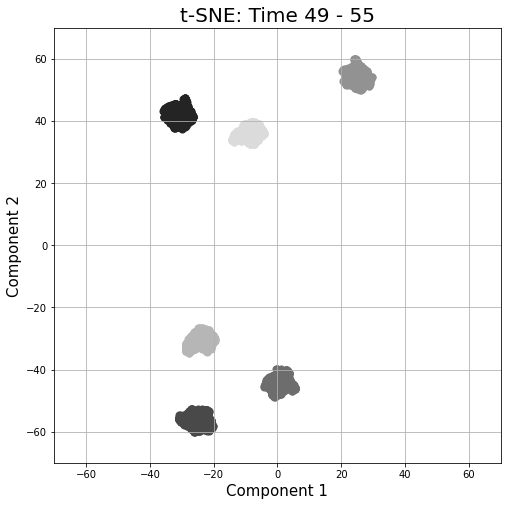

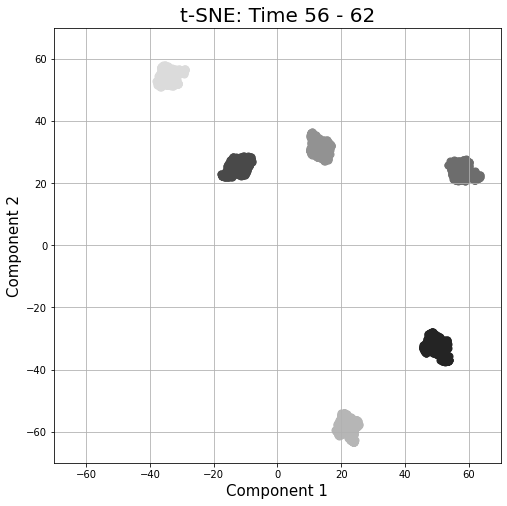

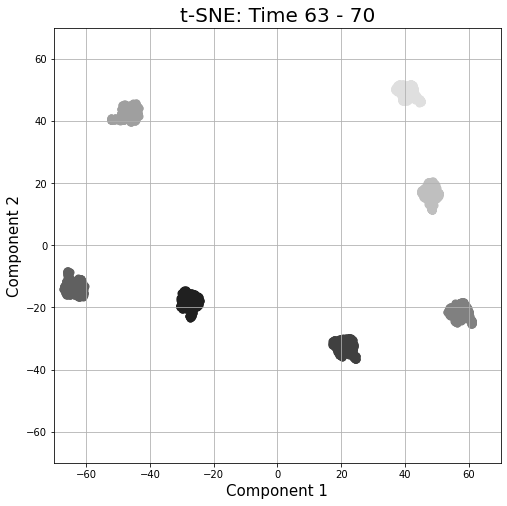

In [166]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title('t-SNE: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    plt.xlim(-70, 70)
    plt.ylim(-70, 70)
    times = [time for time in range(time_init, time_final + 1)]
    colors = []
    for time in times:
        num_times = time_final - time_init + 1
        time_pos = time - time_init
        colors.append(((time_pos + 1) / num_times, (time_pos + 1) / num_times, (time_pos + 1) / num_times))
    for i in range(len(times)):
        time = times[i]
        indices_to_keep = (temp_embeddings_tsne_18_df['Time'] == time)
        ax.scatter(temp_embeddings_tsne_18_df.loc[indices_to_keep, 'component 1'], temp_embeddings_tsne_18_df.loc[indices_to_keep, 'component 2'], c = colors[i], s = 50)
    ax.grid()

In [167]:
tsne_high_perp = TSNE(n_components=2, perplexity=816.56)

In [168]:
temp_embeddings_tsne_high_perp_18_df = project_embeddings_tsne(temp_embeddings_pca_18_df, tsne_high_perp)

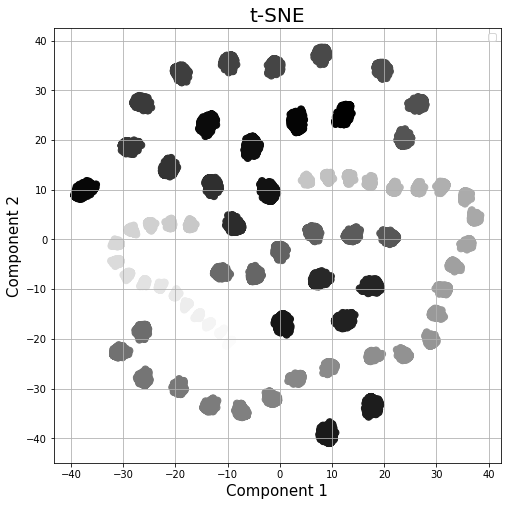

In [170]:
colors = []
for time in temp_embeddings_tsne_df['Time']:
    colors.append((time / 70, time / 70, time / 70))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('t-SNE', fontsize = 20)
ax.scatter(temp_embeddings_tsne_high_perp_18_df['component 1'], temp_embeddings_tsne_high_perp_18_df['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

In [ ]:
for time_sect in range(10):
    time_init = math.floor(shape[1] * time_sect / 10)
    time_final = math.floor(shape[1] * (time_sect + 1) / 10) - 1
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title('t-SNE: Time ' + str(time_init) + ' - ' + str(time_final), fontsize = 20)
    plt.xlim(-70, 70)
    plt.ylim(-70, 70)
    times = [time for time in range(time_init, time_final + 1)]
    colors = []
    for time in times:
        num_times = time_final - time_init + 1
        time_pos = time - time_init
        colors.append(((time_pos + 1) / num_times, (time_pos + 1) / num_times, (time_pos + 1) / num_times))
    for i in range(len(times)):
        time = times[i]
        indices_to_keep = (temp_embeddings_tsne_18_df['Time'] == time)
        ax.scatter(temp_embeddings_tsne_18_df.loc[indices_to_keep, 'component 1'], temp_embeddings_tsne_18_df.loc[indices_to_keep, 'component 2'], c = colors[i], s = 50)
    ax.grid()